In [39]:
from sys import path
path.append('../src/')

import os
import mlflow
import mlflow.keras
import numpy as np
import pickle as pkl
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from skmultilearn.model_selection import iterative_train_test_split

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

In [40]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Fine-tuning'

FILE_BASE_MODEL = '../models/autoencoders_requirements/merged_model_best_branches.h5'

In [41]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes, y)
    class_weights = dict(zip(classes, weights))
    return class_weights

def get_output_counts(output_names, y):
    output_counts = [np.unique(y[:, i], return_counts=True) for i in range(y.shape[1])]
    output_prop = [(unique, counts / counts.sum()) for unique, counts in output_counts]

    dict_counts = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_counts)}
    dict_props = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_prop)}
    return dict_counts, dict_props

# Load Data

In [42]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

y = np.array([mrk.photo_reqs.values() for mrk in mrks])

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)
print(y.shape, y.dtype)

(5763, 224, 224, 3) float32
(5763,) object
(5763, 23) int32


# Load Model

In [43]:
model = load_model(FILE_BASE_MODEL)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Fine-tuning 

In [44]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx] / 255
x_val = x[x_val_idx] / 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(4595, 224, 224, 3) float32
(4595, 23) int32
(1168, 224, 224, 3) float32
(1168, 23) int32


In [45]:
output_names = [name for name in model.output_names]
dict_train, dict_train_props = get_output_counts(output_names, y_train)
dict_val, dict_val_props = get_output_counts(output_names, y_val)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4595 samples, validate on 1168 samples
Epoch 1/100
4595/4595 [==============================] - 43s 9ms/step - loss: 9.8699 - blurred_loss: 0.4546 - looking_away_loss: 0.5370 - ink_marked_creased_loss: 0.6851 - unnatural_skin_tone_loss: 0.4416 - too_dark_light_loss: 0.2696 - washed_out_loss: 0.3859 - pixelation_loss: 0.5813 - hair_across_eyes_loss: 0.4519 - eyes_closed_loss: 0.5436 - varied_background_loss: 0.2652 - roll_pitch_yaw_loss: 0.5628 - flash_reflection_on_skin_loss: 0.4063 - red_eyes_loss: 0.5271 - shadows_behind_head_loss: 0.3455 - shadows_across_face_loss: 0.5269 - dark_tinted_lenses_loss: 0.3990 - flash_reflection_on_lenses_loss: 0.4608 - frames_too_heavy_loss: 0.1684 - frame_covering_eyes_loss: 0.4943 - hat_cap_loss: 0.3863 - veil_over_face_loss: 0.2552 - mouth_open_loss: 0.5028 - presence_of_other_faces_or_toys_loss: 0.2157 - blurred_accuracy: 0.7149 - blurred_matthews_correlation_coefficient: 0.4031 - looking_away_accuracy: 0.7380 - looking_away_matthews_correl

  64/4595 [..............................] - ETA: 24s - loss: 8.5047 - blurred_loss: 0.4650 - looking_away_loss: 0.6420 - ink_marked_creased_loss: 0.3155 - unnatural_skin_tone_loss: 0.3617 - too_dark_light_loss: 0.3009 - washed_out_loss: 0.1244 - pixelation_loss: 0.4414 - hair_across_eyes_loss: 0.4712 - eyes_closed_loss: 0.6373 - varied_background_loss: 0.1794 - roll_pitch_yaw_loss: 0.5084 - flash_reflection_on_skin_loss: 0.3868 - red_eyes_loss: 0.4778 - shadows_behind_head_loss: 0.4060 - shadows_across_face_loss: 0.5290 - dark_tinted_lenses_loss: 0.3843 - flash_reflection_on_lenses_loss: 0.4137 - frames_too_heavy_loss: 0.0604 - frame_covering_eyes_loss: 0.4501 - hat_cap_loss: 0.2896 - veil_over_face_loss: 0.0757 - mouth_open_loss: 0.4736 - presence_of_other_faces_or_toys_loss: 0.1107 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5475 - looking_away_accuracy: 0.5469 - looking_away_matthews_correlation_coefficient: 0.1524 - ink_marked_creased_accuracy: 0.7031 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.4491 - blurred_loss: 0.4517 - looking_away_loss: 0.5326 - ink_marked_creased_loss: 0.7008 - unnatural_skin_tone_loss: 0.4353 - too_dark_light_loss: 0.2537 - washed_out_loss: 0.2481 - pixelation_loss: 0.5793 - hair_across_eyes_loss: 0.4506 - eyes_closed_loss: 0.5347 - varied_background_loss: 0.2465 - roll_pitch_yaw_loss: 0.5585 - flash_reflection_on_skin_loss: 0.3855 - red_eyes_loss: 0.5190 - shadows_behind_head_loss: 0.3369 - shadows_across_face_loss: 0.5253 - dark_tinted_lenses_loss: 0.3693 - flash_reflection_on_lenses_loss: 0.4338 - frames_too_heavy_loss: 0.1282 - frame_covering_eyes_loss: 0.4804 - hat_cap_loss: 0.3764 - veil_over_face_loss: 0.2262 - mouth_open_loss: 0.4974 - presence_of_other_faces_or_toys_loss: 0.1764 - blurred_accuracy: 0.7293 - blurred_matthews_correlation_coefficient: 0.4123 - looking_away_accuracy: 0.7245 - looking_away_matthews_correlation_coefficient: 0.4235 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 8.4936 - blurred_loss: 0.4431 - looking_away_loss: 0.4402 - ink_marked_creased_loss: 0.3170 - unnatural_skin_tone_loss: 0.4493 - too_dark_light_loss: 0.1686 - washed_out_loss: 0.0588 - pixelation_loss: 0.6541 - hair_across_eyes_loss: 0.3861 - eyes_closed_loss: 0.4309 - varied_background_loss: 0.3157 - roll_pitch_yaw_loss: 0.6403 - flash_reflection_on_skin_loss: 0.3342 - red_eyes_loss: 0.4651 - shadows_behind_head_loss: 0.2769 - shadows_across_face_loss: 0.5225 - dark_tinted_lenses_loss: 0.3882 - flash_reflection_on_lenses_loss: 0.4330 - frames_too_heavy_loss: 0.1879 - frame_covering_eyes_loss: 0.4802 - hat_cap_loss: 0.3742 - veil_over_face_loss: 0.1736 - mouth_open_loss: 0.4390 - presence_of_other_faces_or_toys_loss: 0.1148 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4327 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5878 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.4351 - blurred_loss: 0.4411 - looking_away_loss: 0.5294 - ink_marked_creased_loss: 0.6829 - unnatural_skin_tone_loss: 0.4311 - too_dark_light_loss: 0.2486 - washed_out_loss: 0.2560 - pixelation_loss: 0.5686 - hair_across_eyes_loss: 0.4519 - eyes_closed_loss: 0.5339 - varied_background_loss: 0.2474 - roll_pitch_yaw_loss: 0.5590 - flash_reflection_on_skin_loss: 0.3882 - red_eyes_loss: 0.5173 - shadows_behind_head_loss: 0.3308 - shadows_across_face_loss: 0.5231 - dark_tinted_lenses_loss: 0.3505 - flash_reflection_on_lenses_loss: 0.4349 - frames_too_heavy_loss: 0.1688 - frame_covering_eyes_loss: 0.4790 - hat_cap_loss: 0.3685 - veil_over_face_loss: 0.2141 - mouth_open_loss: 0.4920 - presence_of_other_faces_or_toys_loss: 0.2144 - blurred_accuracy: 0.7232 - blurred_matthews_correlation_coefficient: 0.4122 - looking_away_accuracy: 0.7375 - looking_away_matthews_correlation_coefficient: 0.4388 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.6372 - blurred_loss: 0.4659 - looking_away_loss: 0.6353 - ink_marked_creased_loss: 0.3219 - unnatural_skin_tone_loss: 0.5634 - too_dark_light_loss: 0.1772 - washed_out_loss: 0.0814 - pixelation_loss: 0.5413 - hair_across_eyes_loss: 0.5148 - eyes_closed_loss: 0.6398 - varied_background_loss: 0.2658 - roll_pitch_yaw_loss: 0.5550 - flash_reflection_on_skin_loss: 0.4304 - red_eyes_loss: 0.6198 - shadows_behind_head_loss: 0.3135 - shadows_across_face_loss: 0.5209 - dark_tinted_lenses_loss: 0.5139 - flash_reflection_on_lenses_loss: 0.5353 - frames_too_heavy_loss: 0.0642 - frame_covering_eyes_loss: 0.5917 - hat_cap_loss: 0.3797 - veil_over_face_loss: 0.0931 - mouth_open_loss: 0.5634 - presence_of_other_faces_or_toys_loss: 0.2495 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.2405 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4664 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.4247 - blurred_loss: 0.4409 - looking_away_loss: 0.5183 - ink_marked_creased_loss: 0.6936 - unnatural_skin_tone_loss: 0.4277 - too_dark_light_loss: 0.2462 - washed_out_loss: 0.3372 - pixelation_loss: 0.5636 - hair_across_eyes_loss: 0.4485 - eyes_closed_loss: 0.5150 - varied_background_loss: 0.2350 - roll_pitch_yaw_loss: 0.5604 - flash_reflection_on_skin_loss: 0.3833 - red_eyes_loss: 0.5048 - shadows_behind_head_loss: 0.3315 - shadows_across_face_loss: 0.5154 - dark_tinted_lenses_loss: 0.3355 - flash_reflection_on_lenses_loss: 0.4302 - frames_too_heavy_loss: 0.1707 - frame_covering_eyes_loss: 0.4719 - hat_cap_loss: 0.3697 - veil_over_face_loss: 0.2287 - mouth_open_loss: 0.4836 - presence_of_other_faces_or_toys_loss: 0.2112 - blurred_accuracy: 0.7393 - blurred_matthews_correlation_coefficient: 0.4240 - looking_away_accuracy: 0.7423 - looking_away_matthews_correlation_coefficient: 0.4562 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.0742 - blurred_loss: 0.4932 - looking_away_loss: 0.4791 - ink_marked_creased_loss: 0.3170 - unnatural_skin_tone_loss: 0.4759 - too_dark_light_loss: 0.2075 - washed_out_loss: 0.1363 - pixelation_loss: 0.7277 - hair_across_eyes_loss: 0.5358 - eyes_closed_loss: 0.5367 - varied_background_loss: 0.4111 - roll_pitch_yaw_loss: 0.5625 - flash_reflection_on_skin_loss: 0.3495 - red_eyes_loss: 0.5663 - shadows_behind_head_loss: 0.4593 - shadows_across_face_loss: 0.4701 - dark_tinted_lenses_loss: 0.2901 - flash_reflection_on_lenses_loss: 0.4892 - frames_too_heavy_loss: 0.1160 - frame_covering_eyes_loss: 0.5015 - hat_cap_loss: 0.3532 - veil_over_face_loss: 0.0706 - mouth_open_loss: 0.4479 - presence_of_other_faces_or_toys_loss: 0.0777 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.2696 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3755 - ink_marked_creased_accuracy: 0.5156 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.2644 - blurred_loss: 0.4372 - looking_away_loss: 0.5180 - ink_marked_creased_loss: 0.6878 - unnatural_skin_tone_loss: 0.4272 - too_dark_light_loss: 0.2424 - washed_out_loss: 0.2092 - pixelation_loss: 0.5632 - hair_across_eyes_loss: 0.4466 - eyes_closed_loss: 0.5196 - varied_background_loss: 0.2465 - roll_pitch_yaw_loss: 0.5579 - flash_reflection_on_skin_loss: 0.3842 - red_eyes_loss: 0.5024 - shadows_behind_head_loss: 0.3346 - shadows_across_face_loss: 0.5170 - dark_tinted_lenses_loss: 0.3312 - flash_reflection_on_lenses_loss: 0.4368 - frames_too_heavy_loss: 0.1891 - frame_covering_eyes_loss: 0.4687 - hat_cap_loss: 0.3602 - veil_over_face_loss: 0.2158 - mouth_open_loss: 0.4877 - presence_of_other_faces_or_toys_loss: 0.1808 - blurred_accuracy: 0.7271 - blurred_matthews_correlation_coefficient: 0.4122 - looking_away_accuracy: 0.7430 - looking_away_matthews_correlation_coefficient: 0.4569 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.9612 - blurred_loss: 0.5166 - looking_away_loss: 0.5718 - ink_marked_creased_loss: 0.3370 - unnatural_skin_tone_loss: 0.5265 - too_dark_light_loss: 0.1561 - washed_out_loss: 0.1134 - pixelation_loss: 0.6543 - hair_across_eyes_loss: 0.5820 - eyes_closed_loss: 0.5486 - varied_background_loss: 0.1560 - roll_pitch_yaw_loss: 0.6211 - flash_reflection_on_skin_loss: 0.3761 - red_eyes_loss: 0.6171 - shadows_behind_head_loss: 0.4129 - shadows_across_face_loss: 0.5482 - dark_tinted_lenses_loss: 0.4010 - flash_reflection_on_lenses_loss: 0.5483 - frames_too_heavy_loss: 0.0754 - frame_covering_eyes_loss: 0.5711 - hat_cap_loss: 0.3277 - veil_over_face_loss: 0.7480 - mouth_open_loss: 0.4401 - presence_of_other_faces_or_toys_loss: 0.1118 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5720 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.5009 - ink_marked_creased_accuracy: 0.4531 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.0788 - blurred_loss: 0.4329 - looking_away_loss: 0.5170 - ink_marked_creased_loss: 0.6686 - unnatural_skin_tone_loss: 0.4197 - too_dark_light_loss: 0.2388 - washed_out_loss: 0.1947 - pixelation_loss: 0.5698 - hair_across_eyes_loss: 0.4464 - eyes_closed_loss: 0.5148 - varied_background_loss: 0.2406 - roll_pitch_yaw_loss: 0.5579 - flash_reflection_on_skin_loss: 0.3785 - red_eyes_loss: 0.4964 - shadows_behind_head_loss: 0.3238 - shadows_across_face_loss: 0.5137 - dark_tinted_lenses_loss: 0.3144 - flash_reflection_on_lenses_loss: 0.4200 - frames_too_heavy_loss: 0.1547 - frame_covering_eyes_loss: 0.4640 - hat_cap_loss: 0.3596 - veil_over_face_loss: 0.1903 - mouth_open_loss: 0.4905 - presence_of_other_faces_or_toys_loss: 0.1744 - blurred_accuracy: 0.7469 - blurred_matthews_correlation_coefficient: 0.4408 - looking_away_accuracy: 0.7354 - looking_away_matthews_correlation_coefficient: 0.4475 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.2862 - blurred_loss: 0.4746 - looking_away_loss: 0.5218 - ink_marked_creased_loss: 0.3153 - unnatural_skin_tone_loss: 0.3945 - too_dark_light_loss: 0.0906 - washed_out_loss: 0.1023 - pixelation_loss: 0.6366 - hair_across_eyes_loss: 0.4546 - eyes_closed_loss: 0.4759 - varied_background_loss: 0.1760 - roll_pitch_yaw_loss: 0.5590 - flash_reflection_on_skin_loss: 0.3604 - red_eyes_loss: 0.3786 - shadows_behind_head_loss: 0.3816 - shadows_across_face_loss: 0.4684 - dark_tinted_lenses_loss: 0.2114 - flash_reflection_on_lenses_loss: 0.5106 - frames_too_heavy_loss: 0.1882 - frame_covering_eyes_loss: 0.3776 - hat_cap_loss: 0.3509 - veil_over_face_loss: 0.0356 - mouth_open_loss: 0.4348 - presence_of_other_faces_or_toys_loss: 0.3868 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.2301 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4284 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.0158 - blurred_loss: 0.4375 - looking_away_loss: 0.5122 - ink_marked_creased_loss: 0.6919 - unnatural_skin_tone_loss: 0.4195 - too_dark_light_loss: 0.2333 - washed_out_loss: 0.1904 - pixelation_loss: 0.5649 - hair_across_eyes_loss: 0.4471 - eyes_closed_loss: 0.5106 - varied_background_loss: 0.2341 - roll_pitch_yaw_loss: 0.5556 - flash_reflection_on_skin_loss: 0.3765 - red_eyes_loss: 0.4915 - shadows_behind_head_loss: 0.3242 - shadows_across_face_loss: 0.5123 - dark_tinted_lenses_loss: 0.3044 - flash_reflection_on_lenses_loss: 0.4246 - frames_too_heavy_loss: 0.0958 - frame_covering_eyes_loss: 0.4659 - hat_cap_loss: 0.3457 - veil_over_face_loss: 0.1967 - mouth_open_loss: 0.4800 - presence_of_other_faces_or_toys_loss: 0.1941 - blurred_accuracy: 0.7380 - blurred_matthews_correlation_coefficient: 0.4276 - looking_away_accuracy: 0.7447 - looking_away_matthews_correlation_coefficient: 0.4599 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.8420 - blurred_loss: 0.4237 - looking_away_loss: 0.5044 - ink_marked_creased_loss: 0.3193 - unnatural_skin_tone_loss: 0.4029 - too_dark_light_loss: 0.2602 - washed_out_loss: 0.1178 - pixelation_loss: 0.6127 - hair_across_eyes_loss: 0.4409 - eyes_closed_loss: 0.5367 - varied_background_loss: 0.2430 - roll_pitch_yaw_loss: 0.5647 - flash_reflection_on_skin_loss: 0.4416 - red_eyes_loss: 0.4636 - shadows_behind_head_loss: 0.4171 - shadows_across_face_loss: 0.5439 - dark_tinted_lenses_loss: 0.3617 - flash_reflection_on_lenses_loss: 0.4385 - frames_too_heavy_loss: 0.0199 - frame_covering_eyes_loss: 0.5028 - hat_cap_loss: 0.5111 - veil_over_face_loss: 0.0607 - mouth_open_loss: 0.5604 - presence_of_other_faces_or_toys_loss: 0.0942 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5168 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.3971 - ink_marked_creased_accuracy: 0.4844 

4595/4595 [==============================] - 27s 6ms/step - loss: 9.0370 - blurred_loss: 0.4409 - looking_away_loss: 0.5128 - ink_marked_creased_loss: 0.6759 - unnatural_skin_tone_loss: 0.4249 - too_dark_light_loss: 0.2321 - washed_out_loss: 0.2228 - pixelation_loss: 0.5644 - hair_across_eyes_loss: 0.4509 - eyes_closed_loss: 0.5054 - varied_background_loss: 0.2361 - roll_pitch_yaw_loss: 0.5592 - flash_reflection_on_skin_loss: 0.3835 - red_eyes_loss: 0.4889 - shadows_behind_head_loss: 0.3292 - shadows_across_face_loss: 0.5186 - dark_tinted_lenses_loss: 0.2933 - flash_reflection_on_lenses_loss: 0.4247 - frames_too_heavy_loss: 0.1319 - frame_covering_eyes_loss: 0.4657 - hat_cap_loss: 0.3466 - veil_over_face_loss: 0.1840 - mouth_open_loss: 0.4860 - presence_of_other_faces_or_toys_loss: 0.1606 - blurred_accuracy: 0.7345 - blurred_matthews_correlation_coefficient: 0.4118 - looking_away_accuracy: 0.7489 - looking_away_matthews_correlation_coefficient: 0.4662 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.0043 - blurred_loss: 0.3883 - looking_away_loss: 0.4044 - ink_marked_creased_loss: 0.3296 - unnatural_skin_tone_loss: 0.3313 - too_dark_light_loss: 0.4298 - washed_out_loss: 0.2118 - pixelation_loss: 0.5465 - hair_across_eyes_loss: 0.4403 - eyes_closed_loss: 0.4670 - varied_background_loss: 0.2887 - roll_pitch_yaw_loss: 0.4932 - flash_reflection_on_skin_loss: 0.3777 - red_eyes_loss: 0.5877 - shadows_behind_head_loss: 0.2836 - shadows_across_face_loss: 0.4426 - dark_tinted_lenses_loss: 0.2401 - flash_reflection_on_lenses_loss: 0.3169 - frames_too_heavy_loss: 0.0659 - frame_covering_eyes_loss: 0.3921 - hat_cap_loss: 0.3292 - veil_over_face_loss: 0.1039 - mouth_open_loss: 0.4675 - presence_of_other_faces_or_toys_loss: 0.0665 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5212 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5245 - ink_marked_creased_accuracy: 0.4844 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.9390 - blurred_loss: 0.4350 - looking_away_loss: 0.5074 - ink_marked_creased_loss: 0.6749 - unnatural_skin_tone_loss: 0.4219 - too_dark_light_loss: 0.2256 - washed_out_loss: 0.1952 - pixelation_loss: 0.5554 - hair_across_eyes_loss: 0.4437 - eyes_closed_loss: 0.5014 - varied_background_loss: 0.2395 - roll_pitch_yaw_loss: 0.5573 - flash_reflection_on_skin_loss: 0.3782 - red_eyes_loss: 0.4858 - shadows_behind_head_loss: 0.3270 - shadows_across_face_loss: 0.5138 - dark_tinted_lenses_loss: 0.2913 - flash_reflection_on_lenses_loss: 0.4173 - frames_too_heavy_loss: 0.0790 - frame_covering_eyes_loss: 0.4635 - hat_cap_loss: 0.3448 - veil_over_face_loss: 0.1785 - mouth_open_loss: 0.4847 - presence_of_other_faces_or_toys_loss: 0.2137 - blurred_accuracy: 0.7458 - blurred_matthews_correlation_coefficient: 0.4429 - looking_away_accuracy: 0.7456 - looking_away_matthews_correlation_coefficient: 0.4733 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 8.2842 - blurred_loss: 0.5080 - looking_away_loss: 0.4790 - ink_marked_creased_loss: 0.3214 - unnatural_skin_tone_loss: 0.3179 - too_dark_light_loss: 0.2436 - washed_out_loss: 0.1068 - pixelation_loss: 0.4726 - hair_across_eyes_loss: 0.5332 - eyes_closed_loss: 0.4930 - varied_background_loss: 0.1143 - roll_pitch_yaw_loss: 0.4788 - flash_reflection_on_skin_loss: 0.5134 - red_eyes_loss: 0.5060 - shadows_behind_head_loss: 0.3146 - shadows_across_face_loss: 0.5860 - dark_tinted_lenses_loss: 0.2117 - flash_reflection_on_lenses_loss: 0.3255 - frames_too_heavy_loss: 0.0971 - frame_covering_eyes_loss: 0.5146 - hat_cap_loss: 0.4011 - veil_over_face_loss: 0.0713 - mouth_open_loss: 0.4641 - presence_of_other_faces_or_toys_loss: 0.2102 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4152 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5858 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.7464 - blurred_loss: 0.4298 - looking_away_loss: 0.5047 - ink_marked_creased_loss: 0.6659 - unnatural_skin_tone_loss: 0.4123 - too_dark_light_loss: 0.2245 - washed_out_loss: 0.1677 - pixelation_loss: 0.5615 - hair_across_eyes_loss: 0.4369 - eyes_closed_loss: 0.4987 - varied_background_loss: 0.2333 - roll_pitch_yaw_loss: 0.5557 - flash_reflection_on_skin_loss: 0.3725 - red_eyes_loss: 0.4797 - shadows_behind_head_loss: 0.3230 - shadows_across_face_loss: 0.5065 - dark_tinted_lenses_loss: 0.2756 - flash_reflection_on_lenses_loss: 0.4157 - frames_too_heavy_loss: 0.0690 - frame_covering_eyes_loss: 0.4612 - hat_cap_loss: 0.3279 - veil_over_face_loss: 0.1849 - mouth_open_loss: 0.4778 - presence_of_other_faces_or_toys_loss: 0.1582 - blurred_accuracy: 0.7428 - blurred_matthews_correlation_coefficient: 0.4226 - looking_away_accuracy: 0.7550 - looking_away_matthews_correlation_coefficient: 0.4896 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 7.2334 - blurred_loss: 0.4269 - looking_away_loss: 0.3582 - ink_marked_creased_loss: 0.3140 - unnatural_skin_tone_loss: 0.4064 - too_dark_light_loss: 0.1462 - washed_out_loss: 0.0666 - pixelation_loss: 0.4659 - hair_across_eyes_loss: 0.3604 - eyes_closed_loss: 0.3451 - varied_background_loss: 0.2029 - roll_pitch_yaw_loss: 0.5843 - flash_reflection_on_skin_loss: 0.3823 - red_eyes_loss: 0.3157 - shadows_behind_head_loss: 0.3482 - shadows_across_face_loss: 0.3742 - dark_tinted_lenses_loss: 0.2230 - flash_reflection_on_lenses_loss: 0.4014 - frames_too_heavy_loss: 0.0247 - frame_covering_eyes_loss: 0.4419 - hat_cap_loss: 0.1549 - veil_over_face_loss: 0.2270 - mouth_open_loss: 0.5781 - presence_of_other_faces_or_toys_loss: 0.0850 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5010 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6160 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.7308 - blurred_loss: 0.4290 - looking_away_loss: 0.5031 - ink_marked_creased_loss: 0.6904 - unnatural_skin_tone_loss: 0.4198 - too_dark_light_loss: 0.2202 - washed_out_loss: 0.1759 - pixelation_loss: 0.5549 - hair_across_eyes_loss: 0.4447 - eyes_closed_loss: 0.4985 - varied_background_loss: 0.2242 - roll_pitch_yaw_loss: 0.5548 - flash_reflection_on_skin_loss: 0.3743 - red_eyes_loss: 0.4808 - shadows_behind_head_loss: 0.3220 - shadows_across_face_loss: 0.5074 - dark_tinted_lenses_loss: 0.2619 - flash_reflection_on_lenses_loss: 0.4098 - frames_too_heavy_loss: 0.0625 - frame_covering_eyes_loss: 0.4565 - hat_cap_loss: 0.3387 - veil_over_face_loss: 0.1941 - mouth_open_loss: 0.4758 - presence_of_other_faces_or_toys_loss: 0.1507 - blurred_accuracy: 0.7491 - blurred_matthews_correlation_coefficient: 0.4445 - looking_away_accuracy: 0.7532 - looking_away_matthews_correlation_coefficient: 0.4722 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.6520 - blurred_loss: 0.3725 - looking_away_loss: 0.4858 - ink_marked_creased_loss: 0.2909 - unnatural_skin_tone_loss: 0.4051 - too_dark_light_loss: 0.2498 - washed_out_loss: 0.0812 - pixelation_loss: 0.5128 - hair_across_eyes_loss: 0.3476 - eyes_closed_loss: 0.4719 - varied_background_loss: 0.2098 - roll_pitch_yaw_loss: 0.5288 - flash_reflection_on_skin_loss: 0.4057 - red_eyes_loss: 0.4391 - shadows_behind_head_loss: 0.3144 - shadows_across_face_loss: 0.4964 - dark_tinted_lenses_loss: 0.2154 - flash_reflection_on_lenses_loss: 0.4411 - frames_too_heavy_loss: 0.1100 - frame_covering_eyes_loss: 0.3727 - hat_cap_loss: 0.3764 - veil_over_face_loss: 0.0528 - mouth_open_loss: 0.4000 - presence_of_other_faces_or_toys_loss: 0.0718 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5286 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.5032 - ink_marked_creased_accuracy: 0.7344 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.7715 - blurred_loss: 0.4259 - looking_away_loss: 0.5019 - ink_marked_creased_loss: 0.6756 - unnatural_skin_tone_loss: 0.4205 - too_dark_light_loss: 0.2177 - washed_out_loss: 0.1540 - pixelation_loss: 0.5570 - hair_across_eyes_loss: 0.4411 - eyes_closed_loss: 0.4921 - varied_background_loss: 0.2285 - roll_pitch_yaw_loss: 0.5578 - flash_reflection_on_skin_loss: 0.3755 - red_eyes_loss: 0.4792 - shadows_behind_head_loss: 0.3233 - shadows_across_face_loss: 0.5105 - dark_tinted_lenses_loss: 0.2569 - flash_reflection_on_lenses_loss: 0.4082 - frames_too_heavy_loss: 0.1219 - frame_covering_eyes_loss: 0.4523 - hat_cap_loss: 0.3353 - veil_over_face_loss: 0.1671 - mouth_open_loss: 0.4753 - presence_of_other_faces_or_toys_loss: 0.1893 - blurred_accuracy: 0.7397 - blurred_matthews_correlation_coefficient: 0.4325 - looking_away_accuracy: 0.7534 - looking_away_matthews_correlation_coefficient: 0.4829 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.5395 - blurred_loss: 0.5337 - looking_away_loss: 0.4551 - ink_marked_creased_loss: 0.3205 - unnatural_skin_tone_loss: 0.4305 - too_dark_light_loss: 0.1492 - washed_out_loss: 0.0829 - pixelation_loss: 0.3624 - hair_across_eyes_loss: 0.4376 - eyes_closed_loss: 0.4378 - varied_background_loss: 0.1227 - roll_pitch_yaw_loss: 0.6320 - flash_reflection_on_skin_loss: 0.4621 - red_eyes_loss: 0.4505 - shadows_behind_head_loss: 0.2306 - shadows_across_face_loss: 0.5355 - dark_tinted_lenses_loss: 0.2313 - flash_reflection_on_lenses_loss: 0.2646 - frames_too_heavy_loss: 0.1210 - frame_covering_eyes_loss: 0.3736 - hat_cap_loss: 0.2771 - veil_over_face_loss: 0.0622 - mouth_open_loss: 0.4261 - presence_of_other_faces_or_toys_loss: 0.1402 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4760 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5833 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.6360 - blurred_loss: 0.4317 - looking_away_loss: 0.4948 - ink_marked_creased_loss: 0.6583 - unnatural_skin_tone_loss: 0.4189 - too_dark_light_loss: 0.2187 - washed_out_loss: 0.1664 - pixelation_loss: 0.5554 - hair_across_eyes_loss: 0.4370 - eyes_closed_loss: 0.4854 - varied_background_loss: 0.2294 - roll_pitch_yaw_loss: 0.5579 - flash_reflection_on_skin_loss: 0.3744 - red_eyes_loss: 0.4691 - shadows_behind_head_loss: 0.3180 - shadows_across_face_loss: 0.5058 - dark_tinted_lenses_loss: 0.2451 - flash_reflection_on_lenses_loss: 0.4009 - frames_too_heavy_loss: 0.0754 - frame_covering_eyes_loss: 0.4540 - hat_cap_loss: 0.3325 - veil_over_face_loss: 0.1674 - mouth_open_loss: 0.4768 - presence_of_other_faces_or_toys_loss: 0.1603 - blurred_accuracy: 0.7484 - blurred_matthews_correlation_coefficient: 0.4372 - looking_away_accuracy: 0.7558 - looking_away_matthews_correlation_coefficient: 0.4869 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9997 - blurred_loss: 0.4492 - looking_away_loss: 0.5318 - ink_marked_creased_loss: 0.3061 - unnatural_skin_tone_loss: 0.3778 - too_dark_light_loss: 0.1727 - washed_out_loss: 0.0651 - pixelation_loss: 0.3281 - hair_across_eyes_loss: 0.5345 - eyes_closed_loss: 0.4490 - varied_background_loss: 0.1861 - roll_pitch_yaw_loss: 0.5153 - flash_reflection_on_skin_loss: 0.4201 - red_eyes_loss: 0.5524 - shadows_behind_head_loss: 0.2892 - shadows_across_face_loss: 0.4773 - dark_tinted_lenses_loss: 0.1890 - flash_reflection_on_lenses_loss: 0.4422 - frames_too_heavy_loss: 0.1043 - frame_covering_eyes_loss: 0.4427 - hat_cap_loss: 0.3767 - veil_over_face_loss: 0.1243 - mouth_open_loss: 0.4315 - presence_of_other_faces_or_toys_loss: 0.2343 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3083 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.3450 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.5199 - blurred_loss: 0.4274 - looking_away_loss: 0.4948 - ink_marked_creased_loss: 0.6590 - unnatural_skin_tone_loss: 0.4114 - too_dark_light_loss: 0.2130 - washed_out_loss: 0.1516 - pixelation_loss: 0.5515 - hair_across_eyes_loss: 0.4353 - eyes_closed_loss: 0.4840 - varied_background_loss: 0.2210 - roll_pitch_yaw_loss: 0.5536 - flash_reflection_on_skin_loss: 0.3738 - red_eyes_loss: 0.4655 - shadows_behind_head_loss: 0.3179 - shadows_across_face_loss: 0.5106 - dark_tinted_lenses_loss: 0.2354 - flash_reflection_on_lenses_loss: 0.4050 - frames_too_heavy_loss: 0.0455 - frame_covering_eyes_loss: 0.4491 - hat_cap_loss: 0.3295 - veil_over_face_loss: 0.1688 - mouth_open_loss: 0.4736 - presence_of_other_faces_or_toys_loss: 0.1459 - blurred_accuracy: 0.7467 - blurred_matthews_correlation_coefficient: 0.4286 - looking_away_accuracy: 0.7567 - looking_away_matthews_correlation_coefficient: 0.4787 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.5566 - blurred_loss: 0.4660 - looking_away_loss: 0.4490 - ink_marked_creased_loss: 0.2772 - unnatural_skin_tone_loss: 0.5458 - too_dark_light_loss: 0.1621 - washed_out_loss: 0.1125 - pixelation_loss: 0.4119 - hair_across_eyes_loss: 0.4449 - eyes_closed_loss: 0.4831 - varied_background_loss: 0.2202 - roll_pitch_yaw_loss: 0.6040 - flash_reflection_on_skin_loss: 0.4281 - red_eyes_loss: 0.4762 - shadows_behind_head_loss: 0.2315 - shadows_across_face_loss: 0.6197 - dark_tinted_lenses_loss: 0.3216 - flash_reflection_on_lenses_loss: 0.4282 - frames_too_heavy_loss: 0.4477 - frame_covering_eyes_loss: 0.4536 - hat_cap_loss: 0.2550 - veil_over_face_loss: 0.0505 - mouth_open_loss: 0.3019 - presence_of_other_faces_or_toys_loss: 0.3661 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3293 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6622 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.5090 - blurred_loss: 0.4266 - looking_away_loss: 0.4899 - ink_marked_creased_loss: 0.6636 - unnatural_skin_tone_loss: 0.4127 - too_dark_light_loss: 0.2175 - washed_out_loss: 0.1642 - pixelation_loss: 0.5565 - hair_across_eyes_loss: 0.4360 - eyes_closed_loss: 0.4818 - varied_background_loss: 0.2230 - roll_pitch_yaw_loss: 0.5539 - flash_reflection_on_skin_loss: 0.3697 - red_eyes_loss: 0.4595 - shadows_behind_head_loss: 0.3120 - shadows_across_face_loss: 0.5067 - dark_tinted_lenses_loss: 0.2325 - flash_reflection_on_lenses_loss: 0.3996 - frames_too_heavy_loss: 0.0588 - frame_covering_eyes_loss: 0.4440 - hat_cap_loss: 0.3227 - veil_over_face_loss: 0.1575 - mouth_open_loss: 0.4733 - presence_of_other_faces_or_toys_loss: 0.1507 - blurred_accuracy: 0.7467 - blurred_matthews_correlation_coefficient: 0.4321 - looking_away_accuracy: 0.7661 - looking_away_matthews_correlation_coefficient: 0.5057 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 9.5144 - blurred_loss: 0.3717 - looking_away_loss: 0.4639 - ink_marked_creased_loss: 1.6534 - unnatural_skin_tone_loss: 0.2974 - too_dark_light_loss: 0.1088 - washed_out_loss: 0.0917 - pixelation_loss: 0.4353 - hair_across_eyes_loss: 0.3900 - eyes_closed_loss: 0.4672 - varied_background_loss: 0.1725 - roll_pitch_yaw_loss: 0.5154 - flash_reflection_on_skin_loss: 0.3730 - red_eyes_loss: 0.4669 - shadows_behind_head_loss: 0.2960 - shadows_across_face_loss: 0.4599 - dark_tinted_lenses_loss: 0.2782 - flash_reflection_on_lenses_loss: 0.5284 - frames_too_heavy_loss: 0.0259 - frame_covering_eyes_loss: 0.3978 - hat_cap_loss: 0.2410 - veil_over_face_loss: 0.6357 - mouth_open_loss: 0.5282 - presence_of_other_faces_or_toys_loss: 0.3162 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5509 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4018 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.4358 - blurred_loss: 0.4217 - looking_away_loss: 0.4969 - ink_marked_creased_loss: 0.6593 - unnatural_skin_tone_loss: 0.4115 - too_dark_light_loss: 0.2023 - washed_out_loss: 0.1464 - pixelation_loss: 0.5560 - hair_across_eyes_loss: 0.4391 - eyes_closed_loss: 0.4853 - varied_background_loss: 0.2156 - roll_pitch_yaw_loss: 0.5546 - flash_reflection_on_skin_loss: 0.3683 - red_eyes_loss: 0.4643 - shadows_behind_head_loss: 0.3163 - shadows_across_face_loss: 0.5044 - dark_tinted_lenses_loss: 0.2231 - flash_reflection_on_lenses_loss: 0.3971 - frames_too_heavy_loss: 0.0552 - frame_covering_eyes_loss: 0.4479 - hat_cap_loss: 0.3119 - veil_over_face_loss: 0.1542 - mouth_open_loss: 0.4678 - presence_of_other_faces_or_toys_loss: 0.1403 - blurred_accuracy: 0.7515 - blurred_matthews_correlation_coefficient: 0.4441 - looking_away_accuracy: 0.7539 - looking_away_matthews_correlation_coefficient: 0.4768 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.0464 - blurred_loss: 0.4216 - looking_away_loss: 0.4084 - ink_marked_creased_loss: 0.3155 - unnatural_skin_tone_loss: 0.4227 - too_dark_light_loss: 0.1553 - washed_out_loss: 0.0506 - pixelation_loss: 0.7122 - hair_across_eyes_loss: 0.3159 - eyes_closed_loss: 0.3766 - varied_background_loss: 0.3016 - roll_pitch_yaw_loss: 0.5814 - flash_reflection_on_skin_loss: 0.3121 - red_eyes_loss: 0.3551 - shadows_behind_head_loss: 0.2745 - shadows_across_face_loss: 0.4546 - dark_tinted_lenses_loss: 0.1662 - flash_reflection_on_lenses_loss: 0.2849 - frames_too_heavy_loss: 0.0464 - frame_covering_eyes_loss: 0.3614 - hat_cap_loss: 0.2266 - veil_over_face_loss: 0.0405 - mouth_open_loss: 0.3589 - presence_of_other_faces_or_toys_loss: 0.1034 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4837 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5312 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.3437 - blurred_loss: 0.4257 - looking_away_loss: 0.4826 - ink_marked_creased_loss: 0.6429 - unnatural_skin_tone_loss: 0.4035 - too_dark_light_loss: 0.2083 - washed_out_loss: 0.1564 - pixelation_loss: 0.5460 - hair_across_eyes_loss: 0.4309 - eyes_closed_loss: 0.4701 - varied_background_loss: 0.2152 - roll_pitch_yaw_loss: 0.5531 - flash_reflection_on_skin_loss: 0.3650 - red_eyes_loss: 0.4511 - shadows_behind_head_loss: 0.3102 - shadows_across_face_loss: 0.5044 - dark_tinted_lenses_loss: 0.2228 - flash_reflection_on_lenses_loss: 0.3932 - frames_too_heavy_loss: 0.0460 - frame_covering_eyes_loss: 0.4399 - hat_cap_loss: 0.3119 - veil_over_face_loss: 0.1522 - mouth_open_loss: 0.4706 - presence_of_other_faces_or_toys_loss: 0.1356 - blurred_accuracy: 0.7499 - blurred_matthews_correlation_coefficient: 0.4392 - looking_away_accuracy: 0.7602 - looking_away_matthews_correlation_coefficient: 0.4897 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.6953 - blurred_loss: 0.3524 - looking_away_loss: 0.5162 - ink_marked_creased_loss: 0.2756 - unnatural_skin_tone_loss: 0.3720 - too_dark_light_loss: 0.1758 - washed_out_loss: 0.0557 - pixelation_loss: 0.5188 - hair_across_eyes_loss: 0.3420 - eyes_closed_loss: 0.4110 - varied_background_loss: 0.5141 - roll_pitch_yaw_loss: 0.5534 - flash_reflection_on_skin_loss: 0.3442 - red_eyes_loss: 0.3511 - shadows_behind_head_loss: 0.3765 - shadows_across_face_loss: 0.5195 - dark_tinted_lenses_loss: 0.2132 - flash_reflection_on_lenses_loss: 0.4102 - frames_too_heavy_loss: 0.0536 - frame_covering_eyes_loss: 0.3779 - hat_cap_loss: 0.3026 - veil_over_face_loss: 0.0506 - mouth_open_loss: 0.5907 - presence_of_other_faces_or_toys_loss: 0.0184 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.0186 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.1244 - ink_marked_creased_accuracy: 0.7656 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.3311 - blurred_loss: 0.4248 - looking_away_loss: 0.4886 - ink_marked_creased_loss: 0.6418 - unnatural_skin_tone_loss: 0.4116 - too_dark_light_loss: 0.1996 - washed_out_loss: 0.1489 - pixelation_loss: 0.5509 - hair_across_eyes_loss: 0.4281 - eyes_closed_loss: 0.4725 - varied_background_loss: 0.2171 - roll_pitch_yaw_loss: 0.5567 - flash_reflection_on_skin_loss: 0.3647 - red_eyes_loss: 0.4570 - shadows_behind_head_loss: 0.3143 - shadows_across_face_loss: 0.5017 - dark_tinted_lenses_loss: 0.2147 - flash_reflection_on_lenses_loss: 0.3937 - frames_too_heavy_loss: 0.0358 - frame_covering_eyes_loss: 0.4462 - hat_cap_loss: 0.3033 - veil_over_face_loss: 0.1476 - mouth_open_loss: 0.4679 - presence_of_other_faces_or_toys_loss: 0.1489 - blurred_accuracy: 0.7458 - blurred_matthews_correlation_coefficient: 0.4379 - looking_away_accuracy: 0.7621 - looking_away_matthews_correlation_coefficient: 0.4931 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 8.6966 - blurred_loss: 0.4043 - looking_away_loss: 0.6359 - ink_marked_creased_loss: 0.2958 - unnatural_skin_tone_loss: 0.5057 - too_dark_light_loss: 0.1157 - washed_out_loss: 0.2758 - pixelation_loss: 0.3825 - hair_across_eyes_loss: 0.3968 - eyes_closed_loss: 0.7127 - varied_background_loss: 0.1823 - roll_pitch_yaw_loss: 0.5758 - flash_reflection_on_skin_loss: 0.4211 - red_eyes_loss: 0.6729 - shadows_behind_head_loss: 0.5226 - shadows_across_face_loss: 0.4451 - dark_tinted_lenses_loss: 0.2673 - flash_reflection_on_lenses_loss: 0.3755 - frames_too_heavy_loss: 0.0040 - frame_covering_eyes_loss: 0.5214 - hat_cap_loss: 0.2510 - veil_over_face_loss: 0.0682 - mouth_open_loss: 0.3848 - presence_of_other_faces_or_toys_loss: 0.2795 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5929 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.3454 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.3313 - blurred_loss: 0.4214 - looking_away_loss: 0.4901 - ink_marked_creased_loss: 0.6322 - unnatural_skin_tone_loss: 0.4101 - too_dark_light_loss: 0.2034 - washed_out_loss: 0.1518 - pixelation_loss: 0.5426 - hair_across_eyes_loss: 0.4262 - eyes_closed_loss: 0.4746 - varied_background_loss: 0.2190 - roll_pitch_yaw_loss: 0.5547 - flash_reflection_on_skin_loss: 0.3688 - red_eyes_loss: 0.4537 - shadows_behind_head_loss: 0.3101 - shadows_across_face_loss: 0.5043 - dark_tinted_lenses_loss: 0.2055 - flash_reflection_on_lenses_loss: 0.3895 - frames_too_heavy_loss: 0.0559 - frame_covering_eyes_loss: 0.4425 - hat_cap_loss: 0.3093 - veil_over_face_loss: 0.1612 - mouth_open_loss: 0.4678 - presence_of_other_faces_or_toys_loss: 0.1371 - blurred_accuracy: 0.7584 - blurred_matthews_correlation_coefficient: 0.4603 - looking_away_accuracy: 0.7617 - looking_away_matthews_correlation_coefficient: 0.4897 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.1020 - blurred_loss: 0.5013 - looking_away_loss: 0.4530 - ink_marked_creased_loss: 0.2813 - unnatural_skin_tone_loss: 0.3978 - too_dark_light_loss: 0.1624 - washed_out_loss: 0.4305 - pixelation_loss: 0.6152 - hair_across_eyes_loss: 0.4984 - eyes_closed_loss: 0.4339 - varied_background_loss: 0.3088 - roll_pitch_yaw_loss: 0.4562 - flash_reflection_on_skin_loss: 0.3460 - red_eyes_loss: 0.3958 - shadows_behind_head_loss: 0.3532 - shadows_across_face_loss: 0.5147 - dark_tinted_lenses_loss: 0.1465 - flash_reflection_on_lenses_loss: 0.4399 - frames_too_heavy_loss: 0.0105 - frame_covering_eyes_loss: 0.3681 - hat_cap_loss: 0.2729 - veil_over_face_loss: 0.1063 - mouth_open_loss: 0.5237 - presence_of_other_faces_or_toys_loss: 0.0857 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.3391 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5767 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.2193 - blurred_loss: 0.4226 - looking_away_loss: 0.4841 - ink_marked_creased_loss: 0.6541 - unnatural_skin_tone_loss: 0.3987 - too_dark_light_loss: 0.1996 - washed_out_loss: 0.1256 - pixelation_loss: 0.5420 - hair_across_eyes_loss: 0.4270 - eyes_closed_loss: 0.4676 - varied_background_loss: 0.2121 - roll_pitch_yaw_loss: 0.5542 - flash_reflection_on_skin_loss: 0.3612 - red_eyes_loss: 0.4486 - shadows_behind_head_loss: 0.3062 - shadows_across_face_loss: 0.5010 - dark_tinted_lenses_loss: 0.2013 - flash_reflection_on_lenses_loss: 0.3888 - frames_too_heavy_loss: 0.0415 - frame_covering_eyes_loss: 0.4398 - hat_cap_loss: 0.2863 - veil_over_face_loss: 0.1453 - mouth_open_loss: 0.4688 - presence_of_other_faces_or_toys_loss: 0.1389 - blurred_accuracy: 0.7425 - blurred_matthews_correlation_coefficient: 0.4240 - looking_away_accuracy: 0.7628 - looking_away_matthews_correlation_coefficient: 0.4905 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.4928 - blurred_loss: 0.5319 - looking_away_loss: 0.4740 - ink_marked_creased_loss: 0.2990 - unnatural_skin_tone_loss: 0.3303 - too_dark_light_loss: 0.3104 - washed_out_loss: 0.0360 - pixelation_loss: 0.3962 - hair_across_eyes_loss: 0.5507 - eyes_closed_loss: 0.4872 - varied_background_loss: 0.2928 - roll_pitch_yaw_loss: 0.4747 - flash_reflection_on_skin_loss: 0.3112 - red_eyes_loss: 0.4164 - shadows_behind_head_loss: 0.3288 - shadows_across_face_loss: 0.4640 - dark_tinted_lenses_loss: 0.1467 - flash_reflection_on_lenses_loss: 0.4212 - frames_too_heavy_loss: 0.0196 - frame_covering_eyes_loss: 0.3836 - hat_cap_loss: 0.2231 - veil_over_face_loss: 0.0404 - mouth_open_loss: 0.4264 - presence_of_other_faces_or_toys_loss: 0.1281 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5010 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.4910 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.3513 - blurred_loss: 0.4215 - looking_away_loss: 0.4804 - ink_marked_creased_loss: 0.6480 - unnatural_skin_tone_loss: 0.4037 - too_dark_light_loss: 0.1963 - washed_out_loss: 0.1493 - pixelation_loss: 0.5498 - hair_across_eyes_loss: 0.4270 - eyes_closed_loss: 0.4663 - varied_background_loss: 0.2176 - roll_pitch_yaw_loss: 0.5535 - flash_reflection_on_skin_loss: 0.3671 - red_eyes_loss: 0.4462 - shadows_behind_head_loss: 0.3107 - shadows_across_face_loss: 0.5006 - dark_tinted_lenses_loss: 0.1899 - flash_reflection_on_lenses_loss: 0.3871 - frames_too_heavy_loss: 0.1560 - frame_covering_eyes_loss: 0.4359 - hat_cap_loss: 0.2896 - veil_over_face_loss: 0.1471 - mouth_open_loss: 0.4718 - presence_of_other_faces_or_toys_loss: 0.1340 - blurred_accuracy: 0.7375 - blurred_matthews_correlation_coefficient: 0.4305 - looking_away_accuracy: 0.7708 - looking_away_matthews_correlation_coefficient: 0.5122 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.0741 - blurred_loss: 0.6910 - looking_away_loss: 0.3804 - ink_marked_creased_loss: 0.3350 - unnatural_skin_tone_loss: 0.3937 - too_dark_light_loss: 0.4506 - washed_out_loss: 0.1855 - pixelation_loss: 0.4250 - hair_across_eyes_loss: 0.3487 - eyes_closed_loss: 0.3742 - varied_background_loss: 0.2258 - roll_pitch_yaw_loss: 0.5934 - flash_reflection_on_skin_loss: 0.3917 - red_eyes_loss: 0.5123 - shadows_behind_head_loss: 0.2182 - shadows_across_face_loss: 0.4876 - dark_tinted_lenses_loss: 0.2313 - flash_reflection_on_lenses_loss: 0.4113 - frames_too_heavy_loss: 0.0851 - frame_covering_eyes_loss: 0.3551 - hat_cap_loss: 0.2436 - veil_over_face_loss: 0.0586 - mouth_open_loss: 0.5412 - presence_of_other_faces_or_toys_loss: 0.1346 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.1910 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6415 - ink_marked_creased_accuracy: 0.4219 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.1817 - blurred_loss: 0.4247 - looking_away_loss: 0.4780 - ink_marked_creased_loss: 0.6318 - unnatural_skin_tone_loss: 0.4005 - too_dark_light_loss: 0.2024 - washed_out_loss: 0.1197 - pixelation_loss: 0.5408 - hair_across_eyes_loss: 0.4260 - eyes_closed_loss: 0.4615 - varied_background_loss: 0.2138 - roll_pitch_yaw_loss: 0.5546 - flash_reflection_on_skin_loss: 0.3648 - red_eyes_loss: 0.4423 - shadows_behind_head_loss: 0.3093 - shadows_across_face_loss: 0.4994 - dark_tinted_lenses_loss: 0.1781 - flash_reflection_on_lenses_loss: 0.3839 - frames_too_heavy_loss: 0.0701 - frame_covering_eyes_loss: 0.4381 - hat_cap_loss: 0.2867 - veil_over_face_loss: 0.1523 - mouth_open_loss: 0.4703 - presence_of_other_faces_or_toys_loss: 0.1358 - blurred_accuracy: 0.7478 - blurred_matthews_correlation_coefficient: 0.4326 - looking_away_accuracy: 0.7626 - looking_away_matthews_correlation_coefficient: 0.5000 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8146 - blurred_loss: 0.5227 - looking_away_loss: 0.4911 - ink_marked_creased_loss: 0.3067 - unnatural_skin_tone_loss: 0.3025 - too_dark_light_loss: 0.2212 - washed_out_loss: 0.0934 - pixelation_loss: 0.7877 - hair_across_eyes_loss: 0.4323 - eyes_closed_loss: 0.3996 - varied_background_loss: 0.1341 - roll_pitch_yaw_loss: 0.6367 - flash_reflection_on_skin_loss: 0.2981 - red_eyes_loss: 0.4754 - shadows_behind_head_loss: 0.3661 - shadows_across_face_loss: 0.4560 - dark_tinted_lenses_loss: 0.1786 - flash_reflection_on_lenses_loss: 0.4924 - frames_too_heavy_loss: 0.0130 - frame_covering_eyes_loss: 0.3990 - hat_cap_loss: 0.2290 - veil_over_face_loss: 0.0584 - mouth_open_loss: 0.4113 - presence_of_other_faces_or_toys_loss: 0.1092 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3624 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4425 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.1210 - blurred_loss: 0.4133 - looking_away_loss: 0.4736 - ink_marked_creased_loss: 0.6558 - unnatural_skin_tone_loss: 0.3999 - too_dark_light_loss: 0.1964 - washed_out_loss: 0.1136 - pixelation_loss: 0.5432 - hair_across_eyes_loss: 0.4245 - eyes_closed_loss: 0.4559 - varied_background_loss: 0.2115 - roll_pitch_yaw_loss: 0.5547 - flash_reflection_on_skin_loss: 0.3577 - red_eyes_loss: 0.4354 - shadows_behind_head_loss: 0.3132 - shadows_across_face_loss: 0.4999 - dark_tinted_lenses_loss: 0.1662 - flash_reflection_on_lenses_loss: 0.3812 - frames_too_heavy_loss: 0.0728 - frame_covering_eyes_loss: 0.4319 - hat_cap_loss: 0.2808 - veil_over_face_loss: 0.1396 - mouth_open_loss: 0.4720 - presence_of_other_faces_or_toys_loss: 0.1242 - blurred_accuracy: 0.7534 - blurred_matthews_correlation_coefficient: 0.4509 - looking_away_accuracy: 0.7665 - looking_away_matthews_correlation_coefficient: 0.5072 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.8683 - blurred_loss: 0.3598 - looking_away_loss: 0.4775 - ink_marked_creased_loss: 0.3056 - unnatural_skin_tone_loss: 0.4468 - too_dark_light_loss: 0.2140 - washed_out_loss: 0.0610 - pixelation_loss: 0.5427 - hair_across_eyes_loss: 0.3016 - eyes_closed_loss: 0.4711 - varied_background_loss: 0.1370 - roll_pitch_yaw_loss: 0.6566 - flash_reflection_on_skin_loss: 0.4959 - red_eyes_loss: 0.4446 - shadows_behind_head_loss: 0.4267 - shadows_across_face_loss: 0.4752 - dark_tinted_lenses_loss: 0.1253 - flash_reflection_on_lenses_loss: 0.4053 - frames_too_heavy_loss: 0.1265 - frame_covering_eyes_loss: 0.4263 - hat_cap_loss: 0.2330 - veil_over_face_loss: 0.0714 - mouth_open_loss: 0.5434 - presence_of_other_faces_or_toys_loss: 0.1209 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5552 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4225 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 27s 6ms/step - loss: 8.0756 - blurred_loss: 0.4189 - looking_away_loss: 0.4731 - ink_marked_creased_loss: 0.6305 - unnatural_skin_tone_loss: 0.4042 - too_dark_light_loss: 0.1895 - washed_out_loss: 0.1071 - pixelation_loss: 0.5440 - hair_across_eyes_loss: 0.4194 - eyes_closed_loss: 0.4506 - varied_background_loss: 0.2141 - roll_pitch_yaw_loss: 0.5520 - flash_reflection_on_skin_loss: 0.3608 - red_eyes_loss: 0.4316 - shadows_behind_head_loss: 0.3061 - shadows_across_face_loss: 0.4976 - dark_tinted_lenses_loss: 0.1661 - flash_reflection_on_lenses_loss: 0.3835 - frames_too_heavy_loss: 0.0475 - frame_covering_eyes_loss: 0.4368 - hat_cap_loss: 0.2757 - veil_over_face_loss: 0.1421 - mouth_open_loss: 0.4657 - presence_of_other_faces_or_toys_loss: 0.1589 - blurred_accuracy: 0.7528 - blurred_matthews_correlation_coefficient: 0.4460 - looking_away_accuracy: 0.7756 - looking_away_matthews_correlation_coefficient: 0.5214 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.1001 - blurred_loss: 0.5536 - looking_away_loss: 0.4284 - ink_marked_creased_loss: 0.3256 - unnatural_skin_tone_loss: 0.4109 - too_dark_light_loss: 0.3238 - washed_out_loss: 0.0314 - pixelation_loss: 0.5065 - hair_across_eyes_loss: 0.4535 - eyes_closed_loss: 0.6268 - varied_background_loss: 0.2160 - roll_pitch_yaw_loss: 0.5092 - flash_reflection_on_skin_loss: 0.3331 - red_eyes_loss: 0.5389 - shadows_behind_head_loss: 0.2264 - shadows_across_face_loss: 0.5553 - dark_tinted_lenses_loss: 0.2581 - flash_reflection_on_lenses_loss: 0.4613 - frames_too_heavy_loss: 0.0120 - frame_covering_eyes_loss: 0.4757 - hat_cap_loss: 0.2301 - veil_over_face_loss: 0.0322 - mouth_open_loss: 0.4346 - presence_of_other_faces_or_toys_loss: 0.1566 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4010 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4715 - ink_marked_creased_accuracy: 0.4219 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.9953 - blurred_loss: 0.4107 - looking_away_loss: 0.4758 - ink_marked_creased_loss: 0.6103 - unnatural_skin_tone_loss: 0.4019 - too_dark_light_loss: 0.1856 - washed_out_loss: 0.1064 - pixelation_loss: 0.5426 - hair_across_eyes_loss: 0.4195 - eyes_closed_loss: 0.4594 - varied_background_loss: 0.2113 - roll_pitch_yaw_loss: 0.5527 - flash_reflection_on_skin_loss: 0.3630 - red_eyes_loss: 0.4305 - shadows_behind_head_loss: 0.3084 - shadows_across_face_loss: 0.4988 - dark_tinted_lenses_loss: 0.1617 - flash_reflection_on_lenses_loss: 0.3753 - frames_too_heavy_loss: 0.0331 - frame_covering_eyes_loss: 0.4306 - hat_cap_loss: 0.2839 - veil_over_face_loss: 0.1326 - mouth_open_loss: 0.4663 - presence_of_other_faces_or_toys_loss: 0.1367 - blurred_accuracy: 0.7545 - blurred_matthews_correlation_coefficient: 0.4509 - looking_away_accuracy: 0.7678 - looking_away_matthews_correlation_coefficient: 0.5077 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.6559 - blurred_loss: 0.3461 - looking_away_loss: 0.4355 - ink_marked_creased_loss: 0.3128 - unnatural_skin_tone_loss: 0.4210 - too_dark_light_loss: 0.2570 - washed_out_loss: 0.0954 - pixelation_loss: 0.8648 - hair_across_eyes_loss: 0.3880 - eyes_closed_loss: 0.4737 - varied_background_loss: 0.1217 - roll_pitch_yaw_loss: 0.5154 - flash_reflection_on_skin_loss: 0.3177 - red_eyes_loss: 0.4593 - shadows_behind_head_loss: 0.2299 - shadows_across_face_loss: 0.4763 - dark_tinted_lenses_loss: 0.1419 - flash_reflection_on_lenses_loss: 0.3960 - frames_too_heavy_loss: 0.1168 - frame_covering_eyes_loss: 0.5097 - hat_cap_loss: 0.2591 - veil_over_face_loss: 0.0422 - mouth_open_loss: 0.3672 - presence_of_other_faces_or_toys_loss: 0.1083 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4946 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.4928 - ink_marked_creased_accuracy: 0.5156 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.9665 - blurred_loss: 0.4121 - looking_away_loss: 0.4700 - ink_marked_creased_loss: 0.6128 - unnatural_skin_tone_loss: 0.3997 - too_dark_light_loss: 0.1917 - washed_out_loss: 0.1109 - pixelation_loss: 0.5371 - hair_across_eyes_loss: 0.4215 - eyes_closed_loss: 0.4585 - varied_background_loss: 0.2102 - roll_pitch_yaw_loss: 0.5538 - flash_reflection_on_skin_loss: 0.3580 - red_eyes_loss: 0.4312 - shadows_behind_head_loss: 0.3055 - shadows_across_face_loss: 0.4955 - dark_tinted_lenses_loss: 0.1590 - flash_reflection_on_lenses_loss: 0.3742 - frames_too_heavy_loss: 0.0300 - frame_covering_eyes_loss: 0.4275 - hat_cap_loss: 0.2691 - veil_over_face_loss: 0.1276 - mouth_open_loss: 0.4620 - presence_of_other_faces_or_toys_loss: 0.1481 - blurred_accuracy: 0.7530 - blurred_matthews_correlation_coefficient: 0.4535 - looking_away_accuracy: 0.7732 - looking_away_matthews_correlation_coefficient: 0.5144 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.7192 - blurred_loss: 0.4345 - looking_away_loss: 0.7114 - ink_marked_creased_loss: 0.3337 - unnatural_skin_tone_loss: 0.4779 - too_dark_light_loss: 0.1988 - washed_out_loss: 0.2912 - pixelation_loss: 0.5133 - hair_across_eyes_loss: 0.5067 - eyes_closed_loss: 0.8902 - varied_background_loss: 0.2730 - roll_pitch_yaw_loss: 0.5960 - flash_reflection_on_skin_loss: 0.3942 - red_eyes_loss: 0.7869 - shadows_behind_head_loss: 0.4523 - shadows_across_face_loss: 0.5564 - dark_tinted_lenses_loss: 0.3585 - flash_reflection_on_lenses_loss: 0.5099 - frames_too_heavy_loss: 0.0051 - frame_covering_eyes_loss: 0.5722 - hat_cap_loss: 0.2018 - veil_over_face_loss: 0.1746 - mouth_open_loss: 0.3651 - presence_of_other_faces_or_toys_loss: 0.1153 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6476 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.6049 - ink_marked_creased_accuracy: 0.4375 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.9871 - blurred_loss: 0.4129 - looking_away_loss: 0.4678 - ink_marked_creased_loss: 0.6115 - unnatural_skin_tone_loss: 0.4010 - too_dark_light_loss: 0.1965 - washed_out_loss: 0.1632 - pixelation_loss: 0.5352 - hair_across_eyes_loss: 0.4169 - eyes_closed_loss: 0.4497 - varied_background_loss: 0.2120 - roll_pitch_yaw_loss: 0.5508 - flash_reflection_on_skin_loss: 0.3592 - red_eyes_loss: 0.4296 - shadows_behind_head_loss: 0.3042 - shadows_across_face_loss: 0.5007 - dark_tinted_lenses_loss: 0.1457 - flash_reflection_on_lenses_loss: 0.3702 - frames_too_heavy_loss: 0.0269 - frame_covering_eyes_loss: 0.4260 - hat_cap_loss: 0.2695 - veil_over_face_loss: 0.1374 - mouth_open_loss: 0.4638 - presence_of_other_faces_or_toys_loss: 0.1357 - blurred_accuracy: 0.7576 - blurred_matthews_correlation_coefficient: 0.4493 - looking_away_accuracy: 0.7743 - looking_away_matthews_correlation_coefficient: 0.5152 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 6.9229 - blurred_loss: 0.3065 - looking_away_loss: 0.3585 - ink_marked_creased_loss: 0.3100 - unnatural_skin_tone_loss: 0.2776 - too_dark_light_loss: 0.2062 - washed_out_loss: 0.2418 - pixelation_loss: 0.5697 - hair_across_eyes_loss: 0.2635 - eyes_closed_loss: 0.3778 - varied_background_loss: 0.2064 - roll_pitch_yaw_loss: 0.5356 - flash_reflection_on_skin_loss: 0.2780 - red_eyes_loss: 0.3627 - shadows_behind_head_loss: 0.2763 - shadows_across_face_loss: 0.3855 - dark_tinted_lenses_loss: 0.2108 - flash_reflection_on_lenses_loss: 0.4482 - frames_too_heavy_loss: 0.0648 - frame_covering_eyes_loss: 0.3415 - hat_cap_loss: 0.2765 - veil_over_face_loss: 0.0281 - mouth_open_loss: 0.4563 - presence_of_other_faces_or_toys_loss: 0.1405 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6518 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5948 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.7772 - blurred_loss: 0.4083 - looking_away_loss: 0.4620 - ink_marked_creased_loss: 0.6027 - unnatural_skin_tone_loss: 0.3966 - too_dark_light_loss: 0.1808 - washed_out_loss: 0.1080 - pixelation_loss: 0.5333 - hair_across_eyes_loss: 0.4141 - eyes_closed_loss: 0.4356 - varied_background_loss: 0.2064 - roll_pitch_yaw_loss: 0.5534 - flash_reflection_on_skin_loss: 0.3519 - red_eyes_loss: 0.4137 - shadows_behind_head_loss: 0.2967 - shadows_across_face_loss: 0.4931 - dark_tinted_lenses_loss: 0.1345 - flash_reflection_on_lenses_loss: 0.3636 - frames_too_heavy_loss: 0.0318 - frame_covering_eyes_loss: 0.4218 - hat_cap_loss: 0.2563 - veil_over_face_loss: 0.1249 - mouth_open_loss: 0.4640 - presence_of_other_faces_or_toys_loss: 0.1182 - blurred_accuracy: 0.7541 - blurred_matthews_correlation_coefficient: 0.4571 - looking_away_accuracy: 0.7813 - looking_away_matthews_correlation_coefficient: 0.5294 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 23s - loss: 6.8580 - blurred_loss: 0.2874 - looking_away_loss: 0.3785 - ink_marked_creased_loss: 0.3055 - unnatural_skin_tone_loss: 0.4754 - too_dark_light_loss: 0.1025 - washed_out_loss: 0.0395 - pixelation_loss: 0.6728 - hair_across_eyes_loss: 0.4517 - eyes_closed_loss: 0.3234 - varied_background_loss: 0.2077 - roll_pitch_yaw_loss: 0.4499 - flash_reflection_on_skin_loss: 0.5440 - red_eyes_loss: 0.3038 - shadows_behind_head_loss: 0.3136 - shadows_across_face_loss: 0.4900 - dark_tinted_lenses_loss: 0.0883 - flash_reflection_on_lenses_loss: 0.2366 - frames_too_heavy_loss: 0.0198 - frame_covering_eyes_loss: 0.3249 - hat_cap_loss: 0.1862 - veil_over_face_loss: 0.0386 - mouth_open_loss: 0.5639 - presence_of_other_faces_or_toys_loss: 0.0540 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.4313 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6736 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.7501 - blurred_loss: 0.4089 - looking_away_loss: 0.4567 - ink_marked_creased_loss: 0.5868 - unnatural_skin_tone_loss: 0.3957 - too_dark_light_loss: 0.1897 - washed_out_loss: 0.0883 - pixelation_loss: 0.5354 - hair_across_eyes_loss: 0.4118 - eyes_closed_loss: 0.4414 - varied_background_loss: 0.2033 - roll_pitch_yaw_loss: 0.5494 - flash_reflection_on_skin_loss: 0.3562 - red_eyes_loss: 0.4108 - shadows_behind_head_loss: 0.3012 - shadows_across_face_loss: 0.4920 - dark_tinted_lenses_loss: 0.1361 - flash_reflection_on_lenses_loss: 0.3666 - frames_too_heavy_loss: 0.0259 - frame_covering_eyes_loss: 0.4191 - hat_cap_loss: 0.2607 - veil_over_face_loss: 0.1307 - mouth_open_loss: 0.4688 - presence_of_other_faces_or_toys_loss: 0.1202 - blurred_accuracy: 0.7621 - blurred_matthews_correlation_coefficient: 0.4529 - looking_away_accuracy: 0.7806 - looking_away_matthews_correlation_coefficient: 0.5315 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.0975 - blurred_loss: 0.3667 - looking_away_loss: 0.4807 - ink_marked_creased_loss: 0.3022 - unnatural_skin_tone_loss: 0.4142 - too_dark_light_loss: 0.1518 - washed_out_loss: 0.0499 - pixelation_loss: 0.4399 - hair_across_eyes_loss: 0.4163 - eyes_closed_loss: 0.3778 - varied_background_loss: 0.1674 - roll_pitch_yaw_loss: 0.4434 - flash_reflection_on_skin_loss: 0.5378 - red_eyes_loss: 0.3691 - shadows_behind_head_loss: 0.4144 - shadows_across_face_loss: 0.5679 - dark_tinted_lenses_loss: 0.0814 - flash_reflection_on_lenses_loss: 0.3444 - frames_too_heavy_loss: 0.0744 - frame_covering_eyes_loss: 0.3747 - hat_cap_loss: 0.2222 - veil_over_face_loss: 0.0357 - mouth_open_loss: 0.3867 - presence_of_other_faces_or_toys_loss: 0.0786 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.4225 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4794 - ink_marked_creased_accuracy: 0.4844 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.7679 - blurred_loss: 0.4107 - looking_away_loss: 0.4602 - ink_marked_creased_loss: 0.5895 - unnatural_skin_tone_loss: 0.4000 - too_dark_light_loss: 0.1812 - washed_out_loss: 0.0948 - pixelation_loss: 0.5353 - hair_across_eyes_loss: 0.4143 - eyes_closed_loss: 0.4427 - varied_background_loss: 0.2033 - roll_pitch_yaw_loss: 0.5482 - flash_reflection_on_skin_loss: 0.3576 - red_eyes_loss: 0.4121 - shadows_behind_head_loss: 0.3040 - shadows_across_face_loss: 0.4954 - dark_tinted_lenses_loss: 0.1349 - flash_reflection_on_lenses_loss: 0.3595 - frames_too_heavy_loss: 0.0239 - frame_covering_eyes_loss: 0.4270 - hat_cap_loss: 0.2620 - veil_over_face_loss: 0.1344 - mouth_open_loss: 0.4614 - presence_of_other_faces_or_toys_loss: 0.1180 - blurred_accuracy: 0.7626 - blurred_matthews_correlation_coefficient: 0.4511 - looking_away_accuracy: 0.7793 - looking_away_matthews_correlation_coefficient: 0.5237 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.2124 - blurred_loss: 0.3834 - looking_away_loss: 0.4617 - ink_marked_creased_loss: 0.3058 - unnatural_skin_tone_loss: 0.3681 - too_dark_light_loss: 0.1299 - washed_out_loss: 0.0421 - pixelation_loss: 0.4407 - hair_across_eyes_loss: 0.4243 - eyes_closed_loss: 0.5781 - varied_background_loss: 0.1522 - roll_pitch_yaw_loss: 0.4827 - flash_reflection_on_skin_loss: 0.3099 - red_eyes_loss: 0.5045 - shadows_behind_head_loss: 0.3292 - shadows_across_face_loss: 0.5378 - dark_tinted_lenses_loss: 0.2136 - flash_reflection_on_lenses_loss: 0.2767 - frames_too_heavy_loss: 0.0192 - frame_covering_eyes_loss: 0.4020 - hat_cap_loss: 0.2471 - veil_over_face_loss: 0.0286 - mouth_open_loss: 0.4715 - presence_of_other_faces_or_toys_loss: 0.1034 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4218 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4569 - ink_marked_creased_accuracy: 0.5156 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.7640 - blurred_loss: 0.4142 - looking_away_loss: 0.4585 - ink_marked_creased_loss: 0.5699 - unnatural_skin_tone_loss: 0.3912 - too_dark_light_loss: 0.1839 - washed_out_loss: 0.1108 - pixelation_loss: 0.5330 - hair_across_eyes_loss: 0.4144 - eyes_closed_loss: 0.4331 - varied_background_loss: 0.2033 - roll_pitch_yaw_loss: 0.5506 - flash_reflection_on_skin_loss: 0.3502 - red_eyes_loss: 0.4086 - shadows_behind_head_loss: 0.2972 - shadows_across_face_loss: 0.4920 - dark_tinted_lenses_loss: 0.1393 - flash_reflection_on_lenses_loss: 0.3606 - frames_too_heavy_loss: 0.0691 - frame_covering_eyes_loss: 0.4199 - hat_cap_loss: 0.2446 - veil_over_face_loss: 0.1213 - mouth_open_loss: 0.4573 - presence_of_other_faces_or_toys_loss: 0.1465 - blurred_accuracy: 0.7530 - blurred_matthews_correlation_coefficient: 0.4503 - looking_away_accuracy: 0.7854 - looking_away_matthews_correlation_coefficient: 0.5379 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 23s - loss: 7.2721 - blurred_loss: 0.3871 - looking_away_loss: 0.4631 - ink_marked_creased_loss: 0.2754 - unnatural_skin_tone_loss: 0.3408 - too_dark_light_loss: 0.2622 - washed_out_loss: 0.0223 - pixelation_loss: 0.5705 - hair_across_eyes_loss: 0.2962 - eyes_closed_loss: 0.3820 - varied_background_loss: 0.1771 - roll_pitch_yaw_loss: 0.6052 - flash_reflection_on_skin_loss: 0.3682 - red_eyes_loss: 0.3980 - shadows_behind_head_loss: 0.2960 - shadows_across_face_loss: 0.4339 - dark_tinted_lenses_loss: 0.0611 - flash_reflection_on_lenses_loss: 0.3441 - frames_too_heavy_loss: 0.0579 - frame_covering_eyes_loss: 0.4741 - hat_cap_loss: 0.3024 - veil_over_face_loss: 0.1275 - mouth_open_loss: 0.4838 - presence_of_other_faces_or_toys_loss: 0.1432 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4687 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5237 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.6468 - blurred_loss: 0.4017 - looking_away_loss: 0.4572 - ink_marked_creased_loss: 0.5772 - unnatural_skin_tone_loss: 0.3938 - too_dark_light_loss: 0.1780 - washed_out_loss: 0.0941 - pixelation_loss: 0.5276 - hair_across_eyes_loss: 0.4059 - eyes_closed_loss: 0.4296 - varied_background_loss: 0.2040 - roll_pitch_yaw_loss: 0.5520 - flash_reflection_on_skin_loss: 0.3539 - red_eyes_loss: 0.4068 - shadows_behind_head_loss: 0.2954 - shadows_across_face_loss: 0.4875 - dark_tinted_lenses_loss: 0.1267 - flash_reflection_on_lenses_loss: 0.3538 - frames_too_heavy_loss: 0.0292 - frame_covering_eyes_loss: 0.4179 - hat_cap_loss: 0.2478 - veil_over_face_loss: 0.1206 - mouth_open_loss: 0.4572 - presence_of_other_faces_or_toys_loss: 0.1281 - blurred_accuracy: 0.7658 - blurred_matthews_correlation_coefficient: 0.4611 - looking_away_accuracy: 0.7830 - looking_away_matthews_correlation_coefficient: 0.5352 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.7099 - blurred_loss: 0.4217 - looking_away_loss: 0.4401 - ink_marked_creased_loss: 0.3024 - unnatural_skin_tone_loss: 0.2669 - too_dark_light_loss: 0.1618 - washed_out_loss: 0.0442 - pixelation_loss: 0.7562 - hair_across_eyes_loss: 0.4505 - eyes_closed_loss: 0.4589 - varied_background_loss: 0.3157 - roll_pitch_yaw_loss: 0.7076 - flash_reflection_on_skin_loss: 0.4003 - red_eyes_loss: 0.5779 - shadows_behind_head_loss: 0.3352 - shadows_across_face_loss: 0.3930 - dark_tinted_lenses_loss: 0.0788 - flash_reflection_on_lenses_loss: 0.3222 - frames_too_heavy_loss: 0.0684 - frame_covering_eyes_loss: 0.4801 - hat_cap_loss: 0.1836 - veil_over_face_loss: 0.0445 - mouth_open_loss: 0.3978 - presence_of_other_faces_or_toys_loss: 0.1020 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3509 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5640 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.5840 - blurred_loss: 0.4031 - looking_away_loss: 0.4546 - ink_marked_creased_loss: 0.5760 - unnatural_skin_tone_loss: 0.3911 - too_dark_light_loss: 0.1746 - washed_out_loss: 0.0732 - pixelation_loss: 0.5302 - hair_across_eyes_loss: 0.4091 - eyes_closed_loss: 0.4279 - varied_background_loss: 0.1970 - roll_pitch_yaw_loss: 0.5490 - flash_reflection_on_skin_loss: 0.3483 - red_eyes_loss: 0.3992 - shadows_behind_head_loss: 0.2936 - shadows_across_face_loss: 0.4916 - dark_tinted_lenses_loss: 0.1170 - flash_reflection_on_lenses_loss: 0.3532 - frames_too_heavy_loss: 0.0415 - frame_covering_eyes_loss: 0.4119 - hat_cap_loss: 0.2475 - veil_over_face_loss: 0.1230 - mouth_open_loss: 0.4559 - presence_of_other_faces_or_toys_loss: 0.1130 - blurred_accuracy: 0.7530 - blurred_matthews_correlation_coefficient: 0.4538 - looking_away_accuracy: 0.7878 - looking_away_matthews_correlation_coefficient: 0.5409 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.7416 - blurred_loss: 0.6215 - looking_away_loss: 0.3486 - ink_marked_creased_loss: 1.4147 - unnatural_skin_tone_loss: 0.3288 - too_dark_light_loss: 0.0823 - washed_out_loss: 0.1366 - pixelation_loss: 0.2895 - hair_across_eyes_loss: 0.4457 - eyes_closed_loss: 0.4779 - varied_background_loss: 0.1085 - roll_pitch_yaw_loss: 0.5303 - flash_reflection_on_skin_loss: 0.2824 - red_eyes_loss: 0.3160 - shadows_behind_head_loss: 0.2510 - shadows_across_face_loss: 0.5824 - dark_tinted_lenses_loss: 0.0584 - flash_reflection_on_lenses_loss: 0.2465 - frames_too_heavy_loss: 0.0103 - frame_covering_eyes_loss: 0.3820 - hat_cap_loss: 0.2558 - veil_over_face_loss: 0.0397 - mouth_open_loss: 0.4342 - presence_of_other_faces_or_toys_loss: 0.0985 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6096 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5922 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.5311 - blurred_loss: 0.4040 - looking_away_loss: 0.4492 - ink_marked_creased_loss: 0.5717 - unnatural_skin_tone_loss: 0.3885 - too_dark_light_loss: 0.1690 - washed_out_loss: 0.0730 - pixelation_loss: 0.5308 - hair_across_eyes_loss: 0.4044 - eyes_closed_loss: 0.4205 - varied_background_loss: 0.2000 - roll_pitch_yaw_loss: 0.5507 - flash_reflection_on_skin_loss: 0.3507 - red_eyes_loss: 0.3941 - shadows_behind_head_loss: 0.2923 - shadows_across_face_loss: 0.4920 - dark_tinted_lenses_loss: 0.1116 - flash_reflection_on_lenses_loss: 0.3522 - frames_too_heavy_loss: 0.0318 - frame_covering_eyes_loss: 0.4102 - hat_cap_loss: 0.2410 - veil_over_face_loss: 0.1162 - mouth_open_loss: 0.4588 - presence_of_other_faces_or_toys_loss: 0.1134 - blurred_accuracy: 0.7661 - blurred_matthews_correlation_coefficient: 0.4595 - looking_away_accuracy: 0.7822 - looking_away_matthews_correlation_coefficient: 0.5278 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 6.3346 - blurred_loss: 0.4392 - looking_away_loss: 0.3371 - ink_marked_creased_loss: 0.2955 - unnatural_skin_tone_loss: 0.3036 - too_dark_light_loss: 0.1363 - washed_out_loss: 0.0635 - pixelation_loss: 0.4649 - hair_across_eyes_loss: 0.2836 - eyes_closed_loss: 0.3106 - varied_background_loss: 0.1917 - roll_pitch_yaw_loss: 0.6001 - flash_reflection_on_skin_loss: 0.2532 - red_eyes_loss: 0.2964 - shadows_behind_head_loss: 0.2144 - shadows_across_face_loss: 0.5852 - dark_tinted_lenses_loss: 0.1033 - flash_reflection_on_lenses_loss: 0.3260 - frames_too_heavy_loss: 0.0072 - frame_covering_eyes_loss: 0.3282 - hat_cap_loss: 0.1884 - veil_over_face_loss: 0.0464 - mouth_open_loss: 0.4344 - presence_of_other_faces_or_toys_loss: 0.1253 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5557 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5394 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.5448 - blurred_loss: 0.4021 - looking_away_loss: 0.4487 - ink_marked_creased_loss: 0.5654 - unnatural_skin_tone_loss: 0.3898 - too_dark_light_loss: 0.1712 - washed_out_loss: 0.0776 - pixelation_loss: 0.5291 - hair_across_eyes_loss: 0.4011 - eyes_closed_loss: 0.4184 - varied_background_loss: 0.1987 - roll_pitch_yaw_loss: 0.5502 - flash_reflection_on_skin_loss: 0.3509 - red_eyes_loss: 0.3927 - shadows_behind_head_loss: 0.2905 - shadows_across_face_loss: 0.4864 - dark_tinted_lenses_loss: 0.1088 - flash_reflection_on_lenses_loss: 0.3488 - frames_too_heavy_loss: 0.0743 - frame_covering_eyes_loss: 0.4057 - hat_cap_loss: 0.2409 - veil_over_face_loss: 0.1204 - mouth_open_loss: 0.4588 - presence_of_other_faces_or_toys_loss: 0.1183 - blurred_accuracy: 0.7658 - blurred_matthews_correlation_coefficient: 0.4681 - looking_away_accuracy: 0.7865 - looking_away_matthews_correlation_coefficient: 0.5408 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 6.8736 - blurred_loss: 0.4815 - looking_away_loss: 0.4990 - ink_marked_creased_loss: 0.3172 - unnatural_skin_tone_loss: 0.3892 - too_dark_light_loss: 0.1076 - washed_out_loss: 0.0471 - pixelation_loss: 0.2890 - hair_across_eyes_loss: 0.4180 - eyes_closed_loss: 0.5718 - varied_background_loss: 0.2200 - roll_pitch_yaw_loss: 0.4771 - flash_reflection_on_skin_loss: 0.3283 - red_eyes_loss: 0.5444 - shadows_behind_head_loss: 0.2976 - shadows_across_face_loss: 0.4269 - dark_tinted_lenses_loss: 0.0883 - flash_reflection_on_lenses_loss: 0.2371 - frames_too_heavy_loss: 0.0077 - frame_covering_eyes_loss: 0.4668 - hat_cap_loss: 0.2215 - veil_over_face_loss: 0.0494 - mouth_open_loss: 0.3544 - presence_of_other_faces_or_toys_loss: 0.0338 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3851 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5439 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.5118 - blurred_loss: 0.3971 - looking_away_loss: 0.4526 - ink_marked_creased_loss: 0.5584 - unnatural_skin_tone_loss: 0.3862 - too_dark_light_loss: 0.1727 - washed_out_loss: 0.0774 - pixelation_loss: 0.5247 - hair_across_eyes_loss: 0.4000 - eyes_closed_loss: 0.4265 - varied_background_loss: 0.2027 - roll_pitch_yaw_loss: 0.5494 - flash_reflection_on_skin_loss: 0.3493 - red_eyes_loss: 0.3977 - shadows_behind_head_loss: 0.2944 - shadows_across_face_loss: 0.4870 - dark_tinted_lenses_loss: 0.1170 - flash_reflection_on_lenses_loss: 0.3486 - frames_too_heavy_loss: 0.0231 - frame_covering_eyes_loss: 0.4124 - hat_cap_loss: 0.2337 - veil_over_face_loss: 0.1154 - mouth_open_loss: 0.4578 - presence_of_other_faces_or_toys_loss: 0.1277 - blurred_accuracy: 0.7713 - blurred_matthews_correlation_coefficient: 0.4666 - looking_away_accuracy: 0.7856 - looking_away_matthews_correlation_coefficient: 0.5336 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 6.9737 - blurred_loss: 0.3609 - looking_away_loss: 0.3819 - ink_marked_creased_loss: 0.3225 - unnatural_skin_tone_loss: 0.3669 - too_dark_light_loss: 0.3783 - washed_out_loss: 0.1044 - pixelation_loss: 0.4381 - hair_across_eyes_loss: 0.4539 - eyes_closed_loss: 0.4406 - varied_background_loss: 0.2298 - roll_pitch_yaw_loss: 0.4988 - flash_reflection_on_skin_loss: 0.3495 - red_eyes_loss: 0.3331 - shadows_behind_head_loss: 0.3594 - shadows_across_face_loss: 0.4437 - dark_tinted_lenses_loss: 0.0384 - flash_reflection_on_lenses_loss: 0.3532 - frames_too_heavy_loss: 0.0075 - frame_covering_eyes_loss: 0.4127 - hat_cap_loss: 0.2543 - veil_over_face_loss: 0.0297 - mouth_open_loss: 0.3591 - presence_of_other_faces_or_toys_loss: 0.0569 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4299 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.6180 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.4206 - blurred_loss: 0.4017 - looking_away_loss: 0.4401 - ink_marked_creased_loss: 0.5317 - unnatural_skin_tone_loss: 0.3919 - too_dark_light_loss: 0.1794 - washed_out_loss: 0.0786 - pixelation_loss: 0.5271 - hair_across_eyes_loss: 0.3986 - eyes_closed_loss: 0.4099 - varied_background_loss: 0.1937 - roll_pitch_yaw_loss: 0.5488 - flash_reflection_on_skin_loss: 0.3528 - red_eyes_loss: 0.3791 - shadows_behind_head_loss: 0.2975 - shadows_across_face_loss: 0.4882 - dark_tinted_lenses_loss: 0.1019 - flash_reflection_on_lenses_loss: 0.3559 - frames_too_heavy_loss: 0.0256 - frame_covering_eyes_loss: 0.4126 - hat_cap_loss: 0.2354 - veil_over_face_loss: 0.1077 - mouth_open_loss: 0.4571 - presence_of_other_faces_or_toys_loss: 0.1128 - blurred_accuracy: 0.7654 - blurred_matthews_correlation_coefficient: 0.4630 - looking_away_accuracy: 0.7946 - looking_away_matthews_correlation_coefficient: 0.5541 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.2116 - blurred_loss: 0.2841 - looking_away_loss: 0.4951 - ink_marked_creased_loss: 1.2545 - unnatural_skin_tone_loss: 0.4075 - too_dark_light_loss: 0.2027 - washed_out_loss: 0.0397 - pixelation_loss: 0.3898 - hair_across_eyes_loss: 0.4733 - eyes_closed_loss: 0.4263 - varied_background_loss: 0.1359 - roll_pitch_yaw_loss: 0.4003 - flash_reflection_on_skin_loss: 0.3727 - red_eyes_loss: 0.3613 - shadows_behind_head_loss: 0.2579 - shadows_across_face_loss: 0.3863 - dark_tinted_lenses_loss: 0.1178 - flash_reflection_on_lenses_loss: 0.2080 - frames_too_heavy_loss: 0.0159 - frame_covering_eyes_loss: 0.3309 - hat_cap_loss: 0.1305 - veil_over_face_loss: 0.0307 - mouth_open_loss: 0.4114 - presence_of_other_faces_or_toys_loss: 0.0790 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.6348 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5614 - ink_marked_creased_accuracy: 0.7969 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.3494 - blurred_loss: 0.3941 - looking_away_loss: 0.4470 - ink_marked_creased_loss: 0.5324 - unnatural_skin_tone_loss: 0.3904 - too_dark_light_loss: 0.1684 - washed_out_loss: 0.0721 - pixelation_loss: 0.5179 - hair_across_eyes_loss: 0.3964 - eyes_closed_loss: 0.4134 - varied_background_loss: 0.1946 - roll_pitch_yaw_loss: 0.5523 - flash_reflection_on_skin_loss: 0.3461 - red_eyes_loss: 0.3847 - shadows_behind_head_loss: 0.2951 - shadows_across_face_loss: 0.4882 - dark_tinted_lenses_loss: 0.1020 - flash_reflection_on_lenses_loss: 0.3403 - frames_too_heavy_loss: 0.0177 - frame_covering_eyes_loss: 0.4122 - hat_cap_loss: 0.2264 - veil_over_face_loss: 0.0956 - mouth_open_loss: 0.4554 - presence_of_other_faces_or_toys_loss: 0.1089 - blurred_accuracy: 0.7769 - blurred_matthews_correlation_coefficient: 0.4812 - looking_away_accuracy: 0.7930 - looking_away_matthews_correlation_coefficient: 0.5514 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 6.8378 - blurred_loss: 0.4265 - looking_away_loss: 0.4688 - ink_marked_creased_loss: 0.2586 - unnatural_skin_tone_loss: 0.3648 - too_dark_light_loss: 0.1219 - washed_out_loss: 0.1871 - pixelation_loss: 0.3134 - hair_across_eyes_loss: 0.4515 - eyes_closed_loss: 0.3641 - varied_background_loss: 0.1326 - roll_pitch_yaw_loss: 0.6371 - flash_reflection_on_skin_loss: 0.3315 - red_eyes_loss: 0.4115 - shadows_behind_head_loss: 0.3614 - shadows_across_face_loss: 0.4780 - dark_tinted_lenses_loss: 0.0543 - flash_reflection_on_lenses_loss: 0.2581 - frames_too_heavy_loss: 0.0041 - frame_covering_eyes_loss: 0.5048 - hat_cap_loss: 0.1379 - veil_over_face_loss: 0.0370 - mouth_open_loss: 0.4571 - presence_of_other_faces_or_toys_loss: 0.0756 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4910 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4973 - ink_marked_creased_accuracy: 0.6562 

4595/4595 [==============================] - 26s 6ms/step - loss: 7.2995 - blurred_loss: 0.3957 - looking_away_loss: 0.4398 - ink_marked_creased_loss: 0.5281 - unnatural_skin_tone_loss: 0.3839 - too_dark_light_loss: 0.1659 - washed_out_loss: 0.0588 - pixelation_loss: 0.5200 - hair_across_eyes_loss: 0.3955 - eyes_closed_loss: 0.4132 - varied_background_loss: 0.2002 - roll_pitch_yaw_loss: 0.5490 - flash_reflection_on_skin_loss: 0.3449 - red_eyes_loss: 0.3790 - shadows_behind_head_loss: 0.2874 - shadows_across_face_loss: 0.4867 - dark_tinted_lenses_loss: 0.1031 - flash_reflection_on_lenses_loss: 0.3432 - frames_too_heavy_loss: 0.0216 - frame_covering_eyes_loss: 0.4036 - hat_cap_loss: 0.2192 - veil_over_face_loss: 0.0901 - mouth_open_loss: 0.4580 - presence_of_other_faces_or_toys_loss: 0.1078 - blurred_accuracy: 0.7630 - blurred_matthews_correlation_coefficient: 0.4621 - looking_away_accuracy: 0.7972 - looking_away_matthews_correlation_coefficient: 0.5580 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.9022 - blurred_loss: 0.5471 - looking_away_loss: 0.4444 - ink_marked_creased_loss: 0.1921 - unnatural_skin_tone_loss: 0.4391 - too_dark_light_loss: 0.1731 - washed_out_loss: 0.0977 - pixelation_loss: 0.7594 - hair_across_eyes_loss: 0.4859 - eyes_closed_loss: 0.6464 - varied_background_loss: 0.1204 - roll_pitch_yaw_loss: 0.5902 - flash_reflection_on_skin_loss: 0.3192 - red_eyes_loss: 0.5189 - shadows_behind_head_loss: 0.1969 - shadows_across_face_loss: 0.5114 - dark_tinted_lenses_loss: 0.1202 - flash_reflection_on_lenses_loss: 0.2100 - frames_too_heavy_loss: 0.0406 - frame_covering_eyes_loss: 0.3581 - hat_cap_loss: 0.2274 - veil_over_face_loss: 0.0665 - mouth_open_loss: 0.6459 - presence_of_other_faces_or_toys_loss: 0.1913 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3094 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7170 - ink_marked_creased_accuracy: 0.8125 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.2951 - blurred_loss: 0.4034 - looking_away_loss: 0.4370 - ink_marked_creased_loss: 0.5267 - unnatural_skin_tone_loss: 0.3843 - too_dark_light_loss: 0.1605 - washed_out_loss: 0.0763 - pixelation_loss: 0.5253 - hair_across_eyes_loss: 0.3971 - eyes_closed_loss: 0.4057 - varied_background_loss: 0.1926 - roll_pitch_yaw_loss: 0.5486 - flash_reflection_on_skin_loss: 0.3492 - red_eyes_loss: 0.3747 - shadows_behind_head_loss: 0.2936 - shadows_across_face_loss: 0.4811 - dark_tinted_lenses_loss: 0.0973 - flash_reflection_on_lenses_loss: 0.3379 - frames_too_heavy_loss: 0.0253 - frame_covering_eyes_loss: 0.4014 - hat_cap_loss: 0.2226 - veil_over_face_loss: 0.0902 - mouth_open_loss: 0.4567 - presence_of_other_faces_or_toys_loss: 0.1047 - blurred_accuracy: 0.7626 - blurred_matthews_correlation_coefficient: 0.4533 - looking_away_accuracy: 0.7956 - looking_away_matthews_correlation_coefficient: 0.5572 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 23s - loss: 7.3862 - blurred_loss: 0.4679 - looking_away_loss: 0.3733 - ink_marked_creased_loss: 0.2796 - unnatural_skin_tone_loss: 0.4555 - too_dark_light_loss: 0.1763 - washed_out_loss: 0.0605 - pixelation_loss: 0.5699 - hair_across_eyes_loss: 0.4688 - eyes_closed_loss: 0.3554 - varied_background_loss: 0.2198 - roll_pitch_yaw_loss: 0.6099 - flash_reflection_on_skin_loss: 0.4120 - red_eyes_loss: 0.2618 - shadows_behind_head_loss: 0.3445 - shadows_across_face_loss: 0.4462 - dark_tinted_lenses_loss: 0.0750 - flash_reflection_on_lenses_loss: 0.3222 - frames_too_heavy_loss: 0.0196 - frame_covering_eyes_loss: 0.3588 - hat_cap_loss: 0.2946 - veil_over_face_loss: 0.0901 - mouth_open_loss: 0.4382 - presence_of_other_faces_or_toys_loss: 0.2864 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4370 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5426 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.2156 - blurred_loss: 0.3961 - looking_away_loss: 0.4367 - ink_marked_creased_loss: 0.5055 - unnatural_skin_tone_loss: 0.3815 - too_dark_light_loss: 0.1752 - washed_out_loss: 0.0712 - pixelation_loss: 0.5205 - hair_across_eyes_loss: 0.3929 - eyes_closed_loss: 0.4006 - varied_background_loss: 0.1896 - roll_pitch_yaw_loss: 0.5498 - flash_reflection_on_skin_loss: 0.3371 - red_eyes_loss: 0.3698 - shadows_behind_head_loss: 0.2882 - shadows_across_face_loss: 0.4834 - dark_tinted_lenses_loss: 0.0933 - flash_reflection_on_lenses_loss: 0.3370 - frames_too_heavy_loss: 0.0177 - frame_covering_eyes_loss: 0.4005 - hat_cap_loss: 0.2169 - veil_over_face_loss: 0.0878 - mouth_open_loss: 0.4584 - presence_of_other_faces_or_toys_loss: 0.1007 - blurred_accuracy: 0.7619 - blurred_matthews_correlation_coefficient: 0.4649 - looking_away_accuracy: 0.7991 - looking_away_matthews_correlation_coefficient: 0.5617 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.2258 - blurred_loss: 0.3399 - looking_away_loss: 0.3640 - ink_marked_creased_loss: 0.2336 - unnatural_skin_tone_loss: 0.4443 - too_dark_light_loss: 0.1094 - washed_out_loss: 0.0346 - pixelation_loss: 0.5703 - hair_across_eyes_loss: 0.5571 - eyes_closed_loss: 0.4170 - varied_background_loss: 0.1936 - roll_pitch_yaw_loss: 0.5261 - flash_reflection_on_skin_loss: 0.4734 - red_eyes_loss: 0.4054 - shadows_behind_head_loss: 0.2212 - shadows_across_face_loss: 0.5096 - dark_tinted_lenses_loss: 0.1183 - flash_reflection_on_lenses_loss: 0.4222 - frames_too_heavy_loss: 0.0183 - frame_covering_eyes_loss: 0.3979 - hat_cap_loss: 0.1297 - veil_over_face_loss: 0.1196 - mouth_open_loss: 0.6050 - presence_of_other_faces_or_toys_loss: 0.0154 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.4975 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6411 - ink_marked_creased_accuracy: 0.8281 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.2124 - blurred_loss: 0.3951 - looking_away_loss: 0.4378 - ink_marked_creased_loss: 0.5144 - unnatural_skin_tone_loss: 0.3821 - too_dark_light_loss: 0.1680 - washed_out_loss: 0.0766 - pixelation_loss: 0.5207 - hair_across_eyes_loss: 0.3885 - eyes_closed_loss: 0.4005 - varied_background_loss: 0.1895 - roll_pitch_yaw_loss: 0.5488 - flash_reflection_on_skin_loss: 0.3422 - red_eyes_loss: 0.3706 - shadows_behind_head_loss: 0.2932 - shadows_across_face_loss: 0.4868 - dark_tinted_lenses_loss: 0.0960 - flash_reflection_on_lenses_loss: 0.3332 - frames_too_heavy_loss: 0.0184 - frame_covering_eyes_loss: 0.3965 - hat_cap_loss: 0.2111 - veil_over_face_loss: 0.0805 - mouth_open_loss: 0.4556 - presence_of_other_faces_or_toys_loss: 0.1054 - blurred_accuracy: 0.7721 - blurred_matthews_correlation_coefficient: 0.4606 - looking_away_accuracy: 0.7935 - looking_away_matthews_correlation_coefficient: 0.5569 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.4796 - blurred_loss: 0.3432 - looking_away_loss: 0.4666 - ink_marked_creased_loss: 0.2908 - unnatural_skin_tone_loss: 0.3881 - too_dark_light_loss: 0.1083 - washed_out_loss: 0.0495 - pixelation_loss: 0.3978 - hair_across_eyes_loss: 0.2384 - eyes_closed_loss: 0.3482 - varied_background_loss: 0.0905 - roll_pitch_yaw_loss: 0.5978 - flash_reflection_on_skin_loss: 0.3538 - red_eyes_loss: 0.2400 - shadows_behind_head_loss: 0.2822 - shadows_across_face_loss: 0.5867 - dark_tinted_lenses_loss: 0.0358 - flash_reflection_on_lenses_loss: 0.2627 - frames_too_heavy_loss: 0.0280 - frame_covering_eyes_loss: 0.3177 - hat_cap_loss: 0.3163 - veil_over_face_loss: 0.1082 - mouth_open_loss: 0.5574 - presence_of_other_faces_or_toys_loss: 0.0714 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6541 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4601 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.2507 - blurred_loss: 0.3940 - looking_away_loss: 0.4337 - ink_marked_creased_loss: 0.5134 - unnatural_skin_tone_loss: 0.3821 - too_dark_light_loss: 0.1578 - washed_out_loss: 0.1026 - pixelation_loss: 0.5145 - hair_across_eyes_loss: 0.3955 - eyes_closed_loss: 0.4016 - varied_background_loss: 0.1969 - roll_pitch_yaw_loss: 0.5487 - flash_reflection_on_skin_loss: 0.3488 - red_eyes_loss: 0.3697 - shadows_behind_head_loss: 0.2974 - shadows_across_face_loss: 0.4801 - dark_tinted_lenses_loss: 0.0857 - flash_reflection_on_lenses_loss: 0.3351 - frames_too_heavy_loss: 0.0252 - frame_covering_eyes_loss: 0.3992 - hat_cap_loss: 0.2186 - veil_over_face_loss: 0.0863 - mouth_open_loss: 0.4638 - presence_of_other_faces_or_toys_loss: 0.0991 - blurred_accuracy: 0.7713 - blurred_matthews_correlation_coefficient: 0.4740 - looking_away_accuracy: 0.7991 - looking_away_matthews_correlation_coefficient: 0.5644 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 23s - loss: 6.3330 - blurred_loss: 0.3833 - looking_away_loss: 0.3854 - ink_marked_creased_loss: 0.2619 - unnatural_skin_tone_loss: 0.3699 - too_dark_light_loss: 0.1134 - washed_out_loss: 0.0323 - pixelation_loss: 0.7363 - hair_across_eyes_loss: 0.2303 - eyes_closed_loss: 0.3780 - varied_background_loss: 0.1265 - roll_pitch_yaw_loss: 0.5253 - flash_reflection_on_skin_loss: 0.3451 - red_eyes_loss: 0.2317 - shadows_behind_head_loss: 0.3508 - shadows_across_face_loss: 0.5701 - dark_tinted_lenses_loss: 0.0560 - flash_reflection_on_lenses_loss: 0.1536 - frames_too_heavy_loss: 0.0069 - frame_covering_eyes_loss: 0.2649 - hat_cap_loss: 0.2083 - veil_over_face_loss: 0.0199 - mouth_open_loss: 0.4580 - presence_of_other_faces_or_toys_loss: 0.1252 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.2802 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5885 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.1067 - blurred_loss: 0.3901 - looking_away_loss: 0.4339 - ink_marked_creased_loss: 0.4934 - unnatural_skin_tone_loss: 0.3769 - too_dark_light_loss: 0.1629 - washed_out_loss: 0.0536 - pixelation_loss: 0.5150 - hair_across_eyes_loss: 0.3871 - eyes_closed_loss: 0.3962 - varied_background_loss: 0.1939 - roll_pitch_yaw_loss: 0.5458 - flash_reflection_on_skin_loss: 0.3395 - red_eyes_loss: 0.3624 - shadows_behind_head_loss: 0.2890 - shadows_across_face_loss: 0.4819 - dark_tinted_lenses_loss: 0.0931 - flash_reflection_on_lenses_loss: 0.3323 - frames_too_heavy_loss: 0.0147 - frame_covering_eyes_loss: 0.3983 - hat_cap_loss: 0.2109 - veil_over_face_loss: 0.0790 - mouth_open_loss: 0.4549 - presence_of_other_faces_or_toys_loss: 0.1013 - blurred_accuracy: 0.7704 - blurred_matthews_correlation_coefficient: 0.4751 - looking_away_accuracy: 0.7906 - looking_away_matthews_correlation_coefficient: 0.5471 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.1848 - blurred_loss: 0.3609 - looking_away_loss: 0.4837 - ink_marked_creased_loss: 0.1991 - unnatural_skin_tone_loss: 0.3586 - too_dark_light_loss: 0.1285 - washed_out_loss: 0.0206 - pixelation_loss: 0.3486 - hair_across_eyes_loss: 0.4698 - eyes_closed_loss: 0.4654 - varied_background_loss: 0.2053 - roll_pitch_yaw_loss: 0.6514 - flash_reflection_on_skin_loss: 0.3122 - red_eyes_loss: 0.4606 - shadows_behind_head_loss: 0.3288 - shadows_across_face_loss: 0.4546 - dark_tinted_lenses_loss: 0.1001 - flash_reflection_on_lenses_loss: 0.5863 - frames_too_heavy_loss: 0.0041 - frame_covering_eyes_loss: 0.5067 - hat_cap_loss: 0.1885 - veil_over_face_loss: 0.0401 - mouth_open_loss: 0.4785 - presence_of_other_faces_or_toys_loss: 0.0324 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5155 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4699 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.0453 - blurred_loss: 0.3901 - looking_away_loss: 0.4303 - ink_marked_creased_loss: 0.4760 - unnatural_skin_tone_loss: 0.3836 - too_dark_light_loss: 0.1592 - washed_out_loss: 0.0539 - pixelation_loss: 0.5105 - hair_across_eyes_loss: 0.3863 - eyes_closed_loss: 0.3883 - varied_background_loss: 0.1906 - roll_pitch_yaw_loss: 0.5470 - flash_reflection_on_skin_loss: 0.3395 - red_eyes_loss: 0.3612 - shadows_behind_head_loss: 0.2855 - shadows_across_face_loss: 0.4788 - dark_tinted_lenses_loss: 0.0818 - flash_reflection_on_lenses_loss: 0.3257 - frames_too_heavy_loss: 0.0167 - frame_covering_eyes_loss: 0.3974 - hat_cap_loss: 0.2109 - veil_over_face_loss: 0.0803 - mouth_open_loss: 0.4539 - presence_of_other_faces_or_toys_loss: 0.0945 - blurred_accuracy: 0.7748 - blurred_matthews_correlation_coefficient: 0.4653 - looking_away_accuracy: 0.8015 - looking_away_matthews_correlation_coefficient: 0.5664 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 6.8380 - blurred_loss: 0.5272 - looking_away_loss: 0.3957 - ink_marked_creased_loss: 0.2578 - unnatural_skin_tone_loss: 0.3560 - too_dark_light_loss: 0.4198 - washed_out_loss: 0.0444 - pixelation_loss: 0.3817 - hair_across_eyes_loss: 0.3720 - eyes_closed_loss: 0.4427 - varied_background_loss: 0.1351 - roll_pitch_yaw_loss: 0.5749 - flash_reflection_on_skin_loss: 0.2774 - red_eyes_loss: 0.3332 - shadows_behind_head_loss: 0.3689 - shadows_across_face_loss: 0.4275 - dark_tinted_lenses_loss: 0.0815 - flash_reflection_on_lenses_loss: 0.2888 - frames_too_heavy_loss: 0.0038 - frame_covering_eyes_loss: 0.4256 - hat_cap_loss: 0.1759 - veil_over_face_loss: 0.1155 - mouth_open_loss: 0.4005 - presence_of_other_faces_or_toys_loss: 0.0322 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.2534 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5480 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 27s 6ms/step - loss: 7.0366 - blurred_loss: 0.3858 - looking_away_loss: 0.4264 - ink_marked_creased_loss: 0.4644 - unnatural_skin_tone_loss: 0.3778 - too_dark_light_loss: 0.1563 - washed_out_loss: 0.0546 - pixelation_loss: 0.5160 - hair_across_eyes_loss: 0.3844 - eyes_closed_loss: 0.3983 - varied_background_loss: 0.1872 - roll_pitch_yaw_loss: 0.5492 - flash_reflection_on_skin_loss: 0.3389 - red_eyes_loss: 0.3646 - shadows_behind_head_loss: 0.2821 - shadows_across_face_loss: 0.4881 - dark_tinted_lenses_loss: 0.0884 - flash_reflection_on_lenses_loss: 0.3241 - frames_too_heavy_loss: 0.0203 - frame_covering_eyes_loss: 0.3919 - hat_cap_loss: 0.2006 - veil_over_face_loss: 0.0780 - mouth_open_loss: 0.4558 - presence_of_other_faces_or_toys_loss: 0.1043 - blurred_accuracy: 0.7780 - blurred_matthews_correlation_coefficient: 0.4825 - looking_away_accuracy: 0.7972 - looking_away_matthews_correlation_coefficient: 0.5609 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.1177 - blurred_loss: 0.2944 - looking_away_loss: 0.4871 - ink_marked_creased_loss: 0.1774 - unnatural_skin_tone_loss: 0.4269 - too_dark_light_loss: 0.1941 - washed_out_loss: 0.0470 - pixelation_loss: 0.6707 - hair_across_eyes_loss: 0.3725 - eyes_closed_loss: 0.3822 - varied_background_loss: 0.1001 - roll_pitch_yaw_loss: 0.5853 - flash_reflection_on_skin_loss: 0.3651 - red_eyes_loss: 0.3955 - shadows_behind_head_loss: 0.4133 - shadows_across_face_loss: 0.4414 - dark_tinted_lenses_loss: 0.0251 - flash_reflection_on_lenses_loss: 0.2955 - frames_too_heavy_loss: 0.0108 - frame_covering_eyes_loss: 0.4650 - hat_cap_loss: 0.2320 - veil_over_face_loss: 0.1875 - mouth_open_loss: 0.4502 - presence_of_other_faces_or_toys_loss: 0.0986 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.6002 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4274 - ink_marked_creased_accuracy: 0.8750 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.9601 - blurred_loss: 0.3848 - looking_away_loss: 0.4205 - ink_marked_creased_loss: 0.4631 - unnatural_skin_tone_loss: 0.3790 - too_dark_light_loss: 0.1501 - washed_out_loss: 0.0557 - pixelation_loss: 0.5153 - hair_across_eyes_loss: 0.3834 - eyes_closed_loss: 0.3835 - varied_background_loss: 0.1880 - roll_pitch_yaw_loss: 0.5467 - flash_reflection_on_skin_loss: 0.3371 - red_eyes_loss: 0.3502 - shadows_behind_head_loss: 0.2863 - shadows_across_face_loss: 0.4809 - dark_tinted_lenses_loss: 0.0728 - flash_reflection_on_lenses_loss: 0.3277 - frames_too_heavy_loss: 0.0133 - frame_covering_eyes_loss: 0.3888 - hat_cap_loss: 0.2022 - veil_over_face_loss: 0.0744 - mouth_open_loss: 0.4517 - presence_of_other_faces_or_toys_loss: 0.1061 - blurred_accuracy: 0.7734 - blurred_matthews_correlation_coefficient: 0.4788 - looking_away_accuracy: 0.8087 - looking_away_matthews_correlation_coefficient: 0.5795 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 23s - loss: 6.5488 - blurred_loss: 0.3761 - looking_away_loss: 0.4250 - ink_marked_creased_loss: 0.8244 - unnatural_skin_tone_loss: 0.3859 - too_dark_light_loss: 0.0795 - washed_out_loss: 0.0436 - pixelation_loss: 0.3437 - hair_across_eyes_loss: 0.3190 - eyes_closed_loss: 0.3310 - varied_background_loss: 0.2168 - roll_pitch_yaw_loss: 0.4059 - flash_reflection_on_skin_loss: 0.2933 - red_eyes_loss: 0.2737 - shadows_behind_head_loss: 0.2513 - shadows_across_face_loss: 0.3608 - dark_tinted_lenses_loss: 0.0728 - flash_reflection_on_lenses_loss: 0.3758 - frames_too_heavy_loss: 0.0019 - frame_covering_eyes_loss: 0.4163 - hat_cap_loss: 0.1618 - veil_over_face_loss: 0.0435 - mouth_open_loss: 0.4997 - presence_of_other_faces_or_toys_loss: 0.0470 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4662 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.3443 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.8928 - blurred_loss: 0.3853 - looking_away_loss: 0.4220 - ink_marked_creased_loss: 0.4513 - unnatural_skin_tone_loss: 0.3785 - too_dark_light_loss: 0.1607 - washed_out_loss: 0.0466 - pixelation_loss: 0.5086 - hair_across_eyes_loss: 0.3782 - eyes_closed_loss: 0.3847 - varied_background_loss: 0.1833 - roll_pitch_yaw_loss: 0.5441 - flash_reflection_on_skin_loss: 0.3352 - red_eyes_loss: 0.3423 - shadows_behind_head_loss: 0.2861 - shadows_across_face_loss: 0.4782 - dark_tinted_lenses_loss: 0.0713 - flash_reflection_on_lenses_loss: 0.3123 - frames_too_heavy_loss: 0.0132 - frame_covering_eyes_loss: 0.3865 - hat_cap_loss: 0.2026 - veil_over_face_loss: 0.0729 - mouth_open_loss: 0.4525 - presence_of_other_faces_or_toys_loss: 0.0996 - blurred_accuracy: 0.7782 - blurred_matthews_correlation_coefficient: 0.4847 - looking_away_accuracy: 0.8046 - looking_away_matthews_correlation_coefficient: 0.5747 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 7.4403 - blurred_loss: 0.3190 - looking_away_loss: 0.4442 - ink_marked_creased_loss: 1.1510 - unnatural_skin_tone_loss: 0.3971 - too_dark_light_loss: 0.1131 - washed_out_loss: 0.0392 - pixelation_loss: 0.5862 - hair_across_eyes_loss: 0.3589 - eyes_closed_loss: 0.3926 - varied_background_loss: 0.0769 - roll_pitch_yaw_loss: 0.4806 - flash_reflection_on_skin_loss: 0.3210 - red_eyes_loss: 0.4272 - shadows_behind_head_loss: 0.2445 - shadows_across_face_loss: 0.5346 - dark_tinted_lenses_loss: 0.1027 - flash_reflection_on_lenses_loss: 0.2724 - frames_too_heavy_loss: 0.0060 - frame_covering_eyes_loss: 0.3925 - hat_cap_loss: 0.2263 - veil_over_face_loss: 0.0435 - mouth_open_loss: 0.4118 - presence_of_other_faces_or_toys_loss: 0.0990 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.6101 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5093 - ink_marked_creased_accuracy: 0.8594 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.8301 - blurred_loss: 0.3828 - looking_away_loss: 0.4184 - ink_marked_creased_loss: 0.4459 - unnatural_skin_tone_loss: 0.3737 - too_dark_light_loss: 0.1457 - washed_out_loss: 0.0429 - pixelation_loss: 0.5074 - hair_across_eyes_loss: 0.3741 - eyes_closed_loss: 0.3730 - varied_background_loss: 0.1835 - roll_pitch_yaw_loss: 0.5471 - flash_reflection_on_skin_loss: 0.3350 - red_eyes_loss: 0.3440 - shadows_behind_head_loss: 0.2807 - shadows_across_face_loss: 0.4735 - dark_tinted_lenses_loss: 0.0824 - flash_reflection_on_lenses_loss: 0.3182 - frames_too_heavy_loss: 0.0128 - frame_covering_eyes_loss: 0.3873 - hat_cap_loss: 0.1912 - veil_over_face_loss: 0.0662 - mouth_open_loss: 0.4483 - presence_of_other_faces_or_toys_loss: 0.0966 - blurred_accuracy: 0.7748 - blurred_matthews_correlation_coefficient: 0.4824 - looking_away_accuracy: 0.8078 - looking_away_matthews_correlation_coefficient: 0.5818 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 7.6595 - blurred_loss: 0.3113 - looking_away_loss: 0.4299 - ink_marked_creased_loss: 1.3174 - unnatural_skin_tone_loss: 0.3338 - too_dark_light_loss: 0.1627 - washed_out_loss: 0.0190 - pixelation_loss: 0.5484 - hair_across_eyes_loss: 0.5408 - eyes_closed_loss: 0.3245 - varied_background_loss: 0.1709 - roll_pitch_yaw_loss: 0.6070 - flash_reflection_on_skin_loss: 0.3053 - red_eyes_loss: 0.3433 - shadows_behind_head_loss: 0.2395 - shadows_across_face_loss: 0.4379 - dark_tinted_lenses_loss: 0.0909 - flash_reflection_on_lenses_loss: 0.2689 - frames_too_heavy_loss: 9.1969e-04 - frame_covering_eyes_loss: 0.3818 - hat_cap_loss: 0.1436 - veil_over_face_loss: 0.1479 - mouth_open_loss: 0.4872 - presence_of_other_faces_or_toys_loss: 0.0463 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.5455 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4668 - ink_marked_creased_accuracy: 0.7

4595/4595 [==============================] - 27s 6ms/step - loss: 6.8389 - blurred_loss: 0.3851 - looking_away_loss: 0.4165 - ink_marked_creased_loss: 0.4317 - unnatural_skin_tone_loss: 0.3708 - too_dark_light_loss: 0.1534 - washed_out_loss: 0.0725 - pixelation_loss: 0.5096 - hair_across_eyes_loss: 0.3750 - eyes_closed_loss: 0.3701 - varied_background_loss: 0.1832 - roll_pitch_yaw_loss: 0.5474 - flash_reflection_on_skin_loss: 0.3307 - red_eyes_loss: 0.3401 - shadows_behind_head_loss: 0.2806 - shadows_across_face_loss: 0.4772 - dark_tinted_lenses_loss: 0.0760 - flash_reflection_on_lenses_loss: 0.3100 - frames_too_heavy_loss: 0.0112 - frame_covering_eyes_loss: 0.3864 - hat_cap_loss: 0.1942 - veil_over_face_loss: 0.0630 - mouth_open_loss: 0.4515 - presence_of_other_faces_or_toys_loss: 0.1009 - blurred_accuracy: 0.7695 - blurred_matthews_correlation_coefficient: 0.4699 - looking_away_accuracy: 0.8033 - looking_away_matthews_correlation_coefficient: 0.5691 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.5601 - blurred_loss: 0.3906 - looking_away_loss: 0.3669 - ink_marked_creased_loss: 0.2676 - unnatural_skin_tone_loss: 0.3105 - too_dark_light_loss: 0.2075 - washed_out_loss: 0.0365 - pixelation_loss: 0.5329 - hair_across_eyes_loss: 0.4034 - eyes_closed_loss: 0.4166 - varied_background_loss: 0.2928 - roll_pitch_yaw_loss: 0.6173 - flash_reflection_on_skin_loss: 0.3054 - red_eyes_loss: 0.4023 - shadows_behind_head_loss: 0.2682 - shadows_across_face_loss: 0.3753 - dark_tinted_lenses_loss: 0.0364 - flash_reflection_on_lenses_loss: 0.2311 - frames_too_heavy_loss: 0.0014 - frame_covering_eyes_loss: 0.2911 - hat_cap_loss: 0.2743 - veil_over_face_loss: 0.0653 - mouth_open_loss: 0.3912 - presence_of_other_faces_or_toys_loss: 0.0757 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5039 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6381 - ink_marked_creased_accuracy: 0.6562 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.7877 - blurred_loss: 0.3777 - looking_away_loss: 0.4183 - ink_marked_creased_loss: 0.4123 - unnatural_skin_tone_loss: 0.3702 - too_dark_light_loss: 0.1478 - washed_out_loss: 0.0670 - pixelation_loss: 0.5075 - hair_across_eyes_loss: 0.3791 - eyes_closed_loss: 0.3726 - varied_background_loss: 0.1835 - roll_pitch_yaw_loss: 0.5469 - flash_reflection_on_skin_loss: 0.3387 - red_eyes_loss: 0.3353 - shadows_behind_head_loss: 0.2807 - shadows_across_face_loss: 0.4733 - dark_tinted_lenses_loss: 0.0679 - flash_reflection_on_lenses_loss: 0.3075 - frames_too_heavy_loss: 0.0126 - frame_covering_eyes_loss: 0.3817 - hat_cap_loss: 0.2034 - veil_over_face_loss: 0.0560 - mouth_open_loss: 0.4489 - presence_of_other_faces_or_toys_loss: 0.0983 - blurred_accuracy: 0.7808 - blurred_matthews_correlation_coefficient: 0.4787 - looking_away_accuracy: 0.8022 - looking_away_matthews_correlation_coefficient: 0.5737 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.5481 - blurred_loss: 0.4374 - looking_away_loss: 0.3277 - ink_marked_creased_loss: 0.2288 - unnatural_skin_tone_loss: 0.4004 - too_dark_light_loss: 0.1800 - washed_out_loss: 0.1146 - pixelation_loss: 0.5554 - hair_across_eyes_loss: 0.3030 - eyes_closed_loss: 0.3267 - varied_background_loss: 0.1958 - roll_pitch_yaw_loss: 0.6127 - flash_reflection_on_skin_loss: 0.4992 - red_eyes_loss: 0.2450 - shadows_behind_head_loss: 0.2933 - shadows_across_face_loss: 0.5420 - dark_tinted_lenses_loss: 0.0462 - flash_reflection_on_lenses_loss: 0.2220 - frames_too_heavy_loss: 0.0042 - frame_covering_eyes_loss: 0.2882 - hat_cap_loss: 0.1998 - veil_over_face_loss: 0.0321 - mouth_open_loss: 0.3901 - presence_of_other_faces_or_toys_loss: 0.1034 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.4108 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.7056 - ink_marked_creased_accuracy: 0.7500 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.7517 - blurred_loss: 0.3814 - looking_away_loss: 0.4159 - ink_marked_creased_loss: 0.4074 - unnatural_skin_tone_loss: 0.3732 - too_dark_light_loss: 0.1476 - washed_out_loss: 0.0614 - pixelation_loss: 0.5060 - hair_across_eyes_loss: 0.3726 - eyes_closed_loss: 0.3687 - varied_background_loss: 0.1842 - roll_pitch_yaw_loss: 0.5447 - flash_reflection_on_skin_loss: 0.3326 - red_eyes_loss: 0.3339 - shadows_behind_head_loss: 0.2803 - shadows_across_face_loss: 0.4717 - dark_tinted_lenses_loss: 0.0792 - flash_reflection_on_lenses_loss: 0.3083 - frames_too_heavy_loss: 0.0134 - frame_covering_eyes_loss: 0.3792 - hat_cap_loss: 0.1945 - veil_over_face_loss: 0.0614 - mouth_open_loss: 0.4463 - presence_of_other_faces_or_toys_loss: 0.0856 - blurred_accuracy: 0.7756 - blurred_matthews_correlation_coefficient: 0.4875 - looking_away_accuracy: 0.8039 - looking_away_matthews_correlation_coefficient: 0.5758 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 23s - loss: 6.4720 - blurred_loss: 0.4249 - looking_away_loss: 0.3248 - ink_marked_creased_loss: 0.1679 - unnatural_skin_tone_loss: 0.3506 - too_dark_light_loss: 0.0895 - washed_out_loss: 0.0194 - pixelation_loss: 0.3973 - hair_across_eyes_loss: 0.3361 - eyes_closed_loss: 0.3618 - varied_background_loss: 0.1782 - roll_pitch_yaw_loss: 0.6184 - flash_reflection_on_skin_loss: 0.3944 - red_eyes_loss: 0.2837 - shadows_behind_head_loss: 0.3383 - shadows_across_face_loss: 0.6664 - dark_tinted_lenses_loss: 0.0789 - flash_reflection_on_lenses_loss: 0.3433 - frames_too_heavy_loss: 0.0097 - frame_covering_eyes_loss: 0.3477 - hat_cap_loss: 0.2502 - veil_over_face_loss: 0.0484 - mouth_open_loss: 0.3603 - presence_of_other_faces_or_toys_loss: 0.0817 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5499 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7306 - ink_marked_creased_accuracy: 0.9062 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.7368 - blurred_loss: 0.3745 - looking_away_loss: 0.4164 - ink_marked_creased_loss: 0.4101 - unnatural_skin_tone_loss: 0.3776 - too_dark_light_loss: 0.1554 - washed_out_loss: 0.0515 - pixelation_loss: 0.5085 - hair_across_eyes_loss: 0.3759 - eyes_closed_loss: 0.3665 - varied_background_loss: 0.1792 - roll_pitch_yaw_loss: 0.5457 - flash_reflection_on_skin_loss: 0.3323 - red_eyes_loss: 0.3356 - shadows_behind_head_loss: 0.2841 - shadows_across_face_loss: 0.4750 - dark_tinted_lenses_loss: 0.0692 - flash_reflection_on_lenses_loss: 0.2977 - frames_too_heavy_loss: 0.0121 - frame_covering_eyes_loss: 0.3865 - hat_cap_loss: 0.1976 - veil_over_face_loss: 0.0529 - mouth_open_loss: 0.4513 - presence_of_other_faces_or_toys_loss: 0.0852 - blurred_accuracy: 0.7837 - blurred_matthews_correlation_coefficient: 0.4911 - looking_away_accuracy: 0.8072 - looking_away_matthews_correlation_coefficient: 0.5775 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 23s - loss: 6.2057 - blurred_loss: 0.3312 - looking_away_loss: 0.3678 - ink_marked_creased_loss: 0.4881 - unnatural_skin_tone_loss: 0.3708 - too_dark_light_loss: 0.0723 - washed_out_loss: 0.0365 - pixelation_loss: 0.4222 - hair_across_eyes_loss: 0.3059 - eyes_closed_loss: 0.4035 - varied_background_loss: 0.2182 - roll_pitch_yaw_loss: 0.5636 - flash_reflection_on_skin_loss: 0.2532 - red_eyes_loss: 0.4182 - shadows_behind_head_loss: 0.3018 - shadows_across_face_loss: 0.4458 - dark_tinted_lenses_loss: 0.0254 - flash_reflection_on_lenses_loss: 0.2412 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.2839 - hat_cap_loss: 0.0871 - veil_over_face_loss: 0.0237 - mouth_open_loss: 0.3992 - presence_of_other_faces_or_toys_loss: 0.1446 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4496 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6754 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.6631 - blurred_loss: 0.3740 - looking_away_loss: 0.4114 - ink_marked_creased_loss: 0.3894 - unnatural_skin_tone_loss: 0.3764 - too_dark_light_loss: 0.1463 - washed_out_loss: 0.0446 - pixelation_loss: 0.5071 - hair_across_eyes_loss: 0.3653 - eyes_closed_loss: 0.3664 - varied_background_loss: 0.1789 - roll_pitch_yaw_loss: 0.5424 - flash_reflection_on_skin_loss: 0.3312 - red_eyes_loss: 0.3272 - shadows_behind_head_loss: 0.2786 - shadows_across_face_loss: 0.4763 - dark_tinted_lenses_loss: 0.0698 - flash_reflection_on_lenses_loss: 0.3065 - frames_too_heavy_loss: 0.0122 - frame_covering_eyes_loss: 0.3767 - hat_cap_loss: 0.1905 - veil_over_face_loss: 0.0552 - mouth_open_loss: 0.4474 - presence_of_other_faces_or_toys_loss: 0.0896 - blurred_accuracy: 0.7878 - blurred_matthews_correlation_coefficient: 0.4882 - looking_away_accuracy: 0.8076 - looking_away_matthews_correlation_coefficient: 0.5814 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.2517 - blurred_loss: 0.3459 - looking_away_loss: 0.5223 - ink_marked_creased_loss: 0.1615 - unnatural_skin_tone_loss: 0.3870 - too_dark_light_loss: 0.1217 - washed_out_loss: 0.0801 - pixelation_loss: 0.3835 - hair_across_eyes_loss: 0.4349 - eyes_closed_loss: 0.2726 - varied_background_loss: 0.2030 - roll_pitch_yaw_loss: 0.5456 - flash_reflection_on_skin_loss: 0.3950 - red_eyes_loss: 0.3151 - shadows_behind_head_loss: 0.2156 - shadows_across_face_loss: 0.4657 - dark_tinted_lenses_loss: 0.0410 - flash_reflection_on_lenses_loss: 0.2617 - frames_too_heavy_loss: 0.0211 - frame_covering_eyes_loss: 0.2756 - hat_cap_loss: 0.1620 - veil_over_face_loss: 0.0531 - mouth_open_loss: 0.5307 - presence_of_other_faces_or_toys_loss: 0.0571 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.6179 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5144 - ink_marked_creased_accuracy: 0.8750 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.5968 - blurred_loss: 0.3729 - looking_away_loss: 0.4069 - ink_marked_creased_loss: 0.3783 - unnatural_skin_tone_loss: 0.3713 - too_dark_light_loss: 0.1447 - washed_out_loss: 0.0508 - pixelation_loss: 0.5068 - hair_across_eyes_loss: 0.3668 - eyes_closed_loss: 0.3519 - varied_background_loss: 0.1797 - roll_pitch_yaw_loss: 0.5452 - flash_reflection_on_skin_loss: 0.3283 - red_eyes_loss: 0.3200 - shadows_behind_head_loss: 0.2773 - shadows_across_face_loss: 0.4729 - dark_tinted_lenses_loss: 0.0640 - flash_reflection_on_lenses_loss: 0.2971 - frames_too_heavy_loss: 0.0285 - frame_covering_eyes_loss: 0.3712 - hat_cap_loss: 0.1897 - veil_over_face_loss: 0.0489 - mouth_open_loss: 0.4408 - presence_of_other_faces_or_toys_loss: 0.0897 - blurred_accuracy: 0.7832 - blurred_matthews_correlation_coefficient: 0.4846 - looking_away_accuracy: 0.8089 - looking_away_matthews_correlation_coefficient: 0.5836 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 24s - loss: 6.2823 - blurred_loss: 0.3738 - looking_away_loss: 0.4436 - ink_marked_creased_loss: 0.1219 - unnatural_skin_tone_loss: 0.4121 - too_dark_light_loss: 0.1672 - washed_out_loss: 0.1117 - pixelation_loss: 0.5047 - hair_across_eyes_loss: 0.3354 - eyes_closed_loss: 0.3272 - varied_background_loss: 0.1268 - roll_pitch_yaw_loss: 0.5248 - flash_reflection_on_skin_loss: 0.3672 - red_eyes_loss: 0.3113 - shadows_behind_head_loss: 0.1888 - shadows_across_face_loss: 0.4385 - dark_tinted_lenses_loss: 0.0479 - flash_reflection_on_lenses_loss: 0.4158 - frames_too_heavy_loss: 0.0032 - frame_covering_eyes_loss: 0.4287 - hat_cap_loss: 0.1494 - veil_over_face_loss: 0.0309 - mouth_open_loss: 0.4352 - presence_of_other_faces_or_toys_loss: 0.0164 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5648 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6253 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.6132 - blurred_loss: 0.3748 - looking_away_loss: 0.4142 - ink_marked_creased_loss: 0.4088 - unnatural_skin_tone_loss: 0.3705 - too_dark_light_loss: 0.1439 - washed_out_loss: 0.0419 - pixelation_loss: 0.5028 - hair_across_eyes_loss: 0.3647 - eyes_closed_loss: 0.3626 - varied_background_loss: 0.1815 - roll_pitch_yaw_loss: 0.5429 - flash_reflection_on_skin_loss: 0.3251 - red_eyes_loss: 0.3249 - shadows_behind_head_loss: 0.2769 - shadows_across_face_loss: 0.4718 - dark_tinted_lenses_loss: 0.0661 - flash_reflection_on_lenses_loss: 0.2943 - frames_too_heavy_loss: 0.0117 - frame_covering_eyes_loss: 0.3817 - hat_cap_loss: 0.1787 - veil_over_face_loss: 0.0489 - mouth_open_loss: 0.4484 - presence_of_other_faces_or_toys_loss: 0.0888 - blurred_accuracy: 0.7837 - blurred_matthews_correlation_coefficient: 0.4844 - looking_away_accuracy: 0.8083 - looking_away_matthews_correlation_coefficient: 0.5805 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.5302 - blurred_loss: 0.4465 - looking_away_loss: 0.4959 - ink_marked_creased_loss: 0.1366 - unnatural_skin_tone_loss: 0.3992 - too_dark_light_loss: 0.1432 - washed_out_loss: 0.0295 - pixelation_loss: 0.5848 - hair_across_eyes_loss: 0.3397 - eyes_closed_loss: 0.2665 - varied_background_loss: 0.1588 - roll_pitch_yaw_loss: 0.4936 - flash_reflection_on_skin_loss: 0.4444 - red_eyes_loss: 0.2659 - shadows_behind_head_loss: 0.2469 - shadows_across_face_loss: 0.4278 - dark_tinted_lenses_loss: 0.0256 - flash_reflection_on_lenses_loss: 0.3062 - frames_too_heavy_loss: 0.0663 - frame_covering_eyes_loss: 0.3639 - hat_cap_loss: 0.2637 - veil_over_face_loss: 0.0631 - mouth_open_loss: 0.4634 - presence_of_other_faces_or_toys_loss: 0.0987 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3434 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.3943 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.4982 - blurred_loss: 0.3713 - looking_away_loss: 0.3979 - ink_marked_creased_loss: 0.3479 - unnatural_skin_tone_loss: 0.3690 - too_dark_light_loss: 0.1513 - washed_out_loss: 0.0534 - pixelation_loss: 0.4994 - hair_across_eyes_loss: 0.3600 - eyes_closed_loss: 0.3533 - varied_background_loss: 0.1777 - roll_pitch_yaw_loss: 0.5422 - flash_reflection_on_skin_loss: 0.3302 - red_eyes_loss: 0.3138 - shadows_behind_head_loss: 0.2758 - shadows_across_face_loss: 0.4665 - dark_tinted_lenses_loss: 0.0626 - flash_reflection_on_lenses_loss: 0.2982 - frames_too_heavy_loss: 0.0108 - frame_covering_eyes_loss: 0.3675 - hat_cap_loss: 0.1811 - veil_over_face_loss: 0.0392 - mouth_open_loss: 0.4400 - presence_of_other_faces_or_toys_loss: 0.0865 - blurred_accuracy: 0.7885 - blurred_matthews_correlation_coefficient: 0.5038 - looking_away_accuracy: 0.8148 - looking_away_matthews_correlation_coefficient: 0.5951 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 7.1347 - blurred_loss: 0.2061 - looking_away_loss: 0.3845 - ink_marked_creased_loss: 0.1768 - unnatural_skin_tone_loss: 0.3022 - too_dark_light_loss: 0.2515 - washed_out_loss: 0.0805 - pixelation_loss: 0.8427 - hair_across_eyes_loss: 0.4188 - eyes_closed_loss: 0.4099 - varied_background_loss: 0.1230 - roll_pitch_yaw_loss: 0.6466 - flash_reflection_on_skin_loss: 0.3988 - red_eyes_loss: 0.4112 - shadows_behind_head_loss: 0.2728 - shadows_across_face_loss: 0.5411 - dark_tinted_lenses_loss: 0.0532 - flash_reflection_on_lenses_loss: 0.2067 - frames_too_heavy_loss: 0.0145 - frame_covering_eyes_loss: 0.4102 - hat_cap_loss: 0.2103 - veil_over_face_loss: 0.0531 - mouth_open_loss: 0.5345 - presence_of_other_faces_or_toys_loss: 0.1860 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.7715 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6757 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.4954 - blurred_loss: 0.3769 - looking_away_loss: 0.4005 - ink_marked_creased_loss: 0.3274 - unnatural_skin_tone_loss: 0.3698 - too_dark_light_loss: 0.1409 - washed_out_loss: 0.0402 - pixelation_loss: 0.5051 - hair_across_eyes_loss: 0.3608 - eyes_closed_loss: 0.3465 - varied_background_loss: 0.1822 - roll_pitch_yaw_loss: 0.5424 - flash_reflection_on_skin_loss: 0.3277 - red_eyes_loss: 0.3072 - shadows_behind_head_loss: 0.2765 - shadows_across_face_loss: 0.4727 - dark_tinted_lenses_loss: 0.0631 - flash_reflection_on_lenses_loss: 0.3044 - frames_too_heavy_loss: 0.0104 - frame_covering_eyes_loss: 0.3670 - hat_cap_loss: 0.1803 - veil_over_face_loss: 0.0541 - mouth_open_loss: 0.4424 - presence_of_other_faces_or_toys_loss: 0.0955 - blurred_accuracy: 0.7837 - blurred_matthews_correlation_coefficient: 0.4847 - looking_away_accuracy: 0.8163 - looking_away_matthews_correlation_coefficient: 0.5922 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 23s - loss: 5.9463 - blurred_loss: 0.3706 - looking_away_loss: 0.3271 - ink_marked_creased_loss: 0.1228 - unnatural_skin_tone_loss: 0.3530 - too_dark_light_loss: 0.2056 - washed_out_loss: 0.0456 - pixelation_loss: 0.3166 - hair_across_eyes_loss: 0.4020 - eyes_closed_loss: 0.2782 - varied_background_loss: 0.1174 - roll_pitch_yaw_loss: 0.5807 - flash_reflection_on_skin_loss: 0.2927 - red_eyes_loss: 0.2926 - shadows_behind_head_loss: 0.3418 - shadows_across_face_loss: 0.3802 - dark_tinted_lenses_loss: 0.0225 - flash_reflection_on_lenses_loss: 0.2625 - frames_too_heavy_loss: 0.0039 - frame_covering_eyes_loss: 0.5036 - hat_cap_loss: 0.1604 - veil_over_face_loss: 0.0779 - mouth_open_loss: 0.3665 - presence_of_other_faces_or_toys_loss: 0.1222 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5905 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7093 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.4595 - blurred_loss: 0.3706 - looking_away_loss: 0.3960 - ink_marked_creased_loss: 0.3494 - unnatural_skin_tone_loss: 0.3644 - too_dark_light_loss: 0.1366 - washed_out_loss: 0.0394 - pixelation_loss: 0.5001 - hair_across_eyes_loss: 0.3586 - eyes_closed_loss: 0.3397 - varied_background_loss: 0.1829 - roll_pitch_yaw_loss: 0.5421 - flash_reflection_on_skin_loss: 0.3254 - red_eyes_loss: 0.3059 - shadows_behind_head_loss: 0.2779 - shadows_across_face_loss: 0.4736 - dark_tinted_lenses_loss: 0.0588 - flash_reflection_on_lenses_loss: 0.2960 - frames_too_heavy_loss: 0.0121 - frame_covering_eyes_loss: 0.3717 - hat_cap_loss: 0.1703 - veil_over_face_loss: 0.0461 - mouth_open_loss: 0.4450 - presence_of_other_faces_or_toys_loss: 0.1053 - blurred_accuracy: 0.7859 - blurred_matthews_correlation_coefficient: 0.4951 - looking_away_accuracy: 0.8200 - looking_away_matthews_correlation_coefficient: 0.6058 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.1077 - blurred_loss: 0.4034 - looking_away_loss: 0.2829 - ink_marked_creased_loss: 0.1431 - unnatural_skin_tone_loss: 0.3645 - too_dark_light_loss: 0.1490 - washed_out_loss: 0.1099 - pixelation_loss: 0.3203 - hair_across_eyes_loss: 0.3180 - eyes_closed_loss: 0.3469 - varied_background_loss: 0.2320 - roll_pitch_yaw_loss: 0.4869 - flash_reflection_on_skin_loss: 0.2643 - red_eyes_loss: 0.2759 - shadows_behind_head_loss: 0.2167 - shadows_across_face_loss: 0.5489 - dark_tinted_lenses_loss: 0.0752 - flash_reflection_on_lenses_loss: 0.5386 - frames_too_heavy_loss: 0.0025 - frame_covering_eyes_loss: 0.3120 - hat_cap_loss: 0.1520 - veil_over_face_loss: 0.0132 - mouth_open_loss: 0.4620 - presence_of_other_faces_or_toys_loss: 0.0897 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.3574 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7604 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.4430 - blurred_loss: 0.3678 - looking_away_loss: 0.4005 - ink_marked_creased_loss: 0.3133 - unnatural_skin_tone_loss: 0.3662 - too_dark_light_loss: 0.1451 - washed_out_loss: 0.0425 - pixelation_loss: 0.4933 - hair_across_eyes_loss: 0.3551 - eyes_closed_loss: 0.3383 - varied_background_loss: 0.1828 - roll_pitch_yaw_loss: 0.5430 - flash_reflection_on_skin_loss: 0.3286 - red_eyes_loss: 0.3110 - shadows_behind_head_loss: 0.2734 - shadows_across_face_loss: 0.4634 - dark_tinted_lenses_loss: 0.0648 - flash_reflection_on_lenses_loss: 0.2991 - frames_too_heavy_loss: 0.0086 - frame_covering_eyes_loss: 0.3711 - hat_cap_loss: 0.1741 - veil_over_face_loss: 0.0460 - mouth_open_loss: 0.4424 - presence_of_other_faces_or_toys_loss: 0.1103 - blurred_accuracy: 0.7911 - blurred_matthews_correlation_coefficient: 0.5023 - looking_away_accuracy: 0.8113 - looking_away_matthews_correlation_coefficient: 0.5915 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.7790 - blurred_loss: 0.3705 - looking_away_loss: 0.3304 - ink_marked_creased_loss: 0.6155 - unnatural_skin_tone_loss: 0.3647 - too_dark_light_loss: 0.1775 - washed_out_loss: 0.0222 - pixelation_loss: 0.3535 - hair_across_eyes_loss: 0.4687 - eyes_closed_loss: 0.3685 - varied_background_loss: 0.1420 - roll_pitch_yaw_loss: 0.5420 - flash_reflection_on_skin_loss: 0.3403 - red_eyes_loss: 0.3065 - shadows_behind_head_loss: 0.3955 - shadows_across_face_loss: 0.3270 - dark_tinted_lenses_loss: 0.0421 - flash_reflection_on_lenses_loss: 0.3347 - frames_too_heavy_loss: 0.2171 - frame_covering_eyes_loss: 0.4593 - hat_cap_loss: 0.1488 - veil_over_face_loss: 0.0485 - mouth_open_loss: 0.3326 - presence_of_other_faces_or_toys_loss: 0.0712 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.6270 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6248 - ink_marked_creased_accuracy: 0.9062 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.4146 - blurred_loss: 0.3694 - looking_away_loss: 0.4035 - ink_marked_creased_loss: 0.3143 - unnatural_skin_tone_loss: 0.3624 - too_dark_light_loss: 0.1432 - washed_out_loss: 0.0674 - pixelation_loss: 0.4971 - hair_across_eyes_loss: 0.3523 - eyes_closed_loss: 0.3434 - varied_background_loss: 0.1761 - roll_pitch_yaw_loss: 0.5412 - flash_reflection_on_skin_loss: 0.3241 - red_eyes_loss: 0.3079 - shadows_behind_head_loss: 0.2741 - shadows_across_face_loss: 0.4695 - dark_tinted_lenses_loss: 0.0612 - flash_reflection_on_lenses_loss: 0.2845 - frames_too_heavy_loss: 0.0123 - frame_covering_eyes_loss: 0.3654 - hat_cap_loss: 0.1728 - veil_over_face_loss: 0.0466 - mouth_open_loss: 0.4417 - presence_of_other_faces_or_toys_loss: 0.0815 - blurred_accuracy: 0.7852 - blurred_matthews_correlation_coefficient: 0.4820 - looking_away_accuracy: 0.8148 - looking_away_matthews_correlation_coefficient: 0.5946 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 6.1409 - blurred_loss: 0.3184 - looking_away_loss: 0.2930 - ink_marked_creased_loss: 0.3151 - unnatural_skin_tone_loss: 0.3834 - too_dark_light_loss: 0.1425 - washed_out_loss: 0.0662 - pixelation_loss: 0.5756 - hair_across_eyes_loss: 0.3719 - eyes_closed_loss: 0.2148 - varied_background_loss: 0.0977 - roll_pitch_yaw_loss: 0.4343 - flash_reflection_on_skin_loss: 0.3431 - red_eyes_loss: 0.2331 - shadows_behind_head_loss: 0.2216 - shadows_across_face_loss: 0.5984 - dark_tinted_lenses_loss: 0.0540 - flash_reflection_on_lenses_loss: 0.3663 - frames_too_heavy_loss: 0.0247 - frame_covering_eyes_loss: 0.3425 - hat_cap_loss: 0.2096 - veil_over_face_loss: 0.0631 - mouth_open_loss: 0.3709 - presence_of_other_faces_or_toys_loss: 0.1006 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.6193 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8120 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.3583 - blurred_loss: 0.3598 - looking_away_loss: 0.3927 - ink_marked_creased_loss: 0.3305 - unnatural_skin_tone_loss: 0.3620 - too_dark_light_loss: 0.1342 - washed_out_loss: 0.0602 - pixelation_loss: 0.5024 - hair_across_eyes_loss: 0.3508 - eyes_closed_loss: 0.3362 - varied_background_loss: 0.1732 - roll_pitch_yaw_loss: 0.5409 - flash_reflection_on_skin_loss: 0.3211 - red_eyes_loss: 0.2957 - shadows_behind_head_loss: 0.2754 - shadows_across_face_loss: 0.4644 - dark_tinted_lenses_loss: 0.0552 - flash_reflection_on_lenses_loss: 0.2866 - frames_too_heavy_loss: 0.0079 - frame_covering_eyes_loss: 0.3572 - hat_cap_loss: 0.1658 - veil_over_face_loss: 0.0429 - mouth_open_loss: 0.4435 - presence_of_other_faces_or_toys_loss: 0.0979 - blurred_accuracy: 0.8015 - blurred_matthews_correlation_coefficient: 0.5154 - looking_away_accuracy: 0.8159 - looking_away_matthews_correlation_coefficient: 0.5959 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.2842 - blurred_loss: 0.4308 - looking_away_loss: 0.3789 - ink_marked_creased_loss: 0.1491 - unnatural_skin_tone_loss: 0.2669 - too_dark_light_loss: 0.4423 - washed_out_loss: 0.0229 - pixelation_loss: 0.5214 - hair_across_eyes_loss: 0.2652 - eyes_closed_loss: 0.3776 - varied_background_loss: 0.1662 - roll_pitch_yaw_loss: 0.5252 - flash_reflection_on_skin_loss: 0.3241 - red_eyes_loss: 0.2553 - shadows_behind_head_loss: 0.3512 - shadows_across_face_loss: 0.4390 - dark_tinted_lenses_loss: 0.1010 - flash_reflection_on_lenses_loss: 0.2543 - frames_too_heavy_loss: 0.0102 - frame_covering_eyes_loss: 0.2379 - hat_cap_loss: 0.0954 - veil_over_face_loss: 0.0329 - mouth_open_loss: 0.5098 - presence_of_other_faces_or_toys_loss: 0.1265 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.2623 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.7145 - ink_marked_creased_accuracy: 0.8906 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.2607 - blurred_loss: 0.3613 - looking_away_loss: 0.3868 - ink_marked_creased_loss: 0.2877 - unnatural_skin_tone_loss: 0.3624 - too_dark_light_loss: 0.1431 - washed_out_loss: 0.0427 - pixelation_loss: 0.4944 - hair_across_eyes_loss: 0.3498 - eyes_closed_loss: 0.3262 - varied_background_loss: 0.1786 - roll_pitch_yaw_loss: 0.5404 - flash_reflection_on_skin_loss: 0.3233 - red_eyes_loss: 0.2888 - shadows_behind_head_loss: 0.2707 - shadows_across_face_loss: 0.4650 - dark_tinted_lenses_loss: 0.0484 - flash_reflection_on_lenses_loss: 0.2803 - frames_too_heavy_loss: 0.0098 - frame_covering_eyes_loss: 0.3551 - hat_cap_loss: 0.1750 - veil_over_face_loss: 0.0459 - mouth_open_loss: 0.4368 - presence_of_other_faces_or_toys_loss: 0.0915 - blurred_accuracy: 0.7950 - blurred_matthews_correlation_coefficient: 0.5148 - looking_away_accuracy: 0.8174 - looking_away_matthews_correlation_coefficient: 0.6035 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 7.1436 - blurred_loss: 0.2998 - looking_away_loss: 0.3571 - ink_marked_creased_loss: 1.2242 - unnatural_skin_tone_loss: 0.3725 - too_dark_light_loss: 0.0740 - washed_out_loss: 0.0193 - pixelation_loss: 0.6539 - hair_across_eyes_loss: 0.2607 - eyes_closed_loss: 0.3392 - varied_background_loss: 0.1730 - roll_pitch_yaw_loss: 0.4712 - flash_reflection_on_skin_loss: 0.3889 - red_eyes_loss: 0.2308 - shadows_behind_head_loss: 0.3521 - shadows_across_face_loss: 0.4353 - dark_tinted_lenses_loss: 0.0545 - flash_reflection_on_lenses_loss: 0.2520 - frames_too_heavy_loss: 0.0058 - frame_covering_eyes_loss: 0.4719 - hat_cap_loss: 0.1445 - veil_over_face_loss: 0.0450 - mouth_open_loss: 0.4576 - presence_of_other_faces_or_toys_loss: 0.0603 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4614 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6700 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.2980 - blurred_loss: 0.3636 - looking_away_loss: 0.3812 - ink_marked_creased_loss: 0.3159 - unnatural_skin_tone_loss: 0.3613 - too_dark_light_loss: 0.1503 - washed_out_loss: 0.0506 - pixelation_loss: 0.4978 - hair_across_eyes_loss: 0.3492 - eyes_closed_loss: 0.3242 - varied_background_loss: 0.1767 - roll_pitch_yaw_loss: 0.5423 - flash_reflection_on_skin_loss: 0.3253 - red_eyes_loss: 0.2885 - shadows_behind_head_loss: 0.2743 - shadows_across_face_loss: 0.4606 - dark_tinted_lenses_loss: 0.0491 - flash_reflection_on_lenses_loss: 0.2780 - frames_too_heavy_loss: 0.0094 - frame_covering_eyes_loss: 0.3628 - hat_cap_loss: 0.1568 - veil_over_face_loss: 0.0455 - mouth_open_loss: 0.4385 - presence_of_other_faces_or_toys_loss: 0.0951 - blurred_accuracy: 0.7933 - blurred_matthews_correlation_coefficient: 0.5027 - looking_away_accuracy: 0.8239 - looking_away_matthews_correlation_coefficient: 0.6128 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 6.2230 - blurred_loss: 0.3731 - looking_away_loss: 0.3897 - ink_marked_creased_loss: 0.4734 - unnatural_skin_tone_loss: 0.3558 - too_dark_light_loss: 0.0995 - washed_out_loss: 0.0025 - pixelation_loss: 0.7824 - hair_across_eyes_loss: 0.3280 - eyes_closed_loss: 0.1998 - varied_background_loss: 0.0893 - roll_pitch_yaw_loss: 0.4787 - flash_reflection_on_skin_loss: 0.3697 - red_eyes_loss: 0.1803 - shadows_behind_head_loss: 0.2065 - shadows_across_face_loss: 0.4329 - dark_tinted_lenses_loss: 0.0282 - flash_reflection_on_lenses_loss: 0.3117 - frames_too_heavy_loss: 0.0463 - frame_covering_eyes_loss: 0.3414 - hat_cap_loss: 0.1160 - veil_over_face_loss: 0.0637 - mouth_open_loss: 0.4808 - presence_of_other_faces_or_toys_loss: 0.0731 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6006 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5990 - ink_marked_creased_accuracy: 0.8906 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.1815 - blurred_loss: 0.3568 - looking_away_loss: 0.3843 - ink_marked_creased_loss: 0.2857 - unnatural_skin_tone_loss: 0.3628 - too_dark_light_loss: 0.1221 - washed_out_loss: 0.0435 - pixelation_loss: 0.4918 - hair_across_eyes_loss: 0.3451 - eyes_closed_loss: 0.3235 - varied_background_loss: 0.1743 - roll_pitch_yaw_loss: 0.5364 - flash_reflection_on_skin_loss: 0.3243 - red_eyes_loss: 0.2864 - shadows_behind_head_loss: 0.2682 - shadows_across_face_loss: 0.4565 - dark_tinted_lenses_loss: 0.0532 - flash_reflection_on_lenses_loss: 0.2782 - frames_too_heavy_loss: 0.0082 - frame_covering_eyes_loss: 0.3565 - hat_cap_loss: 0.1613 - veil_over_face_loss: 0.0401 - mouth_open_loss: 0.4384 - presence_of_other_faces_or_toys_loss: 0.0848 - blurred_accuracy: 0.7985 - blurred_matthews_correlation_coefficient: 0.5187 - looking_away_accuracy: 0.8231 - looking_away_matthews_correlation_coefficient: 0.6106 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 5.6106 - blurred_loss: 0.2697 - looking_away_loss: 0.4367 - ink_marked_creased_loss: 0.1065 - unnatural_skin_tone_loss: 0.3468 - too_dark_light_loss: 0.2603 - washed_out_loss: 0.0085 - pixelation_loss: 0.2507 - hair_across_eyes_loss: 0.4201 - eyes_closed_loss: 0.2546 - varied_background_loss: 0.1781 - roll_pitch_yaw_loss: 0.4766 - flash_reflection_on_skin_loss: 0.4315 - red_eyes_loss: 0.2382 - shadows_behind_head_loss: 0.2568 - shadows_across_face_loss: 0.4031 - dark_tinted_lenses_loss: 0.0798 - flash_reflection_on_lenses_loss: 0.3426 - frames_too_heavy_loss: 0.0013 - frame_covering_eyes_loss: 0.3153 - hat_cap_loss: 0.0970 - veil_over_face_loss: 0.0348 - mouth_open_loss: 0.3968 - presence_of_other_faces_or_toys_loss: 0.0047 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.4421 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5836 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.2333 - blurred_loss: 0.3605 - looking_away_loss: 0.3884 - ink_marked_creased_loss: 0.2595 - unnatural_skin_tone_loss: 0.3565 - too_dark_light_loss: 0.1432 - washed_out_loss: 0.0360 - pixelation_loss: 0.4902 - hair_across_eyes_loss: 0.3478 - eyes_closed_loss: 0.3254 - varied_background_loss: 0.1748 - roll_pitch_yaw_loss: 0.5423 - flash_reflection_on_skin_loss: 0.3260 - red_eyes_loss: 0.2800 - shadows_behind_head_loss: 0.2698 - shadows_across_face_loss: 0.4631 - dark_tinted_lenses_loss: 0.0564 - flash_reflection_on_lenses_loss: 0.2823 - frames_too_heavy_loss: 0.0114 - frame_covering_eyes_loss: 0.3533 - hat_cap_loss: 0.1701 - veil_over_face_loss: 0.0359 - mouth_open_loss: 0.4376 - presence_of_other_faces_or_toys_loss: 0.1278 - blurred_accuracy: 0.7998 - blurred_matthews_correlation_coefficient: 0.5095 - looking_away_accuracy: 0.8200 - looking_away_matthews_correlation_coefficient: 0.6041 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 7.1354 - blurred_loss: 0.3969 - looking_away_loss: 0.4178 - ink_marked_creased_loss: 0.9615 - unnatural_skin_tone_loss: 0.4373 - too_dark_light_loss: 0.1487 - washed_out_loss: 0.0832 - pixelation_loss: 0.3841 - hair_across_eyes_loss: 0.2934 - eyes_closed_loss: 0.3616 - varied_background_loss: 0.1728 - roll_pitch_yaw_loss: 0.4378 - flash_reflection_on_skin_loss: 0.2549 - red_eyes_loss: 0.1720 - shadows_behind_head_loss: 0.3215 - shadows_across_face_loss: 0.5605 - dark_tinted_lenses_loss: 0.0596 - flash_reflection_on_lenses_loss: 0.3020 - frames_too_heavy_loss: 0.0136 - frame_covering_eyes_loss: 0.3185 - hat_cap_loss: 0.1729 - veil_over_face_loss: 0.3102 - mouth_open_loss: 0.5000 - presence_of_other_faces_or_toys_loss: 0.0544 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4762 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5358 - ink_marked_creased_accuracy: 0.9062 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.0928 - blurred_loss: 0.3599 - looking_away_loss: 0.3743 - ink_marked_creased_loss: 0.2801 - unnatural_skin_tone_loss: 0.3574 - too_dark_light_loss: 0.1363 - washed_out_loss: 0.0329 - pixelation_loss: 0.4794 - hair_across_eyes_loss: 0.3405 - eyes_closed_loss: 0.3108 - varied_background_loss: 0.1702 - roll_pitch_yaw_loss: 0.5393 - flash_reflection_on_skin_loss: 0.3213 - red_eyes_loss: 0.2714 - shadows_behind_head_loss: 0.2673 - shadows_across_face_loss: 0.4633 - dark_tinted_lenses_loss: 0.0437 - flash_reflection_on_lenses_loss: 0.2776 - frames_too_heavy_loss: 0.0101 - frame_covering_eyes_loss: 0.3503 - hat_cap_loss: 0.1610 - veil_over_face_loss: 0.0373 - mouth_open_loss: 0.4268 - presence_of_other_faces_or_toys_loss: 0.0819 - blurred_accuracy: 0.7952 - blurred_matthews_correlation_coefficient: 0.5075 - looking_away_accuracy: 0.8313 - looking_away_matthews_correlation_coefficient: 0.6257 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 5.9333 - blurred_loss: 0.3680 - looking_away_loss: 0.3777 - ink_marked_creased_loss: 0.1121 - unnatural_skin_tone_loss: 0.3027 - too_dark_light_loss: 0.1582 - washed_out_loss: 0.0196 - pixelation_loss: 0.6122 - hair_across_eyes_loss: 0.3691 - eyes_closed_loss: 0.3511 - varied_background_loss: 0.1131 - roll_pitch_yaw_loss: 0.4877 - flash_reflection_on_skin_loss: 0.3121 - red_eyes_loss: 0.3280 - shadows_behind_head_loss: 0.2129 - shadows_across_face_loss: 0.4584 - dark_tinted_lenses_loss: 0.0388 - flash_reflection_on_lenses_loss: 0.1430 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.3334 - hat_cap_loss: 0.1309 - veil_over_face_loss: 0.0055 - mouth_open_loss: 0.5409 - presence_of_other_faces_or_toys_loss: 0.1557 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5721 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6282 - ink_marked_creased_accuracy: 0.9688 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.1573 - blurred_loss: 0.3607 - looking_away_loss: 0.3820 - ink_marked_creased_loss: 0.2979 - unnatural_skin_tone_loss: 0.3613 - too_dark_light_loss: 0.1320 - washed_out_loss: 0.0343 - pixelation_loss: 0.4877 - hair_across_eyes_loss: 0.3432 - eyes_closed_loss: 0.3162 - varied_background_loss: 0.1707 - roll_pitch_yaw_loss: 0.5393 - flash_reflection_on_skin_loss: 0.3202 - red_eyes_loss: 0.2736 - shadows_behind_head_loss: 0.2677 - shadows_across_face_loss: 0.4589 - dark_tinted_lenses_loss: 0.0663 - flash_reflection_on_lenses_loss: 0.2795 - frames_too_heavy_loss: 0.0067 - frame_covering_eyes_loss: 0.3511 - hat_cap_loss: 0.1567 - veil_over_face_loss: 0.0414 - mouth_open_loss: 0.4346 - presence_of_other_faces_or_toys_loss: 0.0785 - blurred_accuracy: 0.8002 - blurred_matthews_correlation_coefficient: 0.5148 - looking_away_accuracy: 0.8220 - looking_away_matthews_correlation_coefficient: 0.6126 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 5.2423 - blurred_loss: 0.5207 - looking_away_loss: 0.3192 - ink_marked_creased_loss: 0.1086 - unnatural_skin_tone_loss: 0.2408 - too_dark_light_loss: 0.0988 - washed_out_loss: 0.0288 - pixelation_loss: 0.3379 - hair_across_eyes_loss: 0.2748 - eyes_closed_loss: 0.2021 - varied_background_loss: 0.1273 - roll_pitch_yaw_loss: 0.4830 - flash_reflection_on_skin_loss: 0.1745 - red_eyes_loss: 0.1708 - shadows_behind_head_loss: 0.2595 - shadows_across_face_loss: 0.5193 - dark_tinted_lenses_loss: 0.0180 - flash_reflection_on_lenses_loss: 0.1754 - frames_too_heavy_loss: 3.8945e-04 - frame_covering_eyes_loss: 0.4431 - hat_cap_loss: 0.1017 - veil_over_face_loss: 0.0060 - mouth_open_loss: 0.5343 - presence_of_other_faces_or_toys_loss: 0.0972 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5236 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.6312 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 6.0112 - blurred_loss: 0.3583 - looking_away_loss: 0.3745 - ink_marked_creased_loss: 0.2478 - unnatural_skin_tone_loss: 0.3520 - too_dark_light_loss: 0.1287 - washed_out_loss: 0.0402 - pixelation_loss: 0.4841 - hair_across_eyes_loss: 0.3339 - eyes_closed_loss: 0.3065 - varied_background_loss: 0.1691 - roll_pitch_yaw_loss: 0.5376 - flash_reflection_on_skin_loss: 0.3144 - red_eyes_loss: 0.2678 - shadows_behind_head_loss: 0.2687 - shadows_across_face_loss: 0.4548 - dark_tinted_lenses_loss: 0.0519 - flash_reflection_on_lenses_loss: 0.2627 - frames_too_heavy_loss: 0.0068 - frame_covering_eyes_loss: 0.3505 - hat_cap_loss: 0.1588 - veil_over_face_loss: 0.0310 - mouth_open_loss: 0.4325 - presence_of_other_faces_or_toys_loss: 0.0792 - blurred_accuracy: 0.8063 - blurred_matthews_correlation_coefficient: 0.5224 - looking_away_accuracy: 0.8276 - looking_away_matthews_correlation_coefficient: 0.6251 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.7379 - blurred_loss: 0.3135 - looking_away_loss: 0.3375 - ink_marked_creased_loss: 0.1562 - unnatural_skin_tone_loss: 0.2182 - too_dark_light_loss: 0.1572 - washed_out_loss: 0.0974 - pixelation_loss: 0.4396 - hair_across_eyes_loss: 0.3832 - eyes_closed_loss: 0.2807 - varied_background_loss: 0.2377 - roll_pitch_yaw_loss: 0.5826 - flash_reflection_on_skin_loss: 0.2308 - red_eyes_loss: 0.3100 - shadows_behind_head_loss: 0.2020 - shadows_across_face_loss: 0.4119 - dark_tinted_lenses_loss: 0.0085 - flash_reflection_on_lenses_loss: 0.1657 - frames_too_heavy_loss: 0.0027 - frame_covering_eyes_loss: 0.4114 - hat_cap_loss: 0.1424 - veil_over_face_loss: 0.0250 - mouth_open_loss: 0.4428 - presence_of_other_faces_or_toys_loss: 0.1811 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4845 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5406 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.9516 - blurred_loss: 0.3523 - looking_away_loss: 0.3711 - ink_marked_creased_loss: 0.2604 - unnatural_skin_tone_loss: 0.3468 - too_dark_light_loss: 0.1216 - washed_out_loss: 0.0416 - pixelation_loss: 0.4772 - hair_across_eyes_loss: 0.3356 - eyes_closed_loss: 0.2976 - varied_background_loss: 0.1689 - roll_pitch_yaw_loss: 0.5384 - flash_reflection_on_skin_loss: 0.3155 - red_eyes_loss: 0.2561 - shadows_behind_head_loss: 0.2663 - shadows_across_face_loss: 0.4547 - dark_tinted_lenses_loss: 0.0482 - flash_reflection_on_lenses_loss: 0.2653 - frames_too_heavy_loss: 0.0066 - frame_covering_eyes_loss: 0.3433 - hat_cap_loss: 0.1506 - veil_over_face_loss: 0.0305 - mouth_open_loss: 0.4306 - presence_of_other_faces_or_toys_loss: 0.0769 - blurred_accuracy: 0.7998 - blurred_matthews_correlation_coefficient: 0.5087 - looking_away_accuracy: 0.8279 - looking_away_matthews_correlation_coefficient: 0.6225 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 5.8315 - blurred_loss: 0.3639 - looking_away_loss: 0.3943 - ink_marked_creased_loss: 0.3105 - unnatural_skin_tone_loss: 0.4147 - too_dark_light_loss: 0.0938 - washed_out_loss: 0.0643 - pixelation_loss: 0.5883 - hair_across_eyes_loss: 0.3350 - eyes_closed_loss: 0.2232 - varied_background_loss: 0.1690 - roll_pitch_yaw_loss: 0.6538 - flash_reflection_on_skin_loss: 0.3162 - red_eyes_loss: 0.2035 - shadows_behind_head_loss: 0.1706 - shadows_across_face_loss: 0.3516 - dark_tinted_lenses_loss: 0.0229 - flash_reflection_on_lenses_loss: 0.1814 - frames_too_heavy_loss: 0.0015 - frame_covering_eyes_loss: 0.4484 - hat_cap_loss: 0.1182 - veil_over_face_loss: 0.0046 - mouth_open_loss: 0.3607 - presence_of_other_faces_or_toys_loss: 0.0414 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3531 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4771 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.9424 - blurred_loss: 0.3539 - looking_away_loss: 0.3708 - ink_marked_creased_loss: 0.2279 - unnatural_skin_tone_loss: 0.3571 - too_dark_light_loss: 0.1249 - washed_out_loss: 0.0374 - pixelation_loss: 0.4848 - hair_across_eyes_loss: 0.3336 - eyes_closed_loss: 0.2964 - varied_background_loss: 0.1709 - roll_pitch_yaw_loss: 0.5364 - flash_reflection_on_skin_loss: 0.3140 - red_eyes_loss: 0.2528 - shadows_behind_head_loss: 0.2602 - shadows_across_face_loss: 0.4560 - dark_tinted_lenses_loss: 0.0485 - flash_reflection_on_lenses_loss: 0.2621 - frames_too_heavy_loss: 0.0083 - frame_covering_eyes_loss: 0.3427 - hat_cap_loss: 0.1546 - veil_over_face_loss: 0.0418 - mouth_open_loss: 0.4357 - presence_of_other_faces_or_toys_loss: 0.0703 - blurred_accuracy: 0.8035 - blurred_matthews_correlation_coefficient: 0.5166 - looking_away_accuracy: 0.8279 - looking_away_matthews_correlation_coefficient: 0.6302 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 7.8769 - blurred_loss: 0.3303 - looking_away_loss: 0.4521 - ink_marked_creased_loss: 2.6889 - unnatural_skin_tone_loss: 0.3245 - too_dark_light_loss: 0.0604 - washed_out_loss: 0.0142 - pixelation_loss: 0.3531 - hair_across_eyes_loss: 0.2572 - eyes_closed_loss: 0.2587 - varied_background_loss: 0.0993 - roll_pitch_yaw_loss: 0.6185 - flash_reflection_on_skin_loss: 0.3008 - red_eyes_loss: 0.1835 - shadows_behind_head_loss: 0.3222 - shadows_across_face_loss: 0.4093 - dark_tinted_lenses_loss: 0.0106 - flash_reflection_on_lenses_loss: 0.2701 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.3028 - hat_cap_loss: 0.0924 - veil_over_face_loss: 0.0207 - mouth_open_loss: 0.4489 - presence_of_other_faces_or_toys_loss: 0.0559 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6156 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5561 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.9906 - blurred_loss: 0.3533 - looking_away_loss: 0.3704 - ink_marked_creased_loss: 0.2827 - unnatural_skin_tone_loss: 0.3463 - too_dark_light_loss: 0.1283 - washed_out_loss: 0.0362 - pixelation_loss: 0.4922 - hair_across_eyes_loss: 0.3330 - eyes_closed_loss: 0.2943 - varied_background_loss: 0.1655 - roll_pitch_yaw_loss: 0.5362 - flash_reflection_on_skin_loss: 0.3138 - red_eyes_loss: 0.2573 - shadows_behind_head_loss: 0.2612 - shadows_across_face_loss: 0.4569 - dark_tinted_lenses_loss: 0.0484 - flash_reflection_on_lenses_loss: 0.2587 - frames_too_heavy_loss: 0.0144 - frame_covering_eyes_loss: 0.3357 - hat_cap_loss: 0.1528 - veil_over_face_loss: 0.0390 - mouth_open_loss: 0.4301 - presence_of_other_faces_or_toys_loss: 0.0819 - blurred_accuracy: 0.8028 - blurred_matthews_correlation_coefficient: 0.5119 - looking_away_accuracy: 0.8316 - looking_away_matthews_correlation_coefficient: 0.6296 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 6.2341 - blurred_loss: 0.3456 - looking_away_loss: 0.3708 - ink_marked_creased_loss: 0.1666 - unnatural_skin_tone_loss: 0.4110 - too_dark_light_loss: 0.1900 - washed_out_loss: 0.0135 - pixelation_loss: 0.6269 - hair_across_eyes_loss: 0.3084 - eyes_closed_loss: 0.2689 - varied_background_loss: 0.1590 - roll_pitch_yaw_loss: 0.6253 - flash_reflection_on_skin_loss: 0.2729 - red_eyes_loss: 0.2725 - shadows_behind_head_loss: 0.3644 - shadows_across_face_loss: 0.4138 - dark_tinted_lenses_loss: 0.0205 - flash_reflection_on_lenses_loss: 0.1666 - frames_too_heavy_loss: 0.0037 - frame_covering_eyes_loss: 0.4014 - hat_cap_loss: 0.1939 - veil_over_face_loss: 0.0254 - mouth_open_loss: 0.5320 - presence_of_other_faces_or_toys_loss: 0.0809 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5333 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5873 - ink_marked_creased_accuracy: 0.7969 

4595/4595 [==============================] - 27s 6ms/step - loss: 6.0445 - blurred_loss: 0.3538 - looking_away_loss: 0.3627 - ink_marked_creased_loss: 0.2383 - unnatural_skin_tone_loss: 0.3507 - too_dark_light_loss: 0.1262 - washed_out_loss: 0.0933 - pixelation_loss: 0.4825 - hair_across_eyes_loss: 0.3347 - eyes_closed_loss: 0.3005 - varied_background_loss: 0.1724 - roll_pitch_yaw_loss: 0.5368 - flash_reflection_on_skin_loss: 0.3176 - red_eyes_loss: 0.2484 - shadows_behind_head_loss: 0.2671 - shadows_across_face_loss: 0.4550 - dark_tinted_lenses_loss: 0.0491 - flash_reflection_on_lenses_loss: 0.2730 - frames_too_heavy_loss: 0.0092 - frame_covering_eyes_loss: 0.3362 - hat_cap_loss: 0.1510 - veil_over_face_loss: 0.0511 - mouth_open_loss: 0.4339 - presence_of_other_faces_or_toys_loss: 0.0989 - blurred_accuracy: 0.8083 - blurred_matthews_correlation_coefficient: 0.5299 - looking_away_accuracy: 0.8318 - looking_away_matthews_correlation_coefficient: 0.6323 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.9949 - blurred_loss: 0.3345 - looking_away_loss: 0.4073 - ink_marked_creased_loss: 0.1325 - unnatural_skin_tone_loss: 0.3967 - too_dark_light_loss: 0.0365 - washed_out_loss: 0.0012 - pixelation_loss: 0.3465 - hair_across_eyes_loss: 0.2711 - eyes_closed_loss: 0.2476 - varied_background_loss: 0.1657 - roll_pitch_yaw_loss: 0.4260 - flash_reflection_on_skin_loss: 0.2595 - red_eyes_loss: 0.1880 - shadows_behind_head_loss: 0.2280 - shadows_across_face_loss: 0.4325 - dark_tinted_lenses_loss: 0.0313 - flash_reflection_on_lenses_loss: 0.1551 - frames_too_heavy_loss: 4.7314e-04 - frame_covering_eyes_loss: 0.2605 - hat_cap_loss: 0.0989 - veil_over_face_loss: 0.0235 - mouth_open_loss: 0.5190 - presence_of_other_faces_or_toys_loss: 0.0326 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4006 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6363 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 5.9298 - blurred_loss: 0.3523 - looking_away_loss: 0.3692 - ink_marked_creased_loss: 0.2358 - unnatural_skin_tone_loss: 0.3513 - too_dark_light_loss: 0.1270 - washed_out_loss: 0.0431 - pixelation_loss: 0.4848 - hair_across_eyes_loss: 0.3245 - eyes_closed_loss: 0.2919 - varied_background_loss: 0.1709 - roll_pitch_yaw_loss: 0.5372 - flash_reflection_on_skin_loss: 0.3143 - red_eyes_loss: 0.2513 - shadows_behind_head_loss: 0.2649 - shadows_across_face_loss: 0.4452 - dark_tinted_lenses_loss: 0.0640 - flash_reflection_on_lenses_loss: 0.2713 - frames_too_heavy_loss: 0.0086 - frame_covering_eyes_loss: 0.3386 - hat_cap_loss: 0.1503 - veil_over_face_loss: 0.0307 - mouth_open_loss: 0.4329 - presence_of_other_faces_or_toys_loss: 0.0732 - blurred_accuracy: 0.8002 - blurred_matthews_correlation_coefficient: 0.5091 - looking_away_accuracy: 0.8324 - looking_away_matthews_correlation_coefficient: 0.6319 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.0950 - blurred_loss: 0.2590 - looking_away_loss: 0.2413 - ink_marked_creased_loss: 0.1765 - unnatural_skin_tone_loss: 0.3303 - too_dark_light_loss: 0.0754 - washed_out_loss: 0.0465 - pixelation_loss: 0.4423 - hair_across_eyes_loss: 0.2698 - eyes_closed_loss: 0.2954 - varied_background_loss: 0.1927 - roll_pitch_yaw_loss: 0.5702 - flash_reflection_on_skin_loss: 0.2565 - red_eyes_loss: 0.1677 - shadows_behind_head_loss: 0.1664 - shadows_across_face_loss: 0.5054 - dark_tinted_lenses_loss: 0.0128 - flash_reflection_on_lenses_loss: 0.3118 - frames_too_heavy_loss: 0.0042 - frame_covering_eyes_loss: 0.2437 - hat_cap_loss: 0.1199 - veil_over_face_loss: 0.0053 - mouth_open_loss: 0.3745 - presence_of_other_faces_or_toys_loss: 0.0273 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5337 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8575 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.8320 - blurred_loss: 0.3487 - looking_away_loss: 0.3615 - ink_marked_creased_loss: 0.2257 - unnatural_skin_tone_loss: 0.3521 - too_dark_light_loss: 0.1208 - washed_out_loss: 0.0547 - pixelation_loss: 0.4763 - hair_across_eyes_loss: 0.3211 - eyes_closed_loss: 0.2873 - varied_background_loss: 0.1670 - roll_pitch_yaw_loss: 0.5348 - flash_reflection_on_skin_loss: 0.3092 - red_eyes_loss: 0.2437 - shadows_behind_head_loss: 0.2612 - shadows_across_face_loss: 0.4540 - dark_tinted_lenses_loss: 0.0432 - flash_reflection_on_lenses_loss: 0.2544 - frames_too_heavy_loss: 0.0090 - frame_covering_eyes_loss: 0.3363 - hat_cap_loss: 0.1498 - veil_over_face_loss: 0.0267 - mouth_open_loss: 0.4309 - presence_of_other_faces_or_toys_loss: 0.0666 - blurred_accuracy: 0.8061 - blurred_matthews_correlation_coefficient: 0.5247 - looking_away_accuracy: 0.8368 - looking_away_matthews_correlation_coefficient: 0.6479 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.1799 - blurred_loss: 0.4209 - looking_away_loss: 0.2811 - ink_marked_creased_loss: 0.1695 - unnatural_skin_tone_loss: 0.2779 - too_dark_light_loss: 0.0881 - washed_out_loss: 0.0470 - pixelation_loss: 0.6173 - hair_across_eyes_loss: 0.3043 - eyes_closed_loss: 0.2097 - varied_background_loss: 0.1142 - roll_pitch_yaw_loss: 0.4986 - flash_reflection_on_skin_loss: 0.1912 - red_eyes_loss: 0.0939 - shadows_behind_head_loss: 0.1883 - shadows_across_face_loss: 0.5062 - dark_tinted_lenses_loss: 0.0068 - flash_reflection_on_lenses_loss: 0.2382 - frames_too_heavy_loss: 0.0152 - frame_covering_eyes_loss: 0.2886 - hat_cap_loss: 0.0948 - veil_over_face_loss: 0.0136 - mouth_open_loss: 0.5013 - presence_of_other_faces_or_toys_loss: 0.0132 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.2831 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7706 - ink_marked_creased_accuracy: 0.8281 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.9155 - blurred_loss: 0.3558 - looking_away_loss: 0.3711 - ink_marked_creased_loss: 0.1994 - unnatural_skin_tone_loss: 0.3564 - too_dark_light_loss: 0.1269 - washed_out_loss: 0.0535 - pixelation_loss: 0.4866 - hair_across_eyes_loss: 0.3228 - eyes_closed_loss: 0.2956 - varied_background_loss: 0.1687 - roll_pitch_yaw_loss: 0.5358 - flash_reflection_on_skin_loss: 0.3142 - red_eyes_loss: 0.2503 - shadows_behind_head_loss: 0.2661 - shadows_across_face_loss: 0.4547 - dark_tinted_lenses_loss: 0.0452 - flash_reflection_on_lenses_loss: 0.2618 - frames_too_heavy_loss: 0.0062 - frame_covering_eyes_loss: 0.3399 - hat_cap_loss: 0.1518 - veil_over_face_loss: 0.0295 - mouth_open_loss: 0.4335 - presence_of_other_faces_or_toys_loss: 0.0967 - blurred_accuracy: 0.8050 - blurred_matthews_correlation_coefficient: 0.5164 - looking_away_accuracy: 0.8329 - looking_away_matthews_correlation_coefficient: 0.6307 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 23s - loss: 5.3574 - blurred_loss: 0.3257 - looking_away_loss: 0.3798 - ink_marked_creased_loss: 0.0883 - unnatural_skin_tone_loss: 0.3021 - too_dark_light_loss: 0.0736 - washed_out_loss: 0.0520 - pixelation_loss: 0.5705 - hair_across_eyes_loss: 0.2585 - eyes_closed_loss: 0.1972 - varied_background_loss: 0.1546 - roll_pitch_yaw_loss: 0.6273 - flash_reflection_on_skin_loss: 0.3882 - red_eyes_loss: 0.1800 - shadows_behind_head_loss: 0.2101 - shadows_across_face_loss: 0.3991 - dark_tinted_lenses_loss: 0.0135 - flash_reflection_on_lenses_loss: 0.1995 - frames_too_heavy_loss: 0.0025 - frame_covering_eyes_loss: 0.2962 - hat_cap_loss: 0.1176 - veil_over_face_loss: 0.0220 - mouth_open_loss: 0.3917 - presence_of_other_faces_or_toys_loss: 0.1073 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.3122 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6314 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.7408 - blurred_loss: 0.3389 - looking_away_loss: 0.3575 - ink_marked_creased_loss: 0.1843 - unnatural_skin_tone_loss: 0.3534 - too_dark_light_loss: 0.1147 - washed_out_loss: 0.0409 - pixelation_loss: 0.4767 - hair_across_eyes_loss: 0.3224 - eyes_closed_loss: 0.2795 - varied_background_loss: 0.1654 - roll_pitch_yaw_loss: 0.5361 - flash_reflection_on_skin_loss: 0.3075 - red_eyes_loss: 0.2365 - shadows_behind_head_loss: 0.2613 - shadows_across_face_loss: 0.4470 - dark_tinted_lenses_loss: 0.0428 - flash_reflection_on_lenses_loss: 0.2645 - frames_too_heavy_loss: 0.0076 - frame_covering_eyes_loss: 0.3327 - hat_cap_loss: 0.1412 - veil_over_face_loss: 0.0268 - mouth_open_loss: 0.4294 - presence_of_other_faces_or_toys_loss: 0.0811 - blurred_accuracy: 0.8046 - blurred_matthews_correlation_coefficient: 0.5317 - looking_away_accuracy: 0.8418 - looking_away_matthews_correlation_coefficient: 0.6500 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.6582 - blurred_loss: 0.3591 - looking_away_loss: 0.3532 - ink_marked_creased_loss: 0.1657 - unnatural_skin_tone_loss: 0.2964 - too_dark_light_loss: 0.0988 - washed_out_loss: 0.0079 - pixelation_loss: 0.8717 - hair_across_eyes_loss: 0.2581 - eyes_closed_loss: 0.2307 - varied_background_loss: 0.1967 - roll_pitch_yaw_loss: 0.6304 - flash_reflection_on_skin_loss: 0.2636 - red_eyes_loss: 0.1747 - shadows_behind_head_loss: 0.2042 - shadows_across_face_loss: 0.4286 - dark_tinted_lenses_loss: 0.0217 - flash_reflection_on_lenses_loss: 0.1895 - frames_too_heavy_loss: 1.6484e-04 - frame_covering_eyes_loss: 0.2539 - hat_cap_loss: 0.0958 - veil_over_face_loss: 0.0419 - mouth_open_loss: 0.4287 - presence_of_other_faces_or_toys_loss: 0.0868 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3013 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6233 - ink_marked_creased_accuracy: 0.8

4595/4595 [==============================] - 27s 6ms/step - loss: 5.7375 - blurred_loss: 0.3445 - looking_away_loss: 0.3603 - ink_marked_creased_loss: 0.1750 - unnatural_skin_tone_loss: 0.3532 - too_dark_light_loss: 0.1187 - washed_out_loss: 0.0293 - pixelation_loss: 0.4753 - hair_across_eyes_loss: 0.3215 - eyes_closed_loss: 0.2850 - varied_background_loss: 0.1665 - roll_pitch_yaw_loss: 0.5331 - flash_reflection_on_skin_loss: 0.3114 - red_eyes_loss: 0.2407 - shadows_behind_head_loss: 0.2575 - shadows_across_face_loss: 0.4460 - dark_tinted_lenses_loss: 0.0478 - flash_reflection_on_lenses_loss: 0.2504 - frames_too_heavy_loss: 0.0199 - frame_covering_eyes_loss: 0.3304 - hat_cap_loss: 0.1529 - veil_over_face_loss: 0.0203 - mouth_open_loss: 0.4279 - presence_of_other_faces_or_toys_loss: 0.0715 - blurred_accuracy: 0.8100 - blurred_matthews_correlation_coefficient: 0.5309 - looking_away_accuracy: 0.8344 - looking_away_matthews_correlation_coefficient: 0.6381 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.9426 - blurred_loss: 0.4270 - looking_away_loss: 0.4541 - ink_marked_creased_loss: 0.2957 - unnatural_skin_tone_loss: 0.3147 - too_dark_light_loss: 0.0479 - washed_out_loss: 0.0755 - pixelation_loss: 0.4127 - hair_across_eyes_loss: 0.3347 - eyes_closed_loss: 0.4098 - varied_background_loss: 0.2693 - roll_pitch_yaw_loss: 0.5596 - flash_reflection_on_skin_loss: 0.2583 - red_eyes_loss: 0.2472 - shadows_behind_head_loss: 0.1721 - shadows_across_face_loss: 0.3963 - dark_tinted_lenses_loss: 0.0537 - flash_reflection_on_lenses_loss: 0.2886 - frames_too_heavy_loss: 0.0350 - frame_covering_eyes_loss: 0.2817 - hat_cap_loss: 0.1034 - veil_over_face_loss: 0.0093 - mouth_open_loss: 0.4832 - presence_of_other_faces_or_toys_loss: 0.0128 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3796 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5450 - ink_marked_creased_accuracy: 1.0000 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.6785 - blurred_loss: 0.3432 - looking_away_loss: 0.3545 - ink_marked_creased_loss: 0.1880 - unnatural_skin_tone_loss: 0.3461 - too_dark_light_loss: 0.1253 - washed_out_loss: 0.0316 - pixelation_loss: 0.4775 - hair_across_eyes_loss: 0.3168 - eyes_closed_loss: 0.2696 - varied_background_loss: 0.1632 - roll_pitch_yaw_loss: 0.5370 - flash_reflection_on_skin_loss: 0.3125 - red_eyes_loss: 0.2265 - shadows_behind_head_loss: 0.2610 - shadows_across_face_loss: 0.4417 - dark_tinted_lenses_loss: 0.0398 - flash_reflection_on_lenses_loss: 0.2464 - frames_too_heavy_loss: 0.0051 - frame_covering_eyes_loss: 0.3264 - hat_cap_loss: 0.1404 - veil_over_face_loss: 0.0241 - mouth_open_loss: 0.4266 - presence_of_other_faces_or_toys_loss: 0.0748 - blurred_accuracy: 0.8107 - blurred_matthews_correlation_coefficient: 0.5357 - looking_away_accuracy: 0.8429 - looking_away_matthews_correlation_coefficient: 0.6535 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 6.0436 - blurred_loss: 0.3105 - looking_away_loss: 0.4174 - ink_marked_creased_loss: 0.1568 - unnatural_skin_tone_loss: 0.3294 - too_dark_light_loss: 0.1267 - washed_out_loss: 0.0142 - pixelation_loss: 0.5174 - hair_across_eyes_loss: 0.3349 - eyes_closed_loss: 0.4212 - varied_background_loss: 0.2327 - roll_pitch_yaw_loss: 0.5080 - flash_reflection_on_skin_loss: 0.3374 - red_eyes_loss: 0.3572 - shadows_behind_head_loss: 0.2453 - shadows_across_face_loss: 0.4819 - dark_tinted_lenses_loss: 0.0093 - flash_reflection_on_lenses_loss: 0.1284 - frames_too_heavy_loss: 0.0025 - frame_covering_eyes_loss: 0.3839 - hat_cap_loss: 0.1937 - veil_over_face_loss: 0.0051 - mouth_open_loss: 0.5054 - presence_of_other_faces_or_toys_loss: 0.0242 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5430 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.4723 - ink_marked_creased_accuracy: 0.8438 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.6851 - blurred_loss: 0.3451 - looking_away_loss: 0.3572 - ink_marked_creased_loss: 0.1726 - unnatural_skin_tone_loss: 0.3445 - too_dark_light_loss: 0.1255 - washed_out_loss: 0.0343 - pixelation_loss: 0.4759 - hair_across_eyes_loss: 0.3122 - eyes_closed_loss: 0.2785 - varied_background_loss: 0.1626 - roll_pitch_yaw_loss: 0.5320 - flash_reflection_on_skin_loss: 0.3042 - red_eyes_loss: 0.2325 - shadows_behind_head_loss: 0.2585 - shadows_across_face_loss: 0.4444 - dark_tinted_lenses_loss: 0.0479 - flash_reflection_on_lenses_loss: 0.2455 - frames_too_heavy_loss: 0.0044 - frame_covering_eyes_loss: 0.3290 - hat_cap_loss: 0.1441 - veil_over_face_loss: 0.0233 - mouth_open_loss: 0.4263 - presence_of_other_faces_or_toys_loss: 0.0822 - blurred_accuracy: 0.8126 - blurred_matthews_correlation_coefficient: 0.5251 - looking_away_accuracy: 0.8420 - looking_away_matthews_correlation_coefficient: 0.6538 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.8801 - blurred_loss: 0.3223 - looking_away_loss: 0.2852 - ink_marked_creased_loss: 0.0574 - unnatural_skin_tone_loss: 0.3720 - too_dark_light_loss: 0.0747 - washed_out_loss: 0.0033 - pixelation_loss: 0.4034 - hair_across_eyes_loss: 0.2701 - eyes_closed_loss: 0.2558 - varied_background_loss: 0.1137 - roll_pitch_yaw_loss: 0.4120 - flash_reflection_on_skin_loss: 0.2473 - red_eyes_loss: 0.2275 - shadows_behind_head_loss: 0.2345 - shadows_across_face_loss: 0.4648 - dark_tinted_lenses_loss: 0.0055 - flash_reflection_on_lenses_loss: 0.2386 - frames_too_heavy_loss: 0.0050 - frame_covering_eyes_loss: 0.1823 - hat_cap_loss: 0.1465 - veil_over_face_loss: 0.1002 - mouth_open_loss: 0.3950 - presence_of_other_faces_or_toys_loss: 0.0630 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4885 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7662 - ink_marked_creased_accuracy: 0.9688 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.6338 - blurred_loss: 0.3365 - looking_away_loss: 0.3540 - ink_marked_creased_loss: 0.1730 - unnatural_skin_tone_loss: 0.3415 - too_dark_light_loss: 0.1192 - washed_out_loss: 0.0358 - pixelation_loss: 0.4719 - hair_across_eyes_loss: 0.3147 - eyes_closed_loss: 0.2772 - varied_background_loss: 0.1616 - roll_pitch_yaw_loss: 0.5340 - flash_reflection_on_skin_loss: 0.3026 - red_eyes_loss: 0.2314 - shadows_behind_head_loss: 0.2530 - shadows_across_face_loss: 0.4404 - dark_tinted_lenses_loss: 0.0398 - flash_reflection_on_lenses_loss: 0.2496 - frames_too_heavy_loss: 0.0108 - frame_covering_eyes_loss: 0.3302 - hat_cap_loss: 0.1313 - veil_over_face_loss: 0.0278 - mouth_open_loss: 0.4277 - presence_of_other_faces_or_toys_loss: 0.0687 - blurred_accuracy: 0.8192 - blurred_matthews_correlation_coefficient: 0.5525 - looking_away_accuracy: 0.8446 - looking_away_matthews_correlation_coefficient: 0.6623 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.4105 - blurred_loss: 0.4039 - looking_away_loss: 0.3277 - ink_marked_creased_loss: 0.2249 - unnatural_skin_tone_loss: 0.4516 - too_dark_light_loss: 0.1150 - washed_out_loss: 0.0341 - pixelation_loss: 0.3834 - hair_across_eyes_loss: 0.2362 - eyes_closed_loss: 0.2424 - varied_background_loss: 0.2087 - roll_pitch_yaw_loss: 0.4233 - flash_reflection_on_skin_loss: 0.2692 - red_eyes_loss: 0.2391 - shadows_behind_head_loss: 0.2840 - shadows_across_face_loss: 0.4895 - dark_tinted_lenses_loss: 0.0207 - flash_reflection_on_lenses_loss: 0.2220 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.2473 - hat_cap_loss: 0.1287 - veil_over_face_loss: 0.0174 - mouth_open_loss: 0.3636 - presence_of_other_faces_or_toys_loss: 0.0767 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6362 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.7129 - ink_marked_creased_accuracy: 0.8906 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.5421 - blurred_loss: 0.3421 - looking_away_loss: 0.3450 - ink_marked_creased_loss: 0.1644 - unnatural_skin_tone_loss: 0.3415 - too_dark_light_loss: 0.1201 - washed_out_loss: 0.0245 - pixelation_loss: 0.4710 - hair_across_eyes_loss: 0.3068 - eyes_closed_loss: 0.2630 - varied_background_loss: 0.1593 - roll_pitch_yaw_loss: 0.5343 - flash_reflection_on_skin_loss: 0.2990 - red_eyes_loss: 0.2167 - shadows_behind_head_loss: 0.2538 - shadows_across_face_loss: 0.4387 - dark_tinted_lenses_loss: 0.0362 - flash_reflection_on_lenses_loss: 0.2388 - frames_too_heavy_loss: 0.0060 - frame_covering_eyes_loss: 0.3208 - hat_cap_loss: 0.1434 - veil_over_face_loss: 0.0204 - mouth_open_loss: 0.4270 - presence_of_other_faces_or_toys_loss: 0.0686 - blurred_accuracy: 0.8144 - blurred_matthews_correlation_coefficient: 0.5341 - looking_away_accuracy: 0.8457 - looking_away_matthews_correlation_coefficient: 0.6555 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.4642 - blurred_loss: 0.3439 - looking_away_loss: 0.2642 - ink_marked_creased_loss: 0.1439 - unnatural_skin_tone_loss: 0.3033 - too_dark_light_loss: 0.0686 - washed_out_loss: 0.0038 - pixelation_loss: 0.3456 - hair_across_eyes_loss: 0.2561 - eyes_closed_loss: 0.2271 - varied_background_loss: 0.2281 - roll_pitch_yaw_loss: 0.5767 - flash_reflection_on_skin_loss: 0.2753 - red_eyes_loss: 0.1054 - shadows_behind_head_loss: 0.3216 - shadows_across_face_loss: 0.4374 - dark_tinted_lenses_loss: 0.0380 - flash_reflection_on_lenses_loss: 0.2493 - frames_too_heavy_loss: 0.0067 - frame_covering_eyes_loss: 0.3525 - hat_cap_loss: 0.1254 - veil_over_face_loss: 0.0556 - mouth_open_loss: 0.5391 - presence_of_other_faces_or_toys_loss: 0.1965 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6582 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7973 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.5125 - blurred_loss: 0.3358 - looking_away_loss: 0.3504 - ink_marked_creased_loss: 0.1401 - unnatural_skin_tone_loss: 0.3418 - too_dark_light_loss: 0.1173 - washed_out_loss: 0.0239 - pixelation_loss: 0.4639 - hair_across_eyes_loss: 0.3053 - eyes_closed_loss: 0.2664 - varied_background_loss: 0.1599 - roll_pitch_yaw_loss: 0.5343 - flash_reflection_on_skin_loss: 0.3042 - red_eyes_loss: 0.2203 - shadows_behind_head_loss: 0.2563 - shadows_across_face_loss: 0.4383 - dark_tinted_lenses_loss: 0.0433 - flash_reflection_on_lenses_loss: 0.2400 - frames_too_heavy_loss: 0.0051 - frame_covering_eyes_loss: 0.3236 - hat_cap_loss: 0.1294 - veil_over_face_loss: 0.0227 - mouth_open_loss: 0.4233 - presence_of_other_faces_or_toys_loss: 0.0654 - blurred_accuracy: 0.8215 - blurred_matthews_correlation_coefficient: 0.5389 - looking_away_accuracy: 0.8400 - looking_away_matthews_correlation_coefficient: 0.6489 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.9952 - blurred_loss: 0.3464 - looking_away_loss: 0.3752 - ink_marked_creased_loss: 0.0307 - unnatural_skin_tone_loss: 0.2971 - too_dark_light_loss: 0.1017 - washed_out_loss: 0.0168 - pixelation_loss: 0.7493 - hair_across_eyes_loss: 0.2210 - eyes_closed_loss: 0.2196 - varied_background_loss: 0.0882 - roll_pitch_yaw_loss: 0.5246 - flash_reflection_on_skin_loss: 0.3191 - red_eyes_loss: 0.1506 - shadows_behind_head_loss: 0.1695 - shadows_across_face_loss: 0.4390 - dark_tinted_lenses_loss: 0.0230 - flash_reflection_on_lenses_loss: 0.2048 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.2161 - hat_cap_loss: 0.0580 - veil_over_face_loss: 0.0640 - mouth_open_loss: 0.3246 - presence_of_other_faces_or_toys_loss: 0.0534 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5803 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5284 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.5888 - blurred_loss: 0.3383 - looking_away_loss: 0.3483 - ink_marked_creased_loss: 0.1859 - unnatural_skin_tone_loss: 0.3418 - too_dark_light_loss: 0.1219 - washed_out_loss: 0.0316 - pixelation_loss: 0.4711 - hair_across_eyes_loss: 0.3055 - eyes_closed_loss: 0.2570 - varied_background_loss: 0.1599 - roll_pitch_yaw_loss: 0.5358 - flash_reflection_on_skin_loss: 0.3041 - red_eyes_loss: 0.2130 - shadows_behind_head_loss: 0.2621 - shadows_across_face_loss: 0.4490 - dark_tinted_lenses_loss: 0.0404 - flash_reflection_on_lenses_loss: 0.2334 - frames_too_heavy_loss: 0.0103 - frame_covering_eyes_loss: 0.3177 - hat_cap_loss: 0.1298 - veil_over_face_loss: 0.0250 - mouth_open_loss: 0.4272 - presence_of_other_faces_or_toys_loss: 0.0769 - blurred_accuracy: 0.8165 - blurred_matthews_correlation_coefficient: 0.5467 - looking_away_accuracy: 0.8427 - looking_away_matthews_correlation_coefficient: 0.6550 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.8923 - blurred_loss: 0.2308 - looking_away_loss: 0.2872 - ink_marked_creased_loss: 0.0775 - unnatural_skin_tone_loss: 0.2794 - too_dark_light_loss: 0.0748 - washed_out_loss: 0.0225 - pixelation_loss: 0.3197 - hair_across_eyes_loss: 0.2710 - eyes_closed_loss: 0.2367 - varied_background_loss: 0.2174 - roll_pitch_yaw_loss: 0.4845 - flash_reflection_on_skin_loss: 0.3735 - red_eyes_loss: 0.2313 - shadows_behind_head_loss: 0.2423 - shadows_across_face_loss: 0.4701 - dark_tinted_lenses_loss: 0.0250 - flash_reflection_on_lenses_loss: 0.1857 - frames_too_heavy_loss: 0.0023 - frame_covering_eyes_loss: 0.2535 - hat_cap_loss: 0.1271 - veil_over_face_loss: 0.0229 - mouth_open_loss: 0.3999 - presence_of_other_faces_or_toys_loss: 0.0575 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5410 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7276 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.5399 - blurred_loss: 0.3319 - looking_away_loss: 0.3442 - ink_marked_creased_loss: 0.1435 - unnatural_skin_tone_loss: 0.3444 - too_dark_light_loss: 0.1170 - washed_out_loss: 0.0331 - pixelation_loss: 0.4666 - hair_across_eyes_loss: 0.3042 - eyes_closed_loss: 0.2580 - varied_background_loss: 0.1604 - roll_pitch_yaw_loss: 0.5321 - flash_reflection_on_skin_loss: 0.2998 - red_eyes_loss: 0.2156 - shadows_behind_head_loss: 0.2539 - shadows_across_face_loss: 0.4418 - dark_tinted_lenses_loss: 0.0452 - flash_reflection_on_lenses_loss: 0.2393 - frames_too_heavy_loss: 0.0075 - frame_covering_eyes_loss: 0.3292 - hat_cap_loss: 0.1371 - veil_over_face_loss: 0.0249 - mouth_open_loss: 0.4216 - presence_of_other_faces_or_toys_loss: 0.0862 - blurred_accuracy: 0.8168 - blurred_matthews_correlation_coefficient: 0.5476 - looking_away_accuracy: 0.8422 - looking_away_matthews_correlation_coefficient: 0.6577 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.1373 - blurred_loss: 0.2980 - looking_away_loss: 0.2758 - ink_marked_creased_loss: 0.3983 - unnatural_skin_tone_loss: 0.3164 - too_dark_light_loss: 0.0632 - washed_out_loss: 0.0426 - pixelation_loss: 0.5254 - hair_across_eyes_loss: 0.2518 - eyes_closed_loss: 0.1874 - varied_background_loss: 0.1036 - roll_pitch_yaw_loss: 0.4907 - flash_reflection_on_skin_loss: 0.2831 - red_eyes_loss: 0.1356 - shadows_behind_head_loss: 0.2887 - shadows_across_face_loss: 0.4771 - dark_tinted_lenses_loss: 0.0156 - flash_reflection_on_lenses_loss: 0.1911 - frames_too_heavy_loss: 0.0031 - frame_covering_eyes_loss: 0.2466 - hat_cap_loss: 0.0941 - veil_over_face_loss: 0.0258 - mouth_open_loss: 0.4206 - presence_of_other_faces_or_toys_loss: 0.0027 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.6719 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7589 - ink_marked_creased_accuracy: 0.9688 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.4860 - blurred_loss: 0.3390 - looking_away_loss: 0.3405 - ink_marked_creased_loss: 0.1755 - unnatural_skin_tone_loss: 0.3398 - too_dark_light_loss: 0.1136 - washed_out_loss: 0.0283 - pixelation_loss: 0.4565 - hair_across_eyes_loss: 0.3036 - eyes_closed_loss: 0.2536 - varied_background_loss: 0.1674 - roll_pitch_yaw_loss: 0.5330 - flash_reflection_on_skin_loss: 0.2995 - red_eyes_loss: 0.2106 - shadows_behind_head_loss: 0.2530 - shadows_across_face_loss: 0.4386 - dark_tinted_lenses_loss: 0.0416 - flash_reflection_on_lenses_loss: 0.2327 - frames_too_heavy_loss: 0.0056 - frame_covering_eyes_loss: 0.3156 - hat_cap_loss: 0.1358 - veil_over_face_loss: 0.0194 - mouth_open_loss: 0.4214 - presence_of_other_faces_or_toys_loss: 0.0634 - blurred_accuracy: 0.8207 - blurred_matthews_correlation_coefficient: 0.5450 - looking_away_accuracy: 0.8427 - looking_away_matthews_correlation_coefficient: 0.6523 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.4811 - blurred_loss: 0.2610 - looking_away_loss: 0.3317 - ink_marked_creased_loss: 0.4076 - unnatural_skin_tone_loss: 0.3231 - too_dark_light_loss: 0.1385 - washed_out_loss: 0.0217 - pixelation_loss: 0.3921 - hair_across_eyes_loss: 0.2675 - eyes_closed_loss: 0.1821 - varied_background_loss: 0.1264 - roll_pitch_yaw_loss: 0.5882 - flash_reflection_on_skin_loss: 0.2359 - red_eyes_loss: 0.1595 - shadows_behind_head_loss: 0.2539 - shadows_across_face_loss: 0.5382 - dark_tinted_lenses_loss: 0.0273 - flash_reflection_on_lenses_loss: 0.1814 - frames_too_heavy_loss: 0.0037 - frame_covering_eyes_loss: 0.3817 - hat_cap_loss: 0.1559 - veil_over_face_loss: 0.0205 - mouth_open_loss: 0.3806 - presence_of_other_faces_or_toys_loss: 0.1026 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6279 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6359 - ink_marked_creased_accuracy: 0.9219 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.3753 - blurred_loss: 0.3295 - looking_away_loss: 0.3306 - ink_marked_creased_loss: 0.1186 - unnatural_skin_tone_loss: 0.3353 - too_dark_light_loss: 0.1323 - washed_out_loss: 0.0278 - pixelation_loss: 0.4588 - hair_across_eyes_loss: 0.2959 - eyes_closed_loss: 0.2467 - varied_background_loss: 0.1535 - roll_pitch_yaw_loss: 0.5325 - flash_reflection_on_skin_loss: 0.2992 - red_eyes_loss: 0.1925 - shadows_behind_head_loss: 0.2524 - shadows_across_face_loss: 0.4326 - dark_tinted_lenses_loss: 0.0376 - flash_reflection_on_lenses_loss: 0.2354 - frames_too_heavy_loss: 0.0050 - frame_covering_eyes_loss: 0.3058 - hat_cap_loss: 0.1233 - veil_over_face_loss: 0.0214 - mouth_open_loss: 0.4189 - presence_of_other_faces_or_toys_loss: 0.0906 - blurred_accuracy: 0.8202 - blurred_matthews_correlation_coefficient: 0.5502 - looking_away_accuracy: 0.8492 - looking_away_matthews_correlation_coefficient: 0.6673 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.4646 - blurred_loss: 0.3163 - looking_away_loss: 0.3200 - ink_marked_creased_loss: 0.0527 - unnatural_skin_tone_loss: 0.3287 - too_dark_light_loss: 0.0472 - washed_out_loss: 0.0204 - pixelation_loss: 0.5985 - hair_across_eyes_loss: 0.3163 - eyes_closed_loss: 0.1922 - varied_background_loss: 0.1373 - roll_pitch_yaw_loss: 0.5240 - flash_reflection_on_skin_loss: 0.3091 - red_eyes_loss: 0.1446 - shadows_behind_head_loss: 0.4354 - shadows_across_face_loss: 0.7170 - dark_tinted_lenses_loss: 0.0075 - flash_reflection_on_lenses_loss: 0.1627 - frames_too_heavy_loss: 0.0013 - frame_covering_eyes_loss: 0.3330 - hat_cap_loss: 0.0921 - veil_over_face_loss: 0.0066 - mouth_open_loss: 0.3454 - presence_of_other_faces_or_toys_loss: 0.0563 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5014 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6529 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.4360 - blurred_loss: 0.3297 - looking_away_loss: 0.3438 - ink_marked_creased_loss: 0.1434 - unnatural_skin_tone_loss: 0.3442 - too_dark_light_loss: 0.1195 - washed_out_loss: 0.0427 - pixelation_loss: 0.4556 - hair_across_eyes_loss: 0.3003 - eyes_closed_loss: 0.2535 - varied_background_loss: 0.1531 - roll_pitch_yaw_loss: 0.5343 - flash_reflection_on_skin_loss: 0.2983 - red_eyes_loss: 0.2018 - shadows_behind_head_loss: 0.2551 - shadows_across_face_loss: 0.4366 - dark_tinted_lenses_loss: 0.0335 - flash_reflection_on_lenses_loss: 0.2345 - frames_too_heavy_loss: 0.0059 - frame_covering_eyes_loss: 0.3136 - hat_cap_loss: 0.1252 - veil_over_face_loss: 0.0226 - mouth_open_loss: 0.4235 - presence_of_other_faces_or_toys_loss: 0.0737 - blurred_accuracy: 0.8229 - blurred_matthews_correlation_coefficient: 0.5597 - looking_away_accuracy: 0.8487 - looking_away_matthews_correlation_coefficient: 0.6678 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.1206 - blurred_loss: 0.2697 - looking_away_loss: 0.2519 - ink_marked_creased_loss: 0.3036 - unnatural_skin_tone_loss: 0.2708 - too_dark_light_loss: 0.1664 - washed_out_loss: 0.0450 - pixelation_loss: 0.3693 - hair_across_eyes_loss: 0.3057 - eyes_closed_loss: 0.1585 - varied_background_loss: 0.2249 - roll_pitch_yaw_loss: 0.5192 - flash_reflection_on_skin_loss: 0.3212 - red_eyes_loss: 0.1435 - shadows_behind_head_loss: 0.2866 - shadows_across_face_loss: 0.3108 - dark_tinted_lenses_loss: 0.0867 - flash_reflection_on_lenses_loss: 0.3122 - frames_too_heavy_loss: 3.0702e-04 - frame_covering_eyes_loss: 0.2641 - hat_cap_loss: 0.0744 - veil_over_face_loss: 0.0291 - mouth_open_loss: 0.3734 - presence_of_other_faces_or_toys_loss: 0.0333 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5374 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7222 - ink_marked_creased_accuracy: 0.7

4595/4595 [==============================] - 27s 6ms/step - loss: 5.3891 - blurred_loss: 0.3292 - looking_away_loss: 0.3353 - ink_marked_creased_loss: 0.1659 - unnatural_skin_tone_loss: 0.3394 - too_dark_light_loss: 0.1182 - washed_out_loss: 0.0258 - pixelation_loss: 0.4604 - hair_across_eyes_loss: 0.2973 - eyes_closed_loss: 0.2413 - varied_background_loss: 0.1558 - roll_pitch_yaw_loss: 0.5312 - flash_reflection_on_skin_loss: 0.2969 - red_eyes_loss: 0.1905 - shadows_behind_head_loss: 0.2548 - shadows_across_face_loss: 0.4313 - dark_tinted_lenses_loss: 0.0537 - flash_reflection_on_lenses_loss: 0.2372 - frames_too_heavy_loss: 0.0046 - frame_covering_eyes_loss: 0.3057 - hat_cap_loss: 0.1173 - veil_over_face_loss: 0.0198 - mouth_open_loss: 0.4136 - presence_of_other_faces_or_toys_loss: 0.0685 - blurred_accuracy: 0.8246 - blurred_matthews_correlation_coefficient: 0.5526 - looking_away_accuracy: 0.8509 - looking_away_matthews_correlation_coefficient: 0.6687 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.0022 - blurred_loss: 0.2235 - looking_away_loss: 0.3903 - ink_marked_creased_loss: 0.1736 - unnatural_skin_tone_loss: 0.3756 - too_dark_light_loss: 0.0686 - washed_out_loss: 0.0594 - pixelation_loss: 0.4473 - hair_across_eyes_loss: 0.2661 - eyes_closed_loss: 0.1765 - varied_background_loss: 0.1526 - roll_pitch_yaw_loss: 0.5563 - flash_reflection_on_skin_loss: 0.2902 - red_eyes_loss: 0.1370 - shadows_behind_head_loss: 0.1528 - shadows_across_face_loss: 0.5021 - dark_tinted_lenses_loss: 0.0239 - flash_reflection_on_lenses_loss: 0.2043 - frames_too_heavy_loss: 0.0122 - frame_covering_eyes_loss: 0.2226 - hat_cap_loss: 0.1549 - veil_over_face_loss: 0.0139 - mouth_open_loss: 0.3750 - presence_of_other_faces_or_toys_loss: 0.0235 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6312 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.7129 - ink_marked_creased_accuracy: 0.7969 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.4409 - blurred_loss: 0.3287 - looking_away_loss: 0.3324 - ink_marked_creased_loss: 0.2403 - unnatural_skin_tone_loss: 0.3389 - too_dark_light_loss: 0.1034 - washed_out_loss: 0.0261 - pixelation_loss: 0.4615 - hair_across_eyes_loss: 0.2937 - eyes_closed_loss: 0.2342 - varied_background_loss: 0.1570 - roll_pitch_yaw_loss: 0.5317 - flash_reflection_on_skin_loss: 0.2987 - red_eyes_loss: 0.1889 - shadows_behind_head_loss: 0.2492 - shadows_across_face_loss: 0.4376 - dark_tinted_lenses_loss: 0.0378 - flash_reflection_on_lenses_loss: 0.2354 - frames_too_heavy_loss: 0.0057 - frame_covering_eyes_loss: 0.3114 - hat_cap_loss: 0.1301 - veil_over_face_loss: 0.0183 - mouth_open_loss: 0.4159 - presence_of_other_faces_or_toys_loss: 0.0621 - blurred_accuracy: 0.8224 - blurred_matthews_correlation_coefficient: 0.5546 - looking_away_accuracy: 0.8533 - looking_away_matthews_correlation_coefficient: 0.6745 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.8055 - blurred_loss: 0.4873 - looking_away_loss: 0.3932 - ink_marked_creased_loss: 0.0872 - unnatural_skin_tone_loss: 0.3414 - too_dark_light_loss: 0.1240 - washed_out_loss: 0.0202 - pixelation_loss: 0.4508 - hair_across_eyes_loss: 0.4427 - eyes_closed_loss: 0.2568 - varied_background_loss: 0.1114 - roll_pitch_yaw_loss: 0.5414 - flash_reflection_on_skin_loss: 0.3302 - red_eyes_loss: 0.4377 - shadows_behind_head_loss: 0.1830 - shadows_across_face_loss: 0.4275 - dark_tinted_lenses_loss: 0.0535 - flash_reflection_on_lenses_loss: 0.2741 - frames_too_heavy_loss: 0.0025 - frame_covering_eyes_loss: 0.3199 - hat_cap_loss: 0.0945 - veil_over_face_loss: 0.0047 - mouth_open_loss: 0.3590 - presence_of_other_faces_or_toys_loss: 0.0626 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3680 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5480 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.3240 - blurred_loss: 0.3258 - looking_away_loss: 0.3344 - ink_marked_creased_loss: 0.1324 - unnatural_skin_tone_loss: 0.3378 - too_dark_light_loss: 0.1090 - washed_out_loss: 0.0246 - pixelation_loss: 0.4503 - hair_across_eyes_loss: 0.2887 - eyes_closed_loss: 0.2357 - varied_background_loss: 0.1587 - roll_pitch_yaw_loss: 0.5279 - flash_reflection_on_skin_loss: 0.2965 - red_eyes_loss: 0.1879 - shadows_behind_head_loss: 0.2486 - shadows_across_face_loss: 0.4345 - dark_tinted_lenses_loss: 0.0377 - flash_reflection_on_lenses_loss: 0.2307 - frames_too_heavy_loss: 0.0302 - frame_covering_eyes_loss: 0.3015 - hat_cap_loss: 0.1245 - veil_over_face_loss: 0.0222 - mouth_open_loss: 0.4159 - presence_of_other_faces_or_toys_loss: 0.0723 - blurred_accuracy: 0.8255 - blurred_matthews_correlation_coefficient: 0.5572 - looking_away_accuracy: 0.8483 - looking_away_matthews_correlation_coefficient: 0.6689 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.8603 - blurred_loss: 0.2460 - looking_away_loss: 0.2771 - ink_marked_creased_loss: 0.2522 - unnatural_skin_tone_loss: 0.2424 - too_dark_light_loss: 0.0968 - washed_out_loss: 0.0128 - pixelation_loss: 0.4385 - hair_across_eyes_loss: 0.3633 - eyes_closed_loss: 0.1982 - varied_background_loss: 0.1720 - roll_pitch_yaw_loss: 0.5191 - flash_reflection_on_skin_loss: 0.2166 - red_eyes_loss: 0.1654 - shadows_behind_head_loss: 0.2459 - shadows_across_face_loss: 0.3491 - dark_tinted_lenses_loss: 0.0095 - flash_reflection_on_lenses_loss: 0.2409 - frames_too_heavy_loss: 0.0177 - frame_covering_eyes_loss: 0.3707 - hat_cap_loss: 0.0516 - veil_over_face_loss: 0.0061 - mouth_open_loss: 0.3546 - presence_of_other_faces_or_toys_loss: 0.0138 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.5353 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7118 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.3405 - blurred_loss: 0.3264 - looking_away_loss: 0.3351 - ink_marked_creased_loss: 0.1384 - unnatural_skin_tone_loss: 0.3361 - too_dark_light_loss: 0.1100 - washed_out_loss: 0.0332 - pixelation_loss: 0.4594 - hair_across_eyes_loss: 0.2916 - eyes_closed_loss: 0.2417 - varied_background_loss: 0.1548 - roll_pitch_yaw_loss: 0.5289 - flash_reflection_on_skin_loss: 0.2929 - red_eyes_loss: 0.1925 - shadows_behind_head_loss: 0.2538 - shadows_across_face_loss: 0.4347 - dark_tinted_lenses_loss: 0.0360 - flash_reflection_on_lenses_loss: 0.2181 - frames_too_heavy_loss: 0.0140 - frame_covering_eyes_loss: 0.3088 - hat_cap_loss: 0.1331 - veil_over_face_loss: 0.0218 - mouth_open_loss: 0.4158 - presence_of_other_faces_or_toys_loss: 0.0601 - blurred_accuracy: 0.8261 - blurred_matthews_correlation_coefficient: 0.5588 - looking_away_accuracy: 0.8496 - looking_away_matthews_correlation_coefficient: 0.6725 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.9810 - blurred_loss: 0.3121 - looking_away_loss: 0.3675 - ink_marked_creased_loss: 0.0938 - unnatural_skin_tone_loss: 0.4582 - too_dark_light_loss: 0.0998 - washed_out_loss: 0.0482 - pixelation_loss: 0.4004 - hair_across_eyes_loss: 0.2439 - eyes_closed_loss: 0.1871 - varied_background_loss: 0.1497 - roll_pitch_yaw_loss: 0.4766 - flash_reflection_on_skin_loss: 0.3540 - red_eyes_loss: 0.1224 - shadows_behind_head_loss: 0.2492 - shadows_across_face_loss: 0.4576 - dark_tinted_lenses_loss: 0.0174 - flash_reflection_on_lenses_loss: 0.1174 - frames_too_heavy_loss: 0.0066 - frame_covering_eyes_loss: 0.2368 - hat_cap_loss: 0.1316 - veil_over_face_loss: 0.0136 - mouth_open_loss: 0.3809 - presence_of_other_faces_or_toys_loss: 0.0561 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6463 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6663 - ink_marked_creased_accuracy: 0.8906 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.1979 - blurred_loss: 0.3288 - looking_away_loss: 0.3263 - ink_marked_creased_loss: 0.0939 - unnatural_skin_tone_loss: 0.3368 - too_dark_light_loss: 0.1106 - washed_out_loss: 0.0317 - pixelation_loss: 0.4479 - hair_across_eyes_loss: 0.2865 - eyes_closed_loss: 0.2292 - varied_background_loss: 0.1582 - roll_pitch_yaw_loss: 0.5283 - flash_reflection_on_skin_loss: 0.2919 - red_eyes_loss: 0.1801 - shadows_behind_head_loss: 0.2475 - shadows_across_face_loss: 0.4323 - dark_tinted_lenses_loss: 0.0303 - flash_reflection_on_lenses_loss: 0.2153 - frames_too_heavy_loss: 0.0055 - frame_covering_eyes_loss: 0.2984 - hat_cap_loss: 0.1186 - veil_over_face_loss: 0.0194 - mouth_open_loss: 0.4134 - presence_of_other_faces_or_toys_loss: 0.0684 - blurred_accuracy: 0.8268 - blurred_matthews_correlation_coefficient: 0.5660 - looking_away_accuracy: 0.8505 - looking_away_matthews_correlation_coefficient: 0.6750 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.3635 - blurred_loss: 0.3789 - looking_away_loss: 0.2872 - ink_marked_creased_loss: 0.0638 - unnatural_skin_tone_loss: 0.3499 - too_dark_light_loss: 0.1325 - washed_out_loss: 0.0590 - pixelation_loss: 0.3785 - hair_across_eyes_loss: 0.2885 - eyes_closed_loss: 0.1883 - varied_background_loss: 0.1053 - roll_pitch_yaw_loss: 0.5662 - flash_reflection_on_skin_loss: 0.3959 - red_eyes_loss: 0.0977 - shadows_behind_head_loss: 0.1726 - shadows_across_face_loss: 0.5533 - dark_tinted_lenses_loss: 0.0082 - flash_reflection_on_lenses_loss: 0.3565 - frames_too_heavy_loss: 6.6327e-04 - frame_covering_eyes_loss: 0.3532 - hat_cap_loss: 0.1683 - veil_over_face_loss: 0.0213 - mouth_open_loss: 0.3884 - presence_of_other_faces_or_toys_loss: 0.0493 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5598 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6903 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 5.1452 - blurred_loss: 0.3202 - looking_away_loss: 0.3265 - ink_marked_creased_loss: 0.0989 - unnatural_skin_tone_loss: 0.3315 - too_dark_light_loss: 0.0936 - washed_out_loss: 0.0287 - pixelation_loss: 0.4508 - hair_across_eyes_loss: 0.2811 - eyes_closed_loss: 0.2315 - varied_background_loss: 0.1499 - roll_pitch_yaw_loss: 0.5287 - flash_reflection_on_skin_loss: 0.2893 - red_eyes_loss: 0.1777 - shadows_behind_head_loss: 0.2472 - shadows_across_face_loss: 0.4319 - dark_tinted_lenses_loss: 0.0328 - flash_reflection_on_lenses_loss: 0.2222 - frames_too_heavy_loss: 0.0041 - frame_covering_eyes_loss: 0.2950 - hat_cap_loss: 0.1172 - veil_over_face_loss: 0.0165 - mouth_open_loss: 0.4132 - presence_of_other_faces_or_toys_loss: 0.0582 - blurred_accuracy: 0.8337 - blurred_matthews_correlation_coefficient: 0.5651 - looking_away_accuracy: 0.8522 - looking_away_matthews_correlation_coefficient: 0.6738 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.4642 - blurred_loss: 0.3061 - looking_away_loss: 0.2452 - ink_marked_creased_loss: 0.0402 - unnatural_skin_tone_loss: 0.3152 - too_dark_light_loss: 0.0544 - washed_out_loss: 0.0147 - pixelation_loss: 0.2781 - hair_across_eyes_loss: 0.3895 - eyes_closed_loss: 0.1825 - varied_background_loss: 0.1871 - roll_pitch_yaw_loss: 0.5456 - flash_reflection_on_skin_loss: 0.3157 - red_eyes_loss: 0.1197 - shadows_behind_head_loss: 0.1180 - shadows_across_face_loss: 0.4058 - dark_tinted_lenses_loss: 0.0505 - flash_reflection_on_lenses_loss: 0.1734 - frames_too_heavy_loss: 3.0672e-04 - frame_covering_eyes_loss: 0.2414 - hat_cap_loss: 0.0577 - veil_over_face_loss: 0.0137 - mouth_open_loss: 0.3164 - presence_of_other_faces_or_toys_loss: 0.0932 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.4568 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7456 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 5.1374 - blurred_loss: 0.3198 - looking_away_loss: 0.3254 - ink_marked_creased_loss: 0.0844 - unnatural_skin_tone_loss: 0.3327 - too_dark_light_loss: 0.1033 - washed_out_loss: 0.0265 - pixelation_loss: 0.4470 - hair_across_eyes_loss: 0.2779 - eyes_closed_loss: 0.2281 - varied_background_loss: 0.1507 - roll_pitch_yaw_loss: 0.5268 - flash_reflection_on_skin_loss: 0.2955 - red_eyes_loss: 0.1814 - shadows_behind_head_loss: 0.2444 - shadows_across_face_loss: 0.4293 - dark_tinted_lenses_loss: 0.0443 - flash_reflection_on_lenses_loss: 0.2174 - frames_too_heavy_loss: 0.0033 - frame_covering_eyes_loss: 0.2940 - hat_cap_loss: 0.1135 - veil_over_face_loss: 0.0215 - mouth_open_loss: 0.4069 - presence_of_other_faces_or_toys_loss: 0.0602 - blurred_accuracy: 0.8279 - blurred_matthews_correlation_coefficient: 0.5618 - looking_away_accuracy: 0.8505 - looking_away_matthews_correlation_coefficient: 0.6673 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.5301 - blurred_loss: 0.2757 - looking_away_loss: 0.2782 - ink_marked_creased_loss: 0.0349 - unnatural_skin_tone_loss: 0.3246 - too_dark_light_loss: 0.0599 - washed_out_loss: 0.0042 - pixelation_loss: 0.2673 - hair_across_eyes_loss: 0.3759 - eyes_closed_loss: 0.2092 - varied_background_loss: 0.1456 - roll_pitch_yaw_loss: 0.6179 - flash_reflection_on_skin_loss: 0.2048 - red_eyes_loss: 0.1500 - shadows_behind_head_loss: 0.1365 - shadows_across_face_loss: 0.3648 - dark_tinted_lenses_loss: 0.1062 - flash_reflection_on_lenses_loss: 0.1470 - frames_too_heavy_loss: 3.8139e-04 - frame_covering_eyes_loss: 0.3032 - hat_cap_loss: 0.1607 - veil_over_face_loss: 0.0017 - mouth_open_loss: 0.3096 - presence_of_other_faces_or_toys_loss: 0.0518 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4517 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6757 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 5.1360 - blurred_loss: 0.3145 - looking_away_loss: 0.3207 - ink_marked_creased_loss: 0.1132 - unnatural_skin_tone_loss: 0.3250 - too_dark_light_loss: 0.1073 - washed_out_loss: 0.0185 - pixelation_loss: 0.4500 - hair_across_eyes_loss: 0.2785 - eyes_closed_loss: 0.2263 - varied_background_loss: 0.1561 - roll_pitch_yaw_loss: 0.5245 - flash_reflection_on_skin_loss: 0.2852 - red_eyes_loss: 0.1730 - shadows_behind_head_loss: 0.2446 - shadows_across_face_loss: 0.4296 - dark_tinted_lenses_loss: 0.0332 - flash_reflection_on_lenses_loss: 0.2090 - frames_too_heavy_loss: 0.0047 - frame_covering_eyes_loss: 0.2966 - hat_cap_loss: 0.1164 - veil_over_face_loss: 0.0209 - mouth_open_loss: 0.4143 - presence_of_other_faces_or_toys_loss: 0.0746 - blurred_accuracy: 0.8344 - blurred_matthews_correlation_coefficient: 0.5713 - looking_away_accuracy: 0.8572 - looking_away_matthews_correlation_coefficient: 0.6879 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.5299 - blurred_loss: 0.3006 - looking_away_loss: 0.2284 - ink_marked_creased_loss: 0.0258 - unnatural_skin_tone_loss: 0.2465 - too_dark_light_loss: 0.0416 - washed_out_loss: 0.0112 - pixelation_loss: 0.3248 - hair_across_eyes_loss: 0.2371 - eyes_closed_loss: 0.1586 - varied_background_loss: 0.1133 - roll_pitch_yaw_loss: 0.5317 - flash_reflection_on_skin_loss: 0.3451 - red_eyes_loss: 0.1700 - shadows_behind_head_loss: 0.2984 - shadows_across_face_loss: 0.4180 - dark_tinted_lenses_loss: 0.0153 - flash_reflection_on_lenses_loss: 0.2431 - frames_too_heavy_loss: 0.0160 - frame_covering_eyes_loss: 0.2315 - hat_cap_loss: 0.1480 - veil_over_face_loss: 0.0074 - mouth_open_loss: 0.3398 - presence_of_other_faces_or_toys_loss: 0.0776 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5638 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8323 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.0447 - blurred_loss: 0.3187 - looking_away_loss: 0.3168 - ink_marked_creased_loss: 0.0706 - unnatural_skin_tone_loss: 0.3289 - too_dark_light_loss: 0.1071 - washed_out_loss: 0.0203 - pixelation_loss: 0.4441 - hair_across_eyes_loss: 0.2734 - eyes_closed_loss: 0.2133 - varied_background_loss: 0.1480 - roll_pitch_yaw_loss: 0.5283 - flash_reflection_on_skin_loss: 0.2894 - red_eyes_loss: 0.1664 - shadows_behind_head_loss: 0.2455 - shadows_across_face_loss: 0.4285 - dark_tinted_lenses_loss: 0.0352 - flash_reflection_on_lenses_loss: 0.2142 - frames_too_heavy_loss: 0.0043 - frame_covering_eyes_loss: 0.2873 - hat_cap_loss: 0.1135 - veil_over_face_loss: 0.0154 - mouth_open_loss: 0.4113 - presence_of_other_faces_or_toys_loss: 0.0634 - blurred_accuracy: 0.8333 - blurred_matthews_correlation_coefficient: 0.5758 - looking_away_accuracy: 0.8625 - looking_away_matthews_correlation_coefficient: 0.6980 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.5711 - blurred_loss: 0.2784 - looking_away_loss: 0.2005 - ink_marked_creased_loss: 0.0232 - unnatural_skin_tone_loss: 0.2806 - too_dark_light_loss: 0.0656 - washed_out_loss: 0.0070 - pixelation_loss: 0.3838 - hair_across_eyes_loss: 0.2915 - eyes_closed_loss: 0.1209 - varied_background_loss: 0.1396 - roll_pitch_yaw_loss: 0.6599 - flash_reflection_on_skin_loss: 0.2846 - red_eyes_loss: 0.1192 - shadows_behind_head_loss: 0.2193 - shadows_across_face_loss: 0.4205 - dark_tinted_lenses_loss: 0.0167 - flash_reflection_on_lenses_loss: 0.2335 - frames_too_heavy_loss: 1.7545e-05 - frame_covering_eyes_loss: 0.3625 - hat_cap_loss: 0.0246 - veil_over_face_loss: 0.0058 - mouth_open_loss: 0.4236 - presence_of_other_faces_or_toys_loss: 0.0101 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5810 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8367 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 27s 6ms/step - loss: 5.0204 - blurred_loss: 0.3156 - looking_away_loss: 0.3163 - ink_marked_creased_loss: 0.0900 - unnatural_skin_tone_loss: 0.3278 - too_dark_light_loss: 0.1091 - washed_out_loss: 0.0273 - pixelation_loss: 0.4444 - hair_across_eyes_loss: 0.2693 - eyes_closed_loss: 0.2083 - varied_background_loss: 0.1472 - roll_pitch_yaw_loss: 0.5265 - flash_reflection_on_skin_loss: 0.2857 - red_eyes_loss: 0.1554 - shadows_behind_head_loss: 0.2423 - shadows_across_face_loss: 0.4219 - dark_tinted_lenses_loss: 0.0383 - flash_reflection_on_lenses_loss: 0.2132 - frames_too_heavy_loss: 0.0041 - frame_covering_eyes_loss: 0.2923 - hat_cap_loss: 0.1102 - veil_over_face_loss: 0.0156 - mouth_open_loss: 0.4026 - presence_of_other_faces_or_toys_loss: 0.0572 - blurred_accuracy: 0.8311 - blurred_matthews_correlation_coefficient: 0.5646 - looking_away_accuracy: 0.8564 - looking_away_matthews_correlation_coefficient: 0.6847 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.2713 - blurred_loss: 0.3014 - looking_away_loss: 0.3607 - ink_marked_creased_loss: 0.0634 - unnatural_skin_tone_loss: 0.3997 - too_dark_light_loss: 0.0969 - washed_out_loss: 0.0314 - pixelation_loss: 0.4468 - hair_across_eyes_loss: 0.2618 - eyes_closed_loss: 0.3041 - varied_background_loss: 0.1567 - roll_pitch_yaw_loss: 0.5441 - flash_reflection_on_skin_loss: 0.3281 - red_eyes_loss: 0.1614 - shadows_behind_head_loss: 0.2511 - shadows_across_face_loss: 0.4018 - dark_tinted_lenses_loss: 0.0228 - flash_reflection_on_lenses_loss: 0.3639 - frames_too_heavy_loss: 1.6089e-04 - frame_covering_eyes_loss: 0.2584 - hat_cap_loss: 0.0700 - veil_over_face_loss: 0.0159 - mouth_open_loss: 0.3292 - presence_of_other_faces_or_toys_loss: 0.1016 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6901 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5930 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 27s 6ms/step - loss: 5.0362 - blurred_loss: 0.3115 - looking_away_loss: 0.3214 - ink_marked_creased_loss: 0.0905 - unnatural_skin_tone_loss: 0.3295 - too_dark_light_loss: 0.1075 - washed_out_loss: 0.0275 - pixelation_loss: 0.4402 - hair_across_eyes_loss: 0.2709 - eyes_closed_loss: 0.2241 - varied_background_loss: 0.1466 - roll_pitch_yaw_loss: 0.5255 - flash_reflection_on_skin_loss: 0.2880 - red_eyes_loss: 0.1655 - shadows_behind_head_loss: 0.2412 - shadows_across_face_loss: 0.4214 - dark_tinted_lenses_loss: 0.0287 - flash_reflection_on_lenses_loss: 0.2039 - frames_too_heavy_loss: 0.0037 - frame_covering_eyes_loss: 0.2886 - hat_cap_loss: 0.1131 - veil_over_face_loss: 0.0137 - mouth_open_loss: 0.4063 - presence_of_other_faces_or_toys_loss: 0.0650 - blurred_accuracy: 0.8372 - blurred_matthews_correlation_coefficient: 0.5713 - looking_away_accuracy: 0.8598 - looking_away_matthews_correlation_coefficient: 0.6872 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.0206 - blurred_loss: 0.3074 - looking_away_loss: 0.2904 - ink_marked_creased_loss: 0.0415 - unnatural_skin_tone_loss: 0.3675 - too_dark_light_loss: 0.0461 - washed_out_loss: 0.0284 - pixelation_loss: 0.3091 - hair_across_eyes_loss: 0.3192 - eyes_closed_loss: 0.1361 - varied_background_loss: 0.2326 - roll_pitch_yaw_loss: 0.4969 - flash_reflection_on_skin_loss: 0.2775 - red_eyes_loss: 0.1123 - shadows_behind_head_loss: 0.4173 - shadows_across_face_loss: 0.4791 - dark_tinted_lenses_loss: 0.0812 - flash_reflection_on_lenses_loss: 0.1838 - frames_too_heavy_loss: 0.0031 - frame_covering_eyes_loss: 0.3054 - hat_cap_loss: 0.1240 - veil_over_face_loss: 0.0127 - mouth_open_loss: 0.3472 - presence_of_other_faces_or_toys_loss: 0.1022 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5555 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6517 - ink_marked_creased_accuracy: 0.9688 

4595/4595 [==============================] - 27s 6ms/step - loss: 5.0324 - blurred_loss: 0.3209 - looking_away_loss: 0.3160 - ink_marked_creased_loss: 0.0835 - unnatural_skin_tone_loss: 0.3301 - too_dark_light_loss: 0.1043 - washed_out_loss: 0.0211 - pixelation_loss: 0.4387 - hair_across_eyes_loss: 0.2676 - eyes_closed_loss: 0.2154 - varied_background_loss: 0.1452 - roll_pitch_yaw_loss: 0.5261 - flash_reflection_on_skin_loss: 0.2844 - red_eyes_loss: 0.1639 - shadows_behind_head_loss: 0.2414 - shadows_across_face_loss: 0.4203 - dark_tinted_lenses_loss: 0.0377 - flash_reflection_on_lenses_loss: 0.2114 - frames_too_heavy_loss: 0.0034 - frame_covering_eyes_loss: 0.2916 - hat_cap_loss: 0.1220 - veil_over_face_loss: 0.0151 - mouth_open_loss: 0.4083 - presence_of_other_faces_or_toys_loss: 0.0631 - blurred_accuracy: 0.8316 - blurred_matthews_correlation_coefficient: 0.5606 - looking_away_accuracy: 0.8581 - looking_away_matthews_correlation_coefficient: 0.6883 - ink_marked_creased_accuracy: 0.9

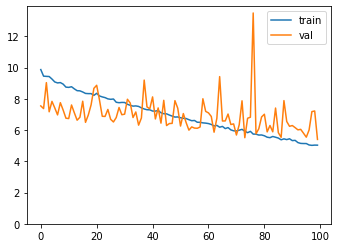

In [46]:
set_random_seeds()

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy', mcc]
)

metric_to_monitor = 'val_loss'
FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix='fine_tuning_merged_model_best_branches_')
early_stopping = EarlyStopping(
    monitor=metric_to_monitor, 
    mode='min', 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    FILE_MODEL, 
    monitor=metric_to_monitor, 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

class_weights = [compute_class_weights(y_train[:, i]) for i in range(y_train.shape[1])]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("class_train", dict_train)
mlflow.log_param("class_val", dict_val)
mlflow.log_param("class_train_prop", dict_train_props)
mlflow.log_param("class_val_prop", dict_val_props)
mlflow.keras.autolog()

hist = model.fit(
    x_train, 
    np.hsplit(y_train, range(1, y_train.shape[1])), 
    batch_size=32, 
    epochs=100, 
    validation_data=(x_val, np.hsplit(y_val, range(1, y_val.shape[1]))),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights,
)
plot.keras_hist(hist.history)

mlflow.end_run()

# Test 

In [53]:
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

1 of 1


In [54]:
y_pred = model.predict(im)
for pred in y_pred:
    print(pred)

[[0.9999925]]
[[0.4833015]]
[[0.99986935]]
[[0.95410115]]
[[0.99432653]]
[[1.]]
[[0.7391893]]
[[0.94860524]]
[[0.44719017]]
[[0.55361384]]
[[0.8507621]]
[[0.9888909]]
[[0.42327988]]
[[0.9995766]]
[[0.9972958]]
[[0.99966717]]
[[0.33954966]]
[[1.]]
[[0.9369473]]
[[1.]]
[[0.9999914]]
[[0.7921338]]
[[1.]]


In [48]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_recompiled = load_model(FILE_MODEL, custom_objects=custom_objects)
model_recompiled.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')
model_recompiled.save(FILE_MODEL)

y_pred_1 = model.predict(x_val)
y_pred_2 = model_recompiled.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [52]:
merged_model = load_model(FILE_MODEL)
y_pred = merged_model.predict(im)
for pred in y_pred:
    print(pred)

1 of 1
[[0.9999925]]
[[0.4833015]]
[[0.99986935]]
[[0.95410115]]
[[0.99432653]]
[[1.]]
[[0.7391893]]
[[0.94860524]]
[[0.44719017]]
[[0.55361384]]
[[0.8507621]]
[[0.9888909]]
[[0.42327988]]
[[0.9995766]]
[[0.9972958]]
[[0.99966717]]
[[0.33954966]]
[[1.]]
[[0.9369473]]
[[1.]]
[[0.9999914]]
[[0.7921338]]
[[1.]]


In [ ]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_1 = load_model('C:/Users/arnal/Downloads/model.h5', custom_objects=custom_objects)
model_2 = load_model(FILE_MODEL)

y_pred_1 = model_1.predict(x_val)
y_pred_2 = model_2.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))